# EFFICIENT LOAD

In [1]:
import pandas as pd
import numpy as np
import glob

pd.set_option("display.max_columns", None)

# ============================================================
# LOAD DATA
# ============================================================

sup = pd.read_csv("supplementary_data.csv", low_memory=False)
sup = sup.drop(["game_date", "game_time_eastern"], axis=1)
sup["is_complete"] = (sup["pass_result"] == "C").astype(int)

input_files = sorted(glob.glob("input_2023_w*.csv"))
output_files = sorted(glob.glob("output_2023_w*.csv"))

print("Input files:", input_files)
print("Output files:", output_files)

train_input = pd.concat([pd.read_csv(f) for f in input_files], ignore_index=True)
train_output = pd.concat([pd.read_csv(f) for f in output_files], ignore_index=True)

print(train_input.shape, train_output.shape)


Input files: ['input_2023_w01.csv', 'input_2023_w02.csv', 'input_2023_w03.csv', 'input_2023_w04.csv', 'input_2023_w05.csv', 'input_2023_w06.csv', 'input_2023_w07.csv', 'input_2023_w08.csv', 'input_2023_w09.csv', 'input_2023_w10.csv', 'input_2023_w11.csv', 'input_2023_w12.csv', 'input_2023_w13.csv', 'input_2023_w14.csv', 'input_2023_w15.csv', 'input_2023_w16.csv', 'input_2023_w17.csv', 'input_2023_w18.csv']
Output files: ['output_2023_w01.csv', 'output_2023_w02.csv', 'output_2023_w03.csv', 'output_2023_w04.csv', 'output_2023_w05.csv', 'output_2023_w06.csv', 'output_2023_w07.csv', 'output_2023_w08.csv', 'output_2023_w09.csv', 'output_2023_w10.csv', 'output_2023_w11.csv', 'output_2023_w12.csv', 'output_2023_w13.csv', 'output_2023_w14.csv', 'output_2023_w15.csv', 'output_2023_w16.csv', 'output_2023_w17.csv', 'output_2023_w18.csv']
(4880579, 23) (562936, 6)


In [ ]:
FRAME_DURATION = 0.1 # each frame is 10 Hz, which equates to .1 seconds

# Add play-level completion label to both input and output
train_input = train_input.merge(
    sup[["game_id", "play_id", "is_complete"]],
    on=["game_id", "play_id"],
    how="left"
)
train_output = train_output.merge(
    sup[["game_id", "play_id", "is_complete"]],
    on=["game_id", "play_id"],
    how="left"
)

# ============================================================
# THROW TIMING + FLIGHT TIME
# ============================================================

# last input frame per play
last_input = (
    train_input[["game_id", "play_id", "frame_id"]]
    .groupby(["game_id", "play_id"], as_index=False)["frame_id"]
    .max()
    .rename(columns={"frame_id": "last_input_frame"})
)

train_input = train_input.merge(last_input, on=["game_id", "play_id"], how="left")

# time_since_throw for input
train_input["time_since_throw"] = (
    (train_input["frame_id"] - train_input["last_input_frame"]) * FRAME_DURATION
)

# For OUTPUT frames, define frame 1 as 0.1 seconds since throw:
train_output["time_since_throw"] = train_output["frame_id"] * FRAME_DURATION


# flight length from num_frames_output
flight = (
    train_input.dropna(subset=["num_frames_output"])
    .groupby(["game_id", "play_id"], as_index=False)["num_frames_output"]
    .max()
    .rename(columns={"num_frames_output": "num_frames_output_play"})
)

train_input = train_input.merge(flight, on=["game_id", "play_id"], how="left")
train_output = train_output.merge(flight, on=["game_id", "play_id"], how="left")

for df in (train_input, train_output):
    df["time_in_air"] = df["num_frames_output_play"] * FRAME_DURATION
    df["time_to_arrival"] = df["time_in_air"] - df["time_since_throw"]


In [3]:

# ============================================================
# STATIC PLAYER INFO (ONE ROW PER GAME/PLAY/PLAYER)
# ============================================================

static_cols = [
    "game_id", "play_id", "nfl_id",
    "player_name", 
    "player_height", "player_weight",
    "player_side",
     "player_position",
    "player_role",
    "num_frames_output", "ball_land_x", "ball_land_y"
]

static_info = (
    train_input[static_cols]
    .drop_duplicates(subset=["game_id", "play_id", "nfl_id"])
)

# attach static info to train_output
train_output = train_output.merge(
    static_info,
    on=["game_id", "play_id", "nfl_id"],
    how="left"
)


In [4]:
train_input

game_id  play_id  player_to_predict  nfl_id  frame_id  \
0        2023090700      101              False   54527         1   
1        2023090700      101              False   54527         2   
2        2023090700      101              False   54527         3   
3        2023090700      101              False   54527         4   
4        2023090700      101              False   54527         5   
...             ...      ...                ...     ...       ...   
4880574  2024010713     4018               True   52457        23   
4880575  2024010713     4018               True   52457        24   
4880576  2024010713     4018               True   52457        25   
4880577  2024010713     4018               True   52457        26   
4880578  2024010713     4018               True   52457        27   

        play_direction  absolute_yardline_number     player_name  \
0                right                        42      Bryan Cook   
1                right                        42      Bryan Cook   
2                right                        42      Bryan Cook   
3                right                        42      Bryan Cook   
4                right                        42      Bryan Cook   
...                ...                       ...             ...   
4880574           left                        50  Chase Claypool   
4880575           left                        50  Chase Claypool   
4880576           left                        50  Chase Claypool   
4880577           left                        50  Chase Claypool   
4880578           left                        50  Chase Claypool   

        player_height  player_weight player_birth_date player_position  \
0                 6-1            210        1999-09-07              FS   
1                 6-1            210        1999-09-07              FS   
2                 6-1            210        1999-09-07              FS   
3                 6-1            210        1999-09-07              FS   
4                 6-1            210        1999-09-07              FS   
...               ...            ...               ...             ...   
4880574           6-4            227        1998-07-07              WR   
4880575           6-4            227        1998-07-07              WR   
4880576           6-4            227        1998-07-07              WR   
4880577           6-4            227        1998-07-07              WR   
4880578           6-4            227        1998-07-07              WR   

        player_side         player_role      x      y     s     a     dir  \
0           Defense  Defensive Coverage  52.33  36.94  0.09  0.39  322.40   
1           Defense  Defensive Coverage  52.33  36.94  0.04  0.61  200.89   
2           Defense  Defensive Coverage  52.33  36.93  0.12  0.73  147.55   
3           Defense  Defensive Coverage  52.35  36.92  0.23  0.81  131.40   
4           Defense  Defensive Coverage  52.37  36.90  0.35  0.82  123.26   
...             ...                 ...    ...    ...   ...   ...     ...   
4880574     Offense   Targeted Receiver  41.61  17.57  7.81  0.58  267.16   
4880575     Offense   Targeted Receiver  40.82  17.52  7.92  0.19  266.40   
4880576     Offense   Targeted Receiver  40.03  17.46  7.92  0.69  265.49   
4880577     Offense   Targeted Receiver  39.24  17.36  7.94  1.46  263.26   
4880578     Offense   Targeted Receiver  38.45  17.24  7.89  2.06  261.04   

              o  num_frames_output  ball_land_x  ball_land_y  is_complete  \
0        238.24                 21    63.259998        -0.22            0   
1        236.05                 21    63.259998        -0.22            0   
2        240.60                 21    63.259998        -0.22            0   
3        244.25                 21    63.259998        -0.22            0   
4        244.25                 21    63.259998        -0.22            0   
...         ...                ...          ...          ...          ...   
4880574  296.

In [5]:

# ============================================================
# PLAY-LEVEL LABEL & TARGETED RECEIVER STATIC INFO
# ============================================================

sup = sup.copy()

# targeted receiver rows (one per play)
tr_input = train_input[train_input["player_role"] == "Targeted Receiver"].copy()

tr_input_last = (
    tr_input.sort_values(["game_id", "play_id"])
            .groupby(["game_id", "play_id", "nfl_id"], as_index=False)
            .tail(1)
)

tr_static_cols = [
    "player_name",
    "player_height",
    "player_weight",
    "player_side",
    "player_position",
    "player_role",
    "ball_land_x",
    "ball_land_y",
    "num_frames_output"
]

static_info_tr = tr_input_last[["game_id", "play_id", "nfl_id"] + tr_static_cols]


# ============================================================
# PASSER (QB) PLAY-LEVEL INFO
# ============================================================

passers_play = (
    train_input[train_input["player_role"] == "Passer"]
    .sort_values(["game_id", "play_id", "frame_id"])
    .groupby(["game_id", "play_id"], as_index=False)
    .agg(
        passer_nfl_id=("nfl_id", "first"),
        passer_name=("player_name", "first"),
        passer_position=("player_position", "first")
    )
)

passers_play = passers_play[passers_play["passer_position"] == "QB"] \
                           .drop(columns=["passer_position"])

static_info_tr = static_info_tr.merge(
    passers_play,
    on=["game_id", "play_id"],
    how="inner"        # only plays with a QB passer
)

# ============================================================
# FRAME-LEVEL OUTPUT (ONLY PLAYS WITH QB PASSER)
# ============================================================

output_sub = train_output.merge(
    static_info_tr[["game_id", "play_id"]].drop_duplicates(),
    on=["game_id", "play_id"],
    how="inner"
)

In [6]:

# ============================================================
# RECEIVER VS DEFENDER FRAMES
# ============================================================

static_cols_for_merge = [
    "game_id", "play_id", "nfl_id",
    "passer_nfl_id", "passer_name"
]

receiver_frames = output_sub.merge(
    static_info_tr[static_cols_for_merge],
    on=["game_id", "play_id", "nfl_id"],
    how="inner"   # targeted receiver frames only
)

defender_frames = output_sub[output_sub["player_side"] == "Defense"].copy()


In [7]:

# ============================================================
# FEATURE ENGINEERING for OUTPUT
# ============================================================

# receiver timing (output-only; input timing computed below...)
receiver_frames["time_since_throw"] = receiver_frames["frame_id"] * FRAME_DURATION
receiver_frames["time_in_air"] = receiver_frames["num_frames_output"] * FRAME_DURATION
receiver_frames["time_to_arrival"] = (
    receiver_frames["time_in_air"] - receiver_frames["time_since_throw"]
)

# receiver distance to ball landing location
receiver_frames["dist_receiver_to_ball"] = np.sqrt(
    (receiver_frames["x"] - receiver_frames["ball_land_x"]) ** 2
    + (receiver_frames["y"] - receiver_frames["ball_land_y"]) ** 2
)

# defenders
def_df = defender_frames.rename(
    columns={
        "nfl_id": "def_nfl_id",
        "x": "def_x",
        "y": "def_y",
        "player_side": "def_side",
        "player_role": "def_role",
        "player_name": "def_name"
    }
)

# join each receiver frame with all defenders in same play/frame
wr_db = receiver_frames.merge(
    def_df[["game_id", "play_id", "frame_id", "def_nfl_id", "def_x", "def_y", "def_name"]],
    on=["game_id", "play_id", "frame_id"],
    how="left"
)

# receiver–defender distance per defender
wr_db["dist_wr_db"] = np.sqrt(
    (wr_db["x"] - wr_db["def_x"]) ** 2
    + (wr_db["y"] - wr_db["def_y"]) ** 2
)

# nearest defender distance at each receiver frame
nearest_def = (
    wr_db.groupby(["game_id", "play_id", "nfl_id", "frame_id"], as_index=False)
         .agg(min_dist_defender=("dist_wr_db", "min"))
)

receiver_frames = receiver_frames.merge(
    nearest_def,
    on=["game_id", "play_id", "nfl_id", "frame_id"],
    how="left"
)

In [8]:

# ============================================================
# PRE‑THROW RECEIVER FRAMES (INPUT)
# ============================================================

# targeted receiver rows in INPUT
tr_input = train_input[train_input["player_role"] == "Targeted Receiver"].copy()

# one row per game/play/nfl_id at each input frame
receiver_frames_input = tr_input.merge(
    static_info_tr[["game_id", "play_id", "nfl_id", "passer_nfl_id", "passer_name"]],
    on=["game_id", "play_id", "nfl_id"],
    how="inner"
)

# time_since_throw is already on train_input; keep it
receiver_frames_input["time_in_air"] = receiver_frames_input["num_frames_output_play"] * FRAME_DURATION
receiver_frames_input["time_to_arrival"] = (
    receiver_frames_input["time_in_air"] - receiver_frames_input["time_since_throw"]
)

# distance receiver to ball landing
receiver_frames_input["dist_receiver_to_ball"] = np.sqrt(
    (receiver_frames_input["x"] - receiver_frames_input["ball_land_x"]) ** 2
    + (receiver_frames_input["y"] - receiver_frames_input["ball_land_y"]) ** 2
)

# defenders in INPUT
defender_frames_input = train_input[train_input["player_side"] == "Defense"].copy()

def_df_in = defender_frames_input.rename(
    columns={
        "nfl_id": "def_nfl_id",
        "x": "def_x",
        "y": "def_y",
        "player_side": "def_side",
        "player_role": "def_role",
        "player_name": "def_name"
    }
)

wr_db_in = receiver_frames_input.merge(
    def_df_in[["game_id", "play_id", "frame_id", "def_nfl_id", "def_x", "def_y", "def_name"]],
    on=["game_id", "play_id", "frame_id"],
    how="left"
)

wr_db_in["dist_wr_db"] = np.sqrt(
    (wr_db_in["x"] - wr_db_in["def_x"]) ** 2
    + (wr_db_in["y"] - wr_db_in["def_y"]) ** 2
)

nearest_def_in = (
    wr_db_in.groupby(["game_id", "play_id", "nfl_id", "frame_id"], as_index=False)
             .agg(min_dist_defender=("dist_wr_db", "min"))
)

receiver_frames_input = receiver_frames_input.merge(
    nearest_def_in,
    on=["game_id", "play_id", "nfl_id", "frame_id"],
    how="left"
)


In [9]:

# height conversion to inches
def height_to_inches(h):
    if pd.isna(h):
        return np.nan
    try:
        ft, inch = str(h).split("-")
        return int(ft) * 12 + int(inch)
    except Exception:
        return np.nan

for df_ in (receiver_frames_input, receiver_frames):
    df_["player_height_in"] = df_["player_height"].apply(height_to_inches)
    df_["ball_x_bucket"] = pd.cut(
        df_["ball_land_x"],
        bins=[0, 40, 80, 120],
        labels=["0-40", "40-80", "80-120"],
        include_lowest=True
    )
    df_["ball_y_bucket"] = pd.cut(
        df_["ball_land_y"],
        bins=[-4, 18, 36, 58],  # the max is 57.33 and the min is 3.91... the field is only 0-53 in width, so those are out of bounds throws.

        labels=["left", "middle", "right"],
        include_lowest=True
    )


In [10]:
# tag source so you can distinguish pre‑/post‑throw
receiver_frames_input["source"] = "input"
receiver_frames["source"] = "output"

final_frame_level_df = pd.concat(
    [receiver_frames_input, receiver_frames],
    ignore_index=True
)[[
    "game_id", "play_id", "nfl_id",           
    "x", "y",
    "ball_land_x", "ball_land_y",
    "ball_y_bucket", "ball_x_bucket",
    "time_since_throw",
    "time_in_air",
    "time_to_arrival",
    "frame_id", # new: input vs output
    "source", 
    "dist_receiver_to_ball",
    "min_dist_defender",
    "player_name",
    "player_height_in", "player_weight",
    "player_side",
    "player_position",
    "player_role",
    "is_complete",
    "passer_nfl_id", "passer_name"
]].copy()


In [11]:
final_frame_level_df

game_id  play_id  nfl_id      x      y  ball_land_x  ball_land_y  \
0       2023090700      101   44930  41.03  12.17    63.259998        -0.22   
1       2023090700      101   44930  41.03  12.17    63.259998        -0.22   
2       2023090700      101   44930  41.05  12.18    63.259998        -0.22   
3       2023090700      101   44930  41.07  12.20    63.259998        -0.22   
4       2023090700      101   44930  41.11  12.22    63.259998        -0.22   
...            ...      ...     ...    ...    ...          ...          ...   
556907  2024010713     4018   52457  30.99  10.51    32.139999         6.71   
556908  2024010713     4018   52457  30.78   9.73    32.139999         6.71   
556909  2024010713     4018   52457  30.63   8.93    32.139999         6.71   
556910  2024010713     4018   52457  30.52   8.12    32.139999         6.71   
556911  2024010713     4018   52457  30.45   7.30    32.139999         6.71   

       ball_y_bucket ball_x_bucket  time_since_throw  time_in_air  \
0               left         40-80              -2.5          2.1   
1               left         40-80              -2.4          2.1   
2               left         40-80              -2.3          2.1   
3               left         40-80              -2.2          2.1   
4               left         40-80              -2.1          2.1   
...              ...           ...               ...          ...   
556907          left          0-40               1.4          1.8   
556908          left          0-40               1.5          1.8   
556909          left          0-40               1.6          1.8   
556910          left          0-40               1.7          1.8   
556911          left          0-40               1.8          1.8   

        time_to_arrival  frame_id  source  dist_receiver_to_ball  \
0                   4.6         1   input              25.449655   
1                   4.5         2   input              25.449655   
2                   4.4         3   input              25.437060   
3                   4.3         4   input              25.429361   
4                   4.2         5   input              25.404252   
...                 ...       ...     ...                    ...   
556907              0.4        14  output               3.970201   
556908              0.3        15  output               3.312099   
556909              0.2        16  output               2.684865   
556910              0.1        17  output               2.147673   
556911              0.0        18  output               1.790027   

        min_dist_defender     player_name  player_height_in  player_weight  \
0                3.423814   Josh Reynolds                75            196   
1                3.511595   Josh Reynolds                75            196   
2                3.571064   Josh Reynolds                75            196   
3                3.620635   Josh Reynolds                75            196   
4                3.659030   Josh Reynolds                75            196   
...                   ...             ...               ...            ...   
556907           1.700735  Chase Claypool                76            227   
556908           1.691981  Chase Claypool                76            227   
556909           1.667093  Chase Claypool                76            227   
556910           1.607016  Chase Claypool                76            227   
556911           1.528202  Chase Claypool                76            227   

       player_side player_position        player_role  is_complete  \
0          Offense              WR  Targeted Receiver            0   
1          Offense              WR  Targeted Receiver            0   
2          Offense              WR  Targeted Receiver            0   
3          Offense              WR  Targeted Receiver            0   
4          Offense              WR  Targeted Receiver            0   
...            ...             ...                ...      

# PREDICTIVE MODELING (without using reaction time)

In [12]:
import numpy as np
import pandas as pd

# Keep only frames at arrival
arrival_df = final_frame_level_df[final_frame_level_df["time_to_arrival"] == 0].copy()

# verify we have 1 frame per play:
print(arrival_df.shape)

# check to see how well the data is balanced:
arrival_df["is_complete"].value_counts()

(14102, 25)


is_complete
1    9735
0    4367
Name: count, dtype: int64

## Pipeline #1 (with only train/test split)

### Check for Missing Data & Impute
- decided to just drop all na in next section instead

In [13]:
arrival_df.isna().sum()

game_id                     0
play_id                     0
nfl_id                      0
x                           0
y                           0
ball_land_x                 0
ball_land_y                 0
ball_y_bucket               0
ball_x_bucket              33
time_since_throw            0
time_in_air                 0
time_to_arrival             0
frame_id                    0
source                      0
dist_receiver_to_ball       0
min_dist_defender        1141
player_name                 0
player_height_in            0
player_weight               0
player_side                 0
player_position             0
player_role                 0
is_complete                 0
passer_nfl_id               0
passer_name                 0
dtype: int64

In [14]:
# Identify arrival frames with any missing data in features (ignore the buckets... we won't use)
# lots of short, quick, passes with nobody around... 
# just drop these... hard to predict catch probability if the defender isn't nearby

nan_mask = arrival_df.isna().any(axis=1)
dropped_frames = arrival_df[nan_mask].copy()
display(dropped_frames.player_position.value_counts())
dropped_frames

player_position
RB    627
TE    304
WR    227
FB     13
QB      2
T       1
Name: count, dtype: int64

game_id  play_id  nfl_id      x      y  ball_land_x  ball_land_y  \
396828  2023090700     1300   55876  37.93  12.20    39.360001    13.770000   
396957  2023090700     1837   55899  76.72  20.52    78.010002    20.840000   
397039  2023090700     2435   54716  28.11  48.02    27.959999    45.650002   
397096  2023090700     2825   54716  29.46  17.20    28.580000    18.320000   
397103  2023090700     2906   42460  84.86   4.86    82.940002     6.140000   
...            ...      ...     ...    ...    ...          ...          ...   
556191  2024010712     3654   55917  69.60  32.43    69.730003    31.500000   
556198  2024010712     3679   55917  57.55  31.12    64.089996    30.190001   
556252  2024010712     3858   44917  55.79  27.05    54.790001    26.510000   
556348  2024010713      345   54528  89.24  32.05    88.000000    30.590000   
556848  2024010713     3570   54528  34.79  14.54    32.779999    15.070000   

       ball_y_bucket ball_x_bucket  time_since_throw  time_in_air  \
396828          left          0-40               0.7          0.7   
396957        middle         40-80               0.7          0.7   
397039         right          0-40               1.3          1.3   
397096        middle          0-40               0.9          0.9   
397103          left        80-120               0.7          0.7   
...              ...           ...               ...          ...   
556191        middle         40-80               0.6          0.6   
556198        middle         40-80               0.7          0.7   
556252        middle         40-80               0.6          0.6   
556348        middle        80-120               0.7          0.7   
556848          left          0-40               0.8          0.8   

        time_to_arrival  frame_id  source  dist_receiver_to_ball  \
396828              0.0         7  output               2.123630   
396957              0.0         7  output               1.329100   
397039              0.0        13  output               2.374741   
397096              0.0         9  output               1.424359   
397103              0.0         7  output               2.307551   
...                 ...       ...     ...                    ...   
556191              0.0         6  output               0.939043   
556198              0.0         7  output               6.605789   
556252              0.0         6  output               1.136485   
556348              0.0         7  output               1.915515   
556848              0.0         8  output               2.078703   

        min_dist_defender      player_name  player_height_in  player_weight  \
396828                NaN     Jahmyr Gibbs                71            200   
396957                NaN      Sam LaPorta                76            249   
397039                NaN    Isiah Pacheco                71            215   
397096                NaN    Isiah Pacheco                71            215   
397103                NaN       Blake Bell                78            252   
...                   ...              ...               ...            ...   
556191                NaN  Zach Charbonnet                73            220   
556198                NaN  Zach Charbonnet                73            220   
556252                NaN     James Conner                73            233   
556348                NaN       James Cook                71            190   
556848                NaN       James Cook                71            190   

       player_side player_position        player_role  is_complete  \
396828     Offense              RB  Targeted Receiver            1   
396957     Offense              TE  Targeted Receiver            1   
397039     Offense              RB  Targeted Receiver            1   
397096     Offense              RB  Targeted Receiver            1   
397103     Offense              TE  Targeted Receiver            1   
...            ...             ...             

In [15]:
# # first idea: if there is no value for closest defender, then insert the max distance within the data... 
# # --> ended up making the model worse than just dropping those rows... see explanation above for dropping ^
# max_min_dist = final_frame_level_df["min_dist_defender"].max()
# final_frame_level_df["min_dist_defender"] = final_frame_level_df["min_dist_defender"].fillna(max_min_dist)

### Feature selection, scaling, & Run Logistic Model

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

# Choose features (you can expand this list)
feature_cols = [
    "x", "y",
    "ball_land_x", "ball_land_y",
    #"ball_x_bucket", "ball_y_bucket", # categorical version is not needed and redundant
    "dist_receiver_to_ball",
    "min_dist_defender",
    "time_in_air",
    #"player_height_in", "player_weight" # these make predictions worse
]

# Drop rows with NaNs in features or target (aka rows where min_dist_defender is NaN)
model_df = arrival_df.dropna(subset=feature_cols + ["is_complete"]).copy()


X = model_df[feature_cols].copy()
y = model_df["is_complete"].astype(int)


In [17]:
import warnings

# Hide all warnings
warnings.filterwarnings("ignore")

# split into train and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)


# Pipeline: scaler + L2 logistic
pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("logit", LogisticRegression(
            penalty="l2",
            solver="lbfgs",
            max_iter=1000
        ))
    ]
)

# Hyperparameter grid for C (regularization strength)
param_grid = {
    "logit__C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Tuning hyperparameters with GridSearchCV (L2)...")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)
print("Best CV AUC-ROC:", grid_search.best_score_)

# Evaluate best model on held-out test set
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))


Tuning hyperparameters with GridSearchCV (L2)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'logit__C': 0.1}
Best CV AUC-ROC: 0.8010659919453188
Test Accuracy: 0.7709217123023525
Test ROC AUC: 0.812872930554883


In [18]:
# -------- add predictions back into the arrival frame dataset --------
model_df = model_df.copy()

# sell all DataFrame floats to display with 2 decimals everywhere:
pd.set_option("display.float_format", lambda x: f"{x:.2f}")


# Use best_model from GridSearchCV (Pipeline)
# store as float rounded to 3 decimals
model_df["catch_prob"] = best_model.predict_proba(X)[:, 1].round(3)
model_df["pred_is_complete"] = (model_df["catch_prob"] >= 0.5).astype(int)

arrival_with_preds = model_df.sort_values("catch_prob", ascending=False)

arrival_with_preds

game_id  play_id  nfl_id     x     y  ball_land_x  ball_land_y  \
531331  2023122403      394   55943 66.70 10.97        66.35        11.37   
497248  2023112603     1692   41233  1.94  6.24         2.04         6.18   
506684  2023120306     2609   52474 87.17 13.42        87.42        13.20   
482337  2023111208     3977   43584 80.81 15.15        81.86        15.36   
535598  2023122409     1654   44917 93.97 42.14        94.23        42.27   
...            ...      ...     ...   ...   ...          ...          ...   
486300  2023111901     3963   47849 58.87 48.86        41.62        49.85   
444897  2023101503     3703   53434 82.40  0.68        64.79        -0.53   
450617  2023101512     4337   46071 36.56 51.75        38.28         0.80   
409848  2023091706      844   56056 24.02 45.86         8.11        53.91   
405608  2023091100     3167   54475 12.94 40.80         9.72        45.46   

       ball_y_bucket ball_x_bucket  time_since_throw  time_in_air  \
531331          left         40-80              1.30         1.30   
497248          left          0-40              1.80         1.80   
506684          left        80-120              1.00         1.00   
482337          left        80-120              1.20         1.20   
535598         right        80-120              1.20         1.20   
...              ...           ...               ...          ...   
486300         right         40-80              2.70         2.70   
444897          left         40-80              2.60         2.60   
450617          left          0-40              1.10         1.10   
409848         right          0-40              2.30         2.30   
405608         right          0-40              9.40         9.40   

        time_to_arrival  frame_id  source  dist_receiver_to_ball  \
531331             0.00        13  output                   0.53   
497248             0.00        18  output                   0.12   
506684             0.00        10  output                   0.33   
482337             0.00        12  output                   1.07   
535598             0.00        12  output                   0.29   
...                 ...       ...     ...                    ...   
486300             0.00        27  output                  17.28   
444897             0.00        26  output                  17.65   
450617             0.00        11  output                  50.98   
409848             0.00        23  output                  17.83   
405608             0.00        94  output                   5.66   

        min_dist_defender      player_name  player_height_in  player_weight  \
531331              19.31     Tucker Kraft                77            255   
497248              17.10       Mike Evans                77            231   
506684              17.22   Antonio Gibson                74            221   
482337              17.51    Kalif Raymond                68            182   
535598              17.91     James Conner                73            233   
...                   ...              ...               ...            ...   
486300               4.18  Diontae Johnson                70            181   
444897               2.99    Ja'Marr Chase                73            200   
450617              45.35   Saquon Barkley                71            233   
409848               5.14      Trey Palmer                73            190   
405608               3.22   Garrett Wilson                72            192   

       player_side player_position        player_role  is_complete  \
531331     Offense              TE  Targeted Receiver            1   
497248     Offense              WR  Targeted Receiver            1   
506684     Offense              RB  Targeted Receiver            1   
482337     Offense              WR  Targeted Receiver            1   
535598     Offense              RB  Targeted Receiver            1   
...            ...             ...                ...          ...   
4

## Pipeline #2 (With Validation)... I use this the rest of the way as the main one

### Feature Selection, Train/Validation/Test Split, Scaling

In [19]:
import numpy as np
import pandas as pd

np.random.seed(1)

# Start from arrival-only frame-level data
# arr_df = catch_prob_frame_lvl_df[np.isclose(catch_prob_frame_lvl_df["time_to_arrival"], 0.0)].copy()

# Feature set (numeric + categorical)
features = [
    "x", "y",
    "ball_land_x", "ball_land_y",
    "dist_receiver_to_ball",
    "min_dist_defender",
    "time_in_air",
    "player_height_in",
    "player_weight",
    "player_position",      # categorical
    #"ball_x_bucket",        # categorical (redundant)
    #"ball_y_bucket"         # categorical (redundant)
 ]


# Drop rows with NaNs in features or target (aka rows where min_dist_defender is NaN)
arrival_df = arrival_df.dropna(subset=features + ["is_complete"]).copy()

X = arrival_df[features]
y = arrival_df["is_complete"].astype(int)

# 70% train, 30% temp
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

# 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp
)

print("Does feature have missing data (T/F)?\n")
print(arrival_df[features].isna().any())
print("\nTraining set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Does feature have missing data (T/F)?

x                        False
y                        False
ball_land_x              False
ball_land_y              False
dist_receiver_to_ball    False
min_dist_defender        False
time_in_air              False
player_height_in         False
player_weight            False
player_position          False
dtype: bool

Training set size: 9072
Validation set size: 1944
Test set size: 1945


In [20]:
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------
# 1. Separate numeric / categorical
# -------------------------------------------------
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns

print("\nNumerical columns:", list(numerical_cols))
print("Categorical columns:", list(categorical_cols))

# -------------------------------------------------
# 2. Numeric = use as-is (NaNs already dropped)
# -------------------------------------------------
X_train_num = X_train[numerical_cols].copy()
X_val_num = X_val[numerical_cols].copy()
X_test_num = X_test[numerical_cols].copy()

# -------------------------------------------------
# 3. Categorical: get_dummies only (no imputation needed because no data is missing)
# -------------------------------------------------
X_train_cat = pd.get_dummies(X_train[categorical_cols], drop_first=True).astype(int)
X_val_cat = pd.get_dummies(X_val[categorical_cols], drop_first=True).astype(int)
X_test_cat = pd.get_dummies(X_test[categorical_cols], drop_first=True).astype(int)

# Align dummy columns
all_cat_cols = X_train_cat.columns
X_val_cat = X_val_cat.reindex(columns=all_cat_cols, fill_value=0)
X_test_cat = X_test_cat.reindex(columns=all_cat_cols, fill_value=0)

print("\nFinal dummy shapes:")
print("Train:", X_train_cat.shape, "Val:", X_val_cat.shape, "Test:", X_test_cat.shape)

# -------------------------------------------------
# 4. Combine numeric + categorical
# -------------------------------------------------
X_train_combined = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_combined = pd.concat([X_val_num, X_val_cat], axis=1)
X_test_combined = pd.concat([X_test_num, X_test_cat], axis=1)

print("\nCombined shapes:")
print("Train:", X_train_combined.shape,
      "Val:", X_val_combined.shape,
      "Test:", X_test_combined.shape)

# -------------------------------------------------
# 5. Standardize
# -------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)
X_test_scaled = scaler.transform(X_test_combined)

feature_names = X_train_combined.columns


Numerical columns: ['x', 'y', 'ball_land_x', 'ball_land_y', 'dist_receiver_to_ball', 'min_dist_defender', 'time_in_air', 'player_height_in', 'player_weight']
Categorical columns: ['player_position']

Final dummy shapes:
Train: (9072, 7) Val: (1944, 7) Test: (1945, 7)

Combined shapes:
Train: (9072, 16) Val: (1944, 16) Test: (1945, 16)


### Logistic Model

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import warnings

# Hide all warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

log_reg_l2 = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    max_iter=1000,
    random_state=1
)

param_grid = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

# ------------------------------------------------------------------
# manual tuning on the validation set (instead of GridSearchCV)
# ------------------------------------------------------------------
best_log_reg_l2 = None
best_C = None
best_val_auc = -np.inf

for C in param_grid["C"]:
    model = LogisticRegression(
        penalty="l2",
        solver="liblinear",
        max_iter=1000,
        random_state=1,
        C=C
    )
    model.fit(X_train_scaled, y_train)
    y_val_prob_tmp = model.predict_proba(X_val_scaled)[:, 1]
    val_auc_tmp = roc_auc_score(y_val, y_val_prob_tmp)

    if val_auc_tmp > best_val_auc:
        best_val_auc = val_auc_tmp
        best_log_reg_l2 = model
        best_C = C
# ---------------------------------------------------------
# END of tuning
# ---------------------------------------------------------
print("Tuning hyperparameters on validation set (L2)...")
print("Best C (val-tuned):", best_C)
print("Best Validation AUC-ROC:", best_val_auc)

# -------------------- TEST set here -------------------
y_test_pred_l2 = best_log_reg_l2.predict(X_test_scaled)          
y_test_prob_l2 = best_log_reg_l2.predict_proba(X_test_scaled)[:, 1]  

print("\nTest performance (L2 logistic):")                        
print(classification_report(y_test, y_test_pred_l2))             
print("Test AUC-ROC:", roc_auc_score(y_test, y_test_prob_l2))    
# ------------------------------------------------------------------

# Coefficients & odds ratios
coef_df_l2 = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": best_log_reg_l2.coef_[0]
})
coef_df_l2["Odds_Ratio"] = np.exp(coef_df_l2["Coefficient"])
significant_features = coef_df_l2[coef_df_l2["Coefficient"] != 0].sort_values(
    "Coefficient", ascending=False
)
print("\nL2 coefficients (top 15):")
print(significant_features.head(15))

# Example interpretation for the top 2 features
for i, row in significant_features.head(2).iterrows():
    feature = row["Feature"]
    coef = row["Coefficient"]
    or_val = row["Odds_Ratio"]
    pct_change = (or_val - 1.0) * 100  # percent change in odds

    direction = "higher" if coef > 0 else "lower"
    print(
        f"\nFeature '{feature}': a one standard deviation increase in this feature "
        f"makes the odds of a completion about {pct_change:.0f}% {direction} "
        f"(odds ratio = {or_val:.2f}, coefficient = {coef:.2f}), "
        f"holding all other features constant."
    )


Tuning hyperparameters on validation set (L2)...
Best C (val-tuned): 100.0
Best Validation AUC-ROC: 0.8113326729546205

Test performance (L2 logistic):
              precision    recall  f1-score   support

           0       0.72      0.49      0.59       642
           1       0.78      0.91      0.84      1303

    accuracy                           0.77      1945
   macro avg       0.75      0.70      0.71      1945
weighted avg       0.76      0.77      0.76      1945

Test AUC-ROC: 0.8167301434743212

L2 coefficients (top 15):
                Feature  Coefficient  Odds_Ratio
5     min_dist_defender         0.98        2.68
0                     x         0.40        1.49
1                     y         0.26        1.30
9    player_position_DT         0.07        1.07
11  player_position_ILB         0.06        1.07
7      player_height_in         0.04        1.04
8         player_weight         0.04        1.04
12   player_position_QB         0.02        1.02
10   player_position

### Decision Tree

In [22]:
## Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score 

dt = DecisionTreeClassifier(criterion="gini", class_weight="balanced", random_state=1)

param_grid_dt = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
}

# ---------------------------------------------------------
# manual hyperparameter tuning on the validation set
# ---------------------------------------------------------
best_dt = None
best_params_dt = None
best_val_auc_dt = -np.inf

print("Tuning Decision Tree (validation set)...")
for max_depth in param_grid_dt["max_depth"]:
    for min_split in param_grid_dt["min_samples_split"]:
        for min_leaf in param_grid_dt["min_samples_leaf"]:
            dt_candidate = DecisionTreeClassifier(
                criterion="gini",
                class_weight="balanced",
                random_state=1,
                max_depth=max_depth,
                min_samples_split=min_split,
                min_samples_leaf=min_leaf,
            )
            dt_candidate.fit(X_train_scaled, y_train)
            y_val_prob_dt = dt_candidate.predict_proba(X_val_scaled)[:, 1]
            val_auc_dt = roc_auc_score(y_val, y_val_prob_dt)

            if val_auc_dt > best_val_auc_dt:
                best_val_auc_dt = val_auc_dt
                best_dt = dt_candidate
                best_params_dt = {
                    "max_depth": max_depth,
                    "min_samples_split": min_split,
                    "min_samples_leaf": min_leaf,
                }
# ---------------------------------------------------------
# END of tuning
# ---------------------------------------------------------

print("Best Decision Tree params (val-tuned):", best_params_dt)
print("Best Decision Tree Validation AUC-ROC:", best_val_auc_dt)

# -------------------- evaluate on TEST set ----------------
y_test_prob_dt = best_dt.predict_proba(X_test_scaled)[:, 1]    
y_test_pred_dt = best_dt.predict(X_test_scaled)                  

print("\nTest Performance (Decision Tree):")                      
print(classification_report(y_test, y_test_pred_dt))             
print("Test AUC-ROC:", roc_auc_score(y_test, y_test_prob_dt))    
# ------------------------------------------------------------------


Tuning Decision Tree (validation set)...
Best Decision Tree params (val-tuned): {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}
Best Decision Tree Validation AUC-ROC: 0.8129842179058338

Test Performance (Decision Tree):
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       642
           1       0.85      0.80      0.82      1303

    accuracy                           0.77      1945
   macro avg       0.74      0.75      0.74      1945
weighted avg       0.78      0.77      0.77      1945

Test AUC-ROC: 0.809586910628002


*Note that values in the tree are standard deviations (not raw values)


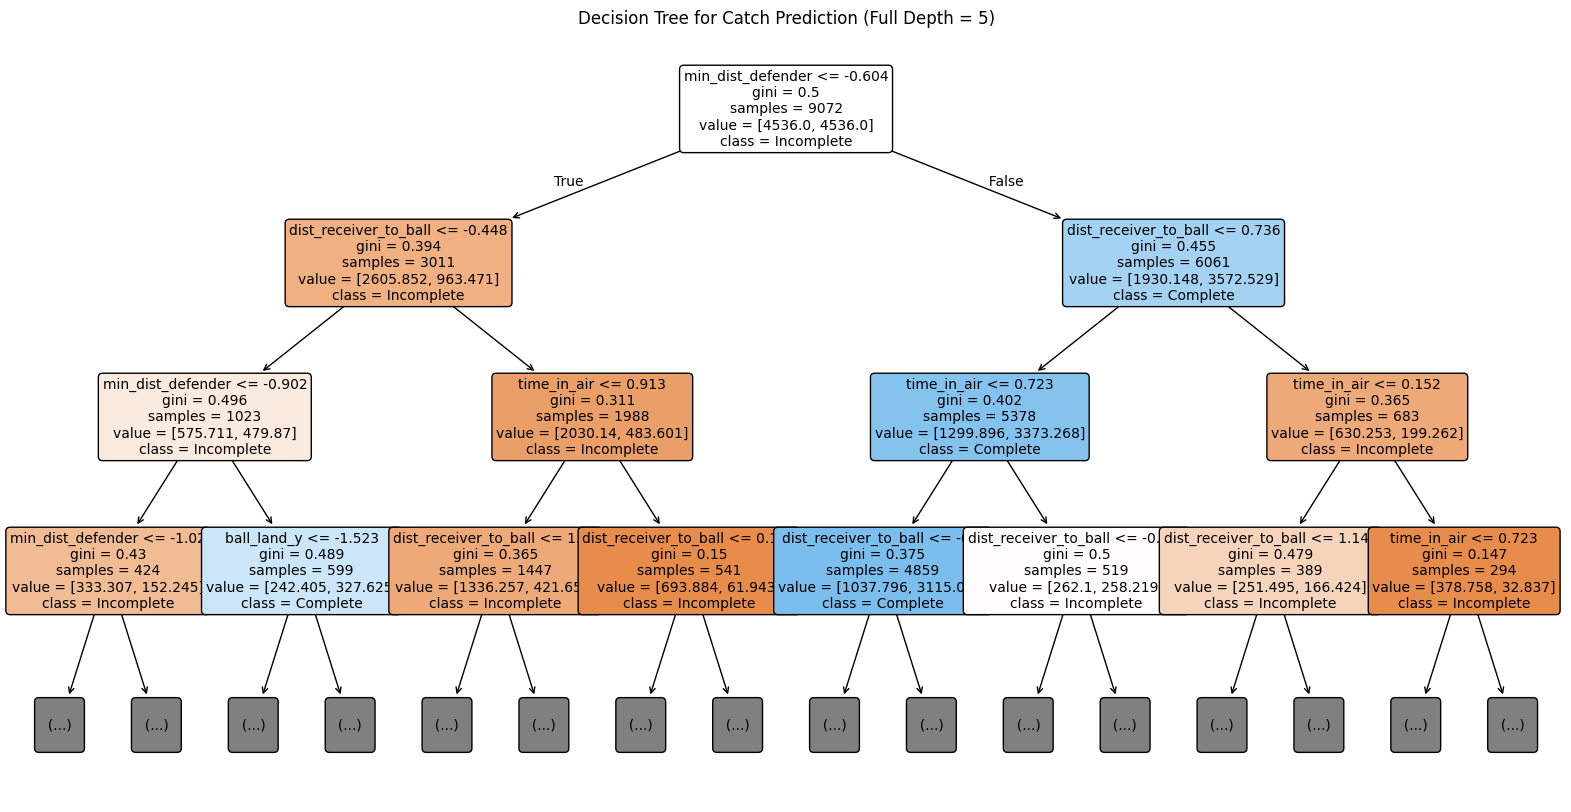

In [23]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plot_tree(
    best_dt,
    feature_names=feature_names,          # X_train_combined.columns
    class_names=["Incomplete", "Complete"],  # 0 = incomplete, 1 = complete
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3                           # just display top of the tree
)

plt.title(f"Decision Tree for Catch Prediction (Full Depth = {best_dt.get_depth()})")
plt.show()


### Rand Forest

In [24]:
## Rand Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

np.random.seed(42)

# Base Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=1,
    n_jobs=-1
)

# Hyperparameter grid
param_grid_rf = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", 0.5],
}

# ---------------------------------------------------------
# manual hyperparameter tuning on the validation set
# ---------------------------------------------------------
best_rf = None
best_params_rf = None
best_val_auc_rf = -np.inf

print("Tuning Random Forest (validation set)...")
for max_depth in param_grid_rf["max_depth"]:
    for min_split in param_grid_rf["min_samples_split"]:
        for min_leaf in param_grid_rf["min_samples_leaf"]:
            for max_feat in param_grid_rf["max_features"]:
                rf_candidate = RandomForestClassifier(
                    n_estimators=300,
                    class_weight="balanced",
                    random_state=1,
                    n_jobs=-1,
                    max_depth=max_depth,
                    min_samples_split=min_split,
                    min_samples_leaf=min_leaf,
                    max_features=max_feat,
                )
                rf_candidate.fit(X_train_scaled, y_train)
                y_val_prob_tmp = rf_candidate.predict_proba(X_val_scaled)[:, 1]
                val_auc_tmp = roc_auc_score(y_val, y_val_prob_tmp)

                if val_auc_tmp > best_val_auc_rf:
                    best_val_auc_rf = val_auc_tmp
                    best_rf = rf_candidate
                    best_params_rf = {
                        "max_depth": max_depth,
                        "min_samples_split": min_split,
                        "min_samples_leaf": min_leaf,
                        "max_features": max_feat,
                    }

print("Best RF params (val-tuned):", best_params_rf)
print("Best RF Validation AUC-ROC:", best_val_auc_rf)
# ---------------------------------------------------------
# END of tuning
# ---------------------------------------------------------

# -------------------- evaluate on TEST set ----------------
y_test_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]     
y_test_pred_rf = best_rf.predict(X_test_scaled)                 

print("\nTest Performance (Random Forest):")                      
print(classification_report(y_test, y_test_pred_rf))             
print("Test AUC-ROC:", roc_auc_score(y_test, y_test_prob_rf))    
# ------------------------------------------------------------------


Tuning Random Forest (validation set)...
Best RF params (val-tuned): {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best RF Validation AUC-ROC: 0.8308509314689598

Test Performance (Random Forest):
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       642
           1       0.86      0.83      0.84      1303

    accuracy                           0.79      1945
   macro avg       0.77      0.77      0.77      1945
weighted avg       0.80      0.79      0.80      1945

Test AUC-ROC: 0.8285791475698305


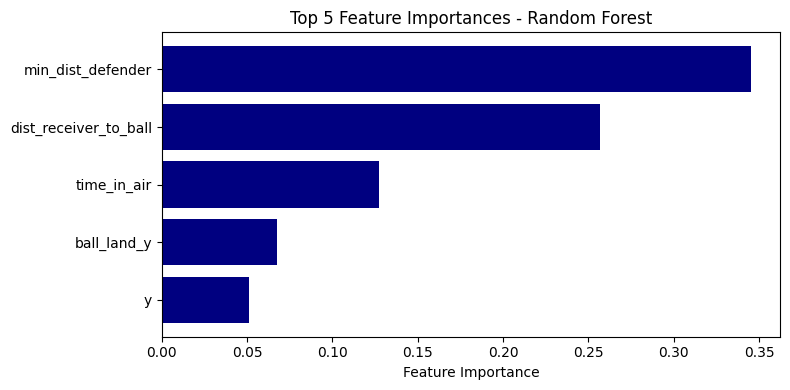

In [25]:
import numpy as np
import matplotlib.pyplot as plt

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:5]  # indices of top 5
top_features = feature_names[indices]
top_importances = importances[indices]

plt.figure(figsize=(8, 4))
plt.barh(range(len(top_features)), top_importances, color="navy")
plt.yticks(range(len(top_features)), top_features)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 5 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


### XGBoost Model

In [26]:
## XGBoost Model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

np.random.seed(42)

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",          # so training uses AUC internally
    use_label_encoder=False,
    tree_method="hist",
    random_state=1,
    n_estimators=300,
    n_jobs=-1
)

param_grid_xgb = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0],
    "min_child_weight": [1, 5]
}

# ---------------------------------------------------------
# manual hyperparameter tuning on the validation set
# ---------------------------------------------------------
best_xgb = None
best_params_xgb = None
best_val_auc_xgb = -np.inf

print("Tuning XGBoost (validation set)...")
for max_depth in param_grid_xgb["max_depth"]:
    for lr in param_grid_xgb["learning_rate"]:
        for subsample in param_grid_xgb["subsample"]:
            for colsample in param_grid_xgb["colsample_bytree"]:
                for mcw in param_grid_xgb["min_child_weight"]:
                    xgb_candidate = XGBClassifier(
                        objective="binary:logistic",
                        eval_metric="auc",
                        use_label_encoder=False,
                        tree_method="hist",
                        random_state=1,
                        n_estimators=300,
                        n_jobs=-1,
                        max_depth=max_depth,
                        learning_rate=lr,
                        subsample=subsample,
                        colsample_bytree=colsample,
                        min_child_weight=mcw,
                    )
                    xgb_candidate.fit(X_train_scaled, y_train)
                    y_val_prob_tmp = xgb_candidate.predict_proba(X_val_scaled)[:, 1]
                    val_auc_tmp = roc_auc_score(y_val, y_val_prob_tmp)

                    if val_auc_tmp > best_val_auc_xgb:
                        best_val_auc_xgb = val_auc_tmp
                        best_xgb = xgb_candidate
                        best_params_xgb = {
                            "max_depth": max_depth,
                            "learning_rate": lr,
                            "subsample": subsample,
                            "colsample_bytree": colsample,
                            "min_child_weight": mcw,
                        }

print("Best XGBoost params (val-tuned):", best_params_xgb)
print("Best XGBoost Validation AUC-ROC:", best_val_auc_xgb)
# ---------------------------------------------------------
# END of tuning section
# ---------------------------------------------------------

# -------------------- evaluate on TEST set ----------------
y_test_prob_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]   
y_test_pred_xgb = best_xgb.predict(X_test_scaled)               

print("\nTest Performance (XGBoost):")                            
print(classification_report(y_test, y_test_pred_xgb))            
print("Test AUC-ROC:", roc_auc_score(y_test, y_test_prob_xgb))   
# ------------------------------------------------------------------

Tuning XGBoost (validation set)...
Best XGBoost params (val-tuned): {'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 1.0, 'min_child_weight': 1}
Best XGBoost Validation AUC-ROC: 0.83939876825014

Test Performance (XGBoost):
              precision    recall  f1-score   support

           0       0.74      0.60      0.66       642
           1       0.82      0.90      0.86      1303

    accuracy                           0.80      1945
   macro avg       0.78      0.75      0.76      1945
weighted avg       0.79      0.80      0.79      1945

Test AUC-ROC: 0.8313154641935815


In [27]:
# 1) Rebuild the full scaled matrix in the same order as the dataframe
X_all_combined = pd.concat(
    [X_train_combined, X_val_combined, X_test_combined],
    axis=0
)
X_all_scaled = scaler.transform(X_all_combined)


# 2) Attach to the dataframe used to build X_all_combined
arrival_df_with_probs = arrival_df.loc[X_all_combined.index].copy()

# 3) Use best_xgb to get probabilities for every row
arrival_df_with_probs["catch_probability"] =  best_xgb.predict_proba(X_all_scaled)[:, 1]

# Optional: round for readability
arrival_df_with_probs["catch_probability"] = arrival_df_with_probs["catch_probability"].round(3)

arrival_df_with_probs.sort_values('catch_probability', ascending=False)


game_id  play_id  nfl_id      x     y  ball_land_x  ball_land_y  \
502137  2023113000      159   41246  33.30 39.56        33.28        39.60   
537997  2023122501     2151   53439  92.70  5.61        91.89         5.82   
407212  2023091701     2953   41282  44.76 14.06        44.83        14.15   
479613  2023111204     1891   47791  61.13  7.84        61.09         7.95   
542382  2023123105      235   41282  88.89  9.44        88.52         9.57   
...            ...      ...     ...    ...   ...          ...          ...   
465574  2023102909     3149   53463  82.62  2.31        69.15        -0.56   
404521  2023091012     2725   54629 104.67 11.47       105.30         1.61   
398413  2023091002     2517   52441  42.79 44.93        44.82        53.92   
532200  2023122404     2260   42347 118.33  4.01       123.29        -0.17   
507868  2023120308     2207   44881  63.73  6.27        59.25         0.33   

       ball_y_bucket ball_x_bucket  time_since_throw  time_in_air  \
502137         right          0-40              1.40         1.40   
537997          left        80-120              1.40         1.40   
407212          left         40-80              0.80         0.80   
479613          left         40-80              0.90         0.90   
542382          left        80-120              0.70         0.70   
...              ...           ...               ...          ...   
465574          left         40-80              2.70         2.70   
404521          left        80-120              1.90         1.90   
398413         right         40-80              1.60         1.60   
532200          left           NaN              2.60         2.60   
507868          left         40-80              1.60         1.60   

        time_to_arrival  frame_id  source  dist_receiver_to_ball  \
502137             0.00        14  output                   0.04   
537997             0.00        14  output                   0.84   
407212             0.00         8  output                   0.11   
479613             0.00         9  output                   0.12   
542382             0.00         7  output                   0.39   
...                 ...       ...     ...                    ...   
465574             0.00        27  output                  13.77   
404521             0.00        19  output                   9.88   
398413             0.00        16  output                   9.22   
532200             0.00        26  output                   6.49   
507868             0.00        16  output                   7.44   

        min_dist_defender     player_name  player_height_in  player_weight  \
502137               5.76   Brandin Cooks                70            183   
537997               6.60   DeVonta Smith                73            165   
407212               3.11   Davante Adams                73            215   
479613               5.00  T.J. Hockenson                77            248   
542382               7.51   Davante Adams                73            215   
...                   ...             ...               ...            ...   
465574               1.64    Elijah Moore                69            184   
404521               4.25  Kyren Williams                69            199   
398413               2.07     Tee Higgins                76            210   
532200               3.06    Amari Cooper                73            211   
507868               2.47     Cooper Kupp                74            208   

       player_side player_position        player_role  is_complete  \
502137     Offense              WR  Targeted Receiver            1   
537997     Offense              WR  Targeted Receiver            1   
407212     Offense              WR  Targeted Receiver            1   
479613     Offense              TE  Targeted Receiver            1   
542382     Offense              WR  Targeted Receiver            1   
...            ...             ...                ...          ...   
4

### Compare Models
- XGBoost is best

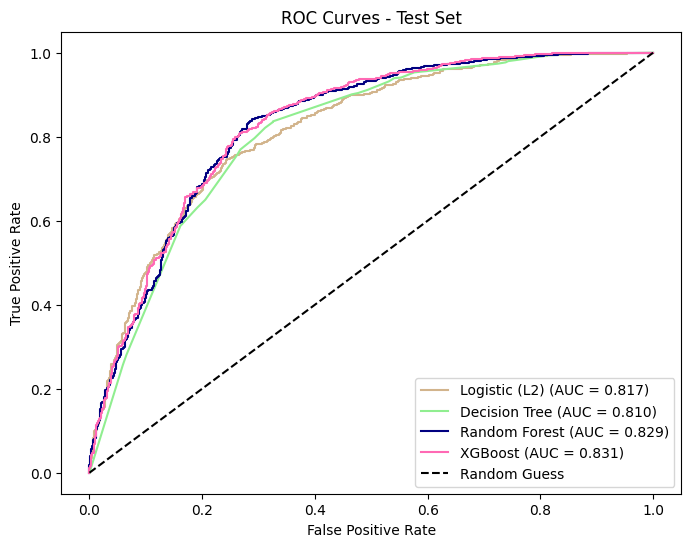

Logistic (L2) AUC:   0.817
Decision Tree AUC:    0.810
Random Forest AUC:    0.829
XGBoost AUC:          0.831


In [28]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for test set
y_test_prob_log = best_log_reg_l2.predict_proba(X_test_scaled)[:, 1]
y_test_prob_dt  = best_dt.predict_proba(X_test_scaled)[:, 1]
y_test_prob_rf  = best_rf.predict_proba(X_test_scaled)[:, 1]
y_test_prob_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_test_prob_log)
fpr_dt,  tpr_dt,  _ = roc_curve(y_test, y_test_prob_dt)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_test_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_prob_xgb)

# Compute AUCs
auc_log = auc(fpr_log, tpr_log)
auc_dt  = auc(fpr_dt,  tpr_dt)
auc_rf  = auc(fpr_rf,  tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color="tan",
         label=f"Logistic (L2) (AUC = {auc_log:.3f})")
plt.plot(fpr_dt, tpr_dt, color="lightgreen",
         label=f"Decision Tree (AUC = {auc_dt:.3f})")
plt.plot(fpr_rf, tpr_rf, color="navy",
         label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, color="hotpink",
         label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Test Set")
plt.legend()
plt.show()

print(f"Logistic (L2) AUC:   {auc_log:.3f}")
print(f"Decision Tree AUC:    {auc_dt:.3f}")
print(f"Random Forest AUC:    {auc_rf:.3f}")
print(f"XGBoost AUC:          {auc_xgb:.3f}")


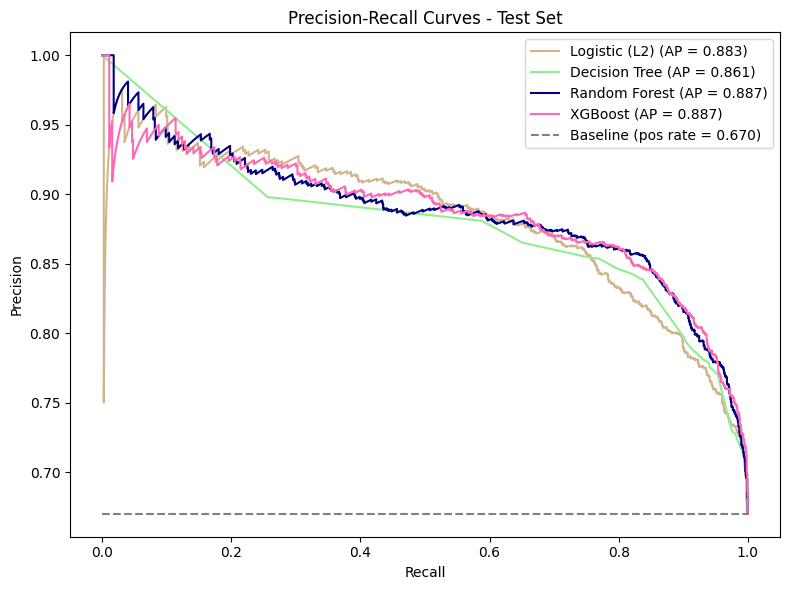

Test PR-AUC (Average Precision):
  Logistic (L2):   0.883
  Decision Tree:    0.861
  Random Forest:    0.887
  XGBoost:          0.887


In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Probabilities on test set (reuse existing)
y_test_prob_log = best_log_reg_l2.predict_proba(X_test_scaled)[:, 1]
y_test_prob_dt  = best_dt.predict_proba(X_test_scaled)[:, 1]
y_test_prob_rf  = best_rf.predict_proba(X_test_scaled)[:, 1]
y_test_prob_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Precision–Recall points
prec_log, recall_log, _ = precision_recall_curve(y_test, y_test_prob_log)
prec_dt,  recall_dt,  _ = precision_recall_curve(y_test, y_test_prob_dt)
prec_rf,  recall_rf,  _ = precision_recall_curve(y_test, y_test_prob_rf)
prec_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_prob_xgb)

# PR-AUC (average precision)
ap_log = average_precision_score(y_test, y_test_prob_log)
ap_dt  = average_precision_score(y_test, y_test_prob_dt)
ap_rf  = average_precision_score(y_test, y_test_prob_rf)
ap_xgb = average_precision_score(y_test, y_test_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(recall_log, prec_log, color="tan",
         label=f"Logistic (L2) (AP = {ap_log:.3f})")
plt.plot(recall_dt, prec_dt, color="lightgreen",
         label=f"Decision Tree (AP = {ap_dt:.3f})")
plt.plot(recall_rf, prec_rf, color="navy",
         label=f"Random Forest (AP = {ap_rf:.3f})")
plt.plot(recall_xgb, prec_xgb, color="hotpink",
         label=f"XGBoost (AP = {ap_xgb:.3f})")

baseline = y_test.mean()
plt.hlines(baseline, 0, 1, colors="gray", linestyles="dashed",
           label=f"Baseline (pos rate = {baseline:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves - Test Set")
plt.legend()
plt.tight_layout()
plt.show()

print("Test PR-AUC (Average Precision):")
print(f"  Logistic (L2):   {ap_log:.3f}")
print(f"  Decision Tree:    {ap_dt:.3f}")
print(f"  Random Forest:    {ap_rf:.3f}")
print(f"  XGBoost:          {ap_xgb:.3f}")


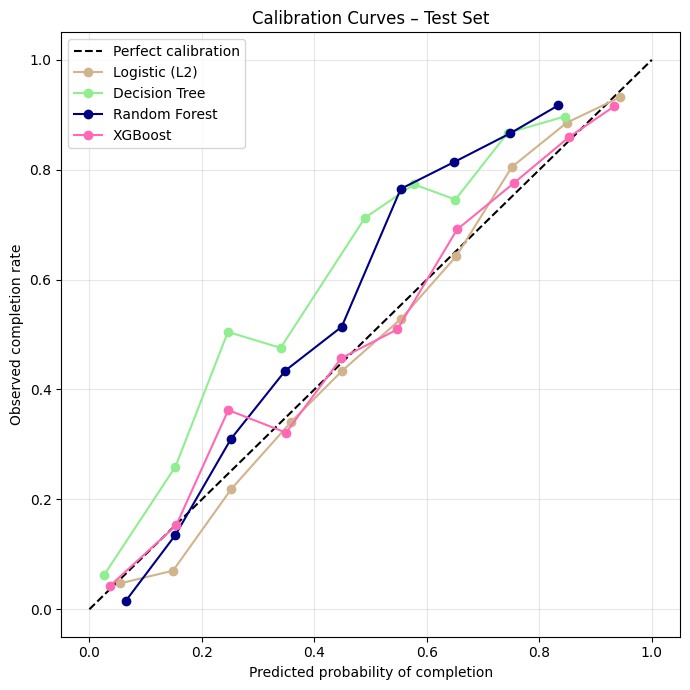

In [30]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Probabilities on test set (reuse from before)
y_test_prob_log = best_log_reg_l2.predict_proba(X_test_scaled)[:, 1]
y_test_prob_dt  = best_dt.predict_proba(X_test_scaled)[:, 1]
y_test_prob_rf  = best_rf.predict_proba(X_test_scaled)[:, 1]
y_test_prob_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Compute calibration curves (prob_pred vs true fraction)
prob_true_log, prob_pred_log = calibration_curve(y_test, y_test_prob_log, n_bins=10)
prob_true_dt,  prob_pred_dt  = calibration_curve(y_test, y_test_prob_dt,  n_bins=10)
prob_true_rf,  prob_pred_rf  = calibration_curve(y_test, y_test_prob_rf,  n_bins=10)
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_test_prob_xgb, n_bins=10)

plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")

plt.plot(prob_pred_log, prob_true_log, marker="o", color="tan",
         label="Logistic (L2)")
plt.plot(prob_pred_dt, prob_true_dt, marker="o", color="lightgreen",
         label="Decision Tree")
plt.plot(prob_pred_rf, prob_true_rf, marker="o", color="navy",
         label="Random Forest")
plt.plot(prob_pred_xgb, prob_true_xgb, marker="o", color="hotpink",
         label="XGBoost")

plt.xlabel("Predicted probability of completion")
plt.ylabel("Observed completion rate")
plt.title("Calibration Curves – Test Set")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


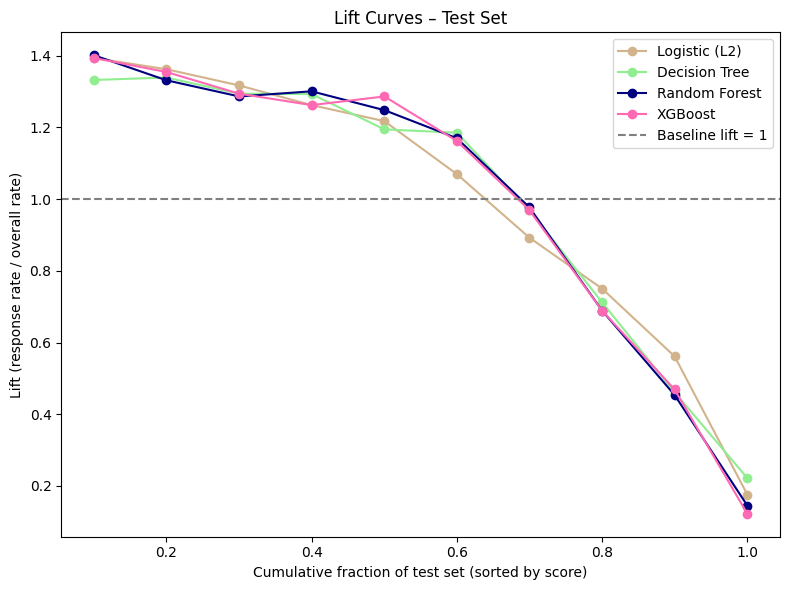

In [31]:
def compute_lift(y_true, y_score, n_bins=10):
    data = pd.DataFrame({"y": y_true, "score": y_score})
    data = data.sort_values("score", ascending=False).reset_index(drop=True)
    data["bin"] = pd.qcut(data.index, q=n_bins, labels=False)

    lifts = []
    percents = []
    overall_rate = data["y"].mean()

    for b in range(n_bins):
        bin_data = data[data["bin"] == b]
        if len(bin_data) == 0:
            continue
        bin_rate = bin_data["y"].mean()
        lift = bin_rate / overall_rate if overall_rate > 0 else np.nan
        perc = (bin_data.index.max() + 1) / len(data)  # cumulative fraction
        lifts.append(lift)
        percents.append(perc)

    return np.array(percents), np.array(lifts)

perc_log, lift_log = compute_lift(y_test, y_test_prob_log, n_bins=10)
perc_dt,  lift_dt  = compute_lift(y_test, y_test_prob_dt,  n_bins=10)
perc_rf,  lift_rf  = compute_lift(y_test, y_test_prob_rf,  n_bins=10)
perc_xgb, lift_xgb = compute_lift(y_test, y_test_prob_xgb, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(perc_log, lift_log, marker="o", color="tan",
         label="Logistic (L2)")
plt.plot(perc_dt, lift_dt, marker="o", color="lightgreen",
         label="Decision Tree")
plt.plot(perc_rf, lift_rf, marker="o", color="navy",
         label="Random Forest")
plt.plot(perc_xgb, lift_xgb, marker="o", color="hotpink",
         label="XGBoost")

plt.axhline(1.0, color="gray", linestyle="dashed", label="Baseline lift = 1")
plt.xlabel("Cumulative fraction of test set (sorted by score)")
plt.ylabel("Lift (response rate / overall rate)")
plt.title("Lift Curves – Test Set")
plt.legend()
plt.tight_layout()
plt.show()


# Look into How Catch Probability Changes Across Different Coverages (Baseline)

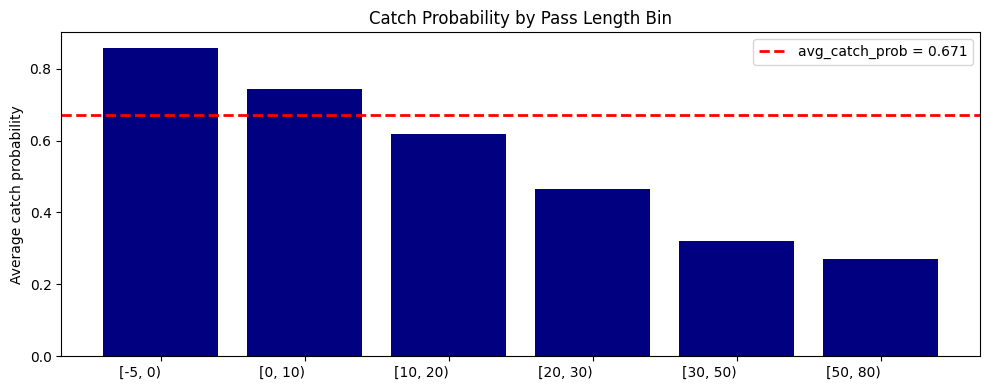

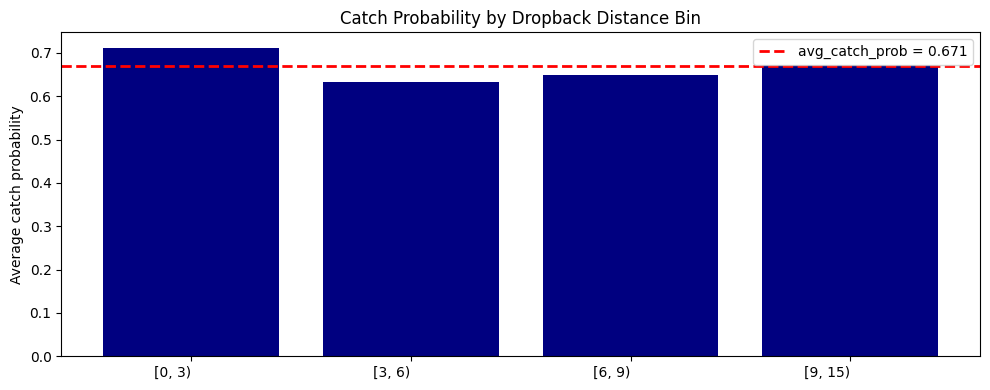

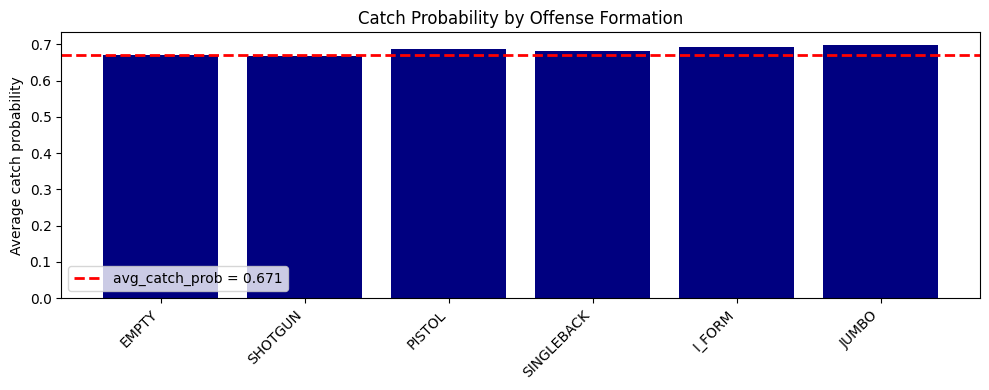

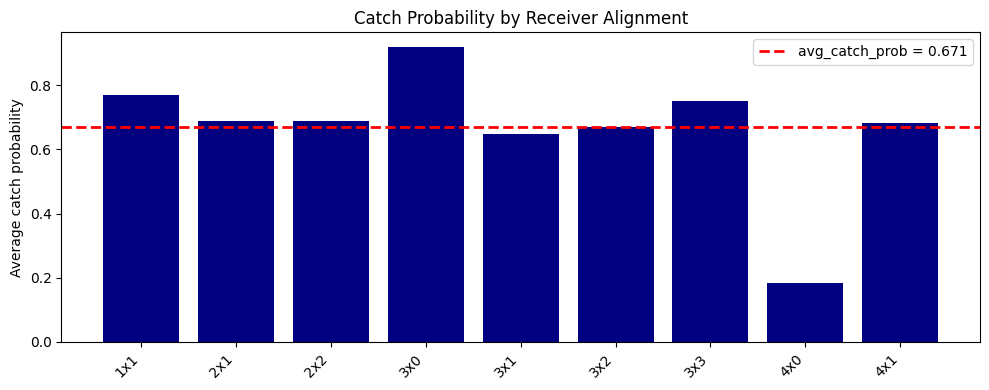

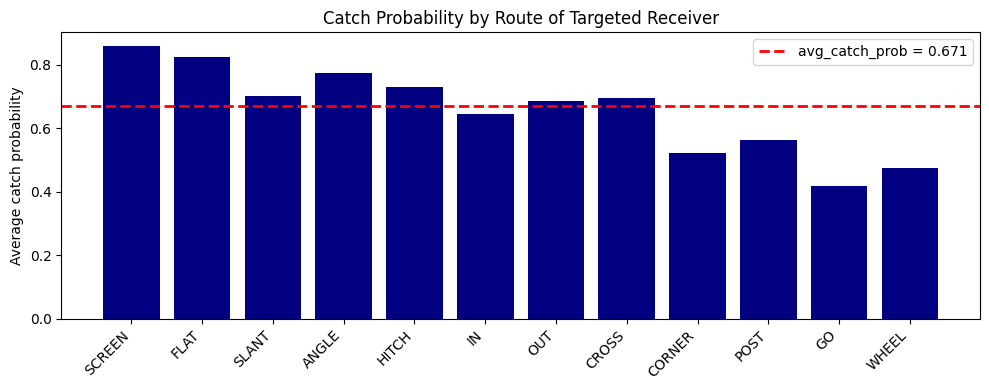

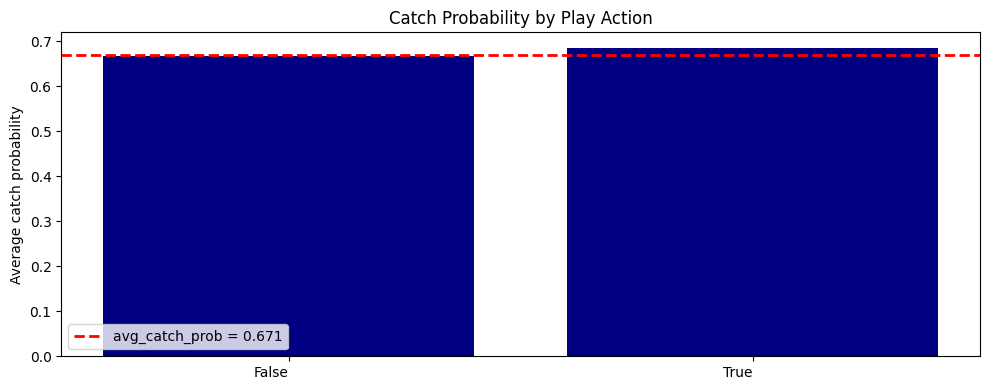

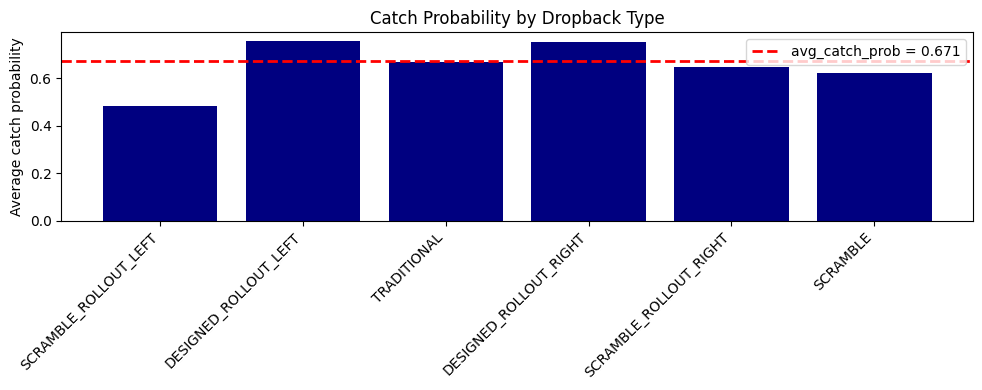

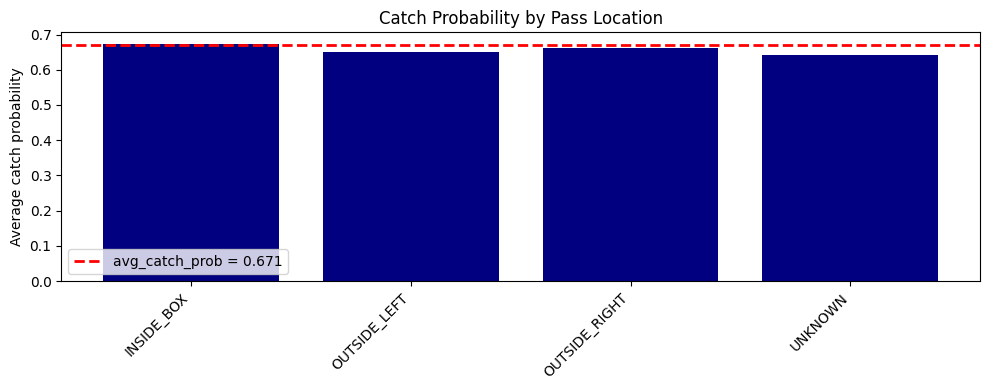

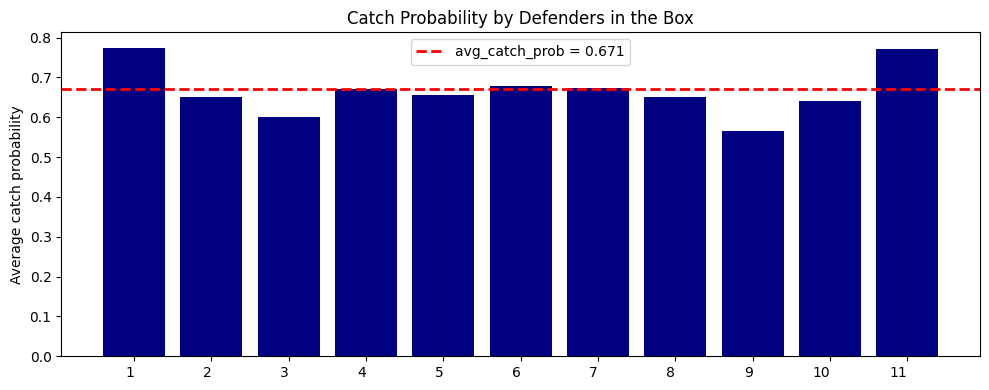

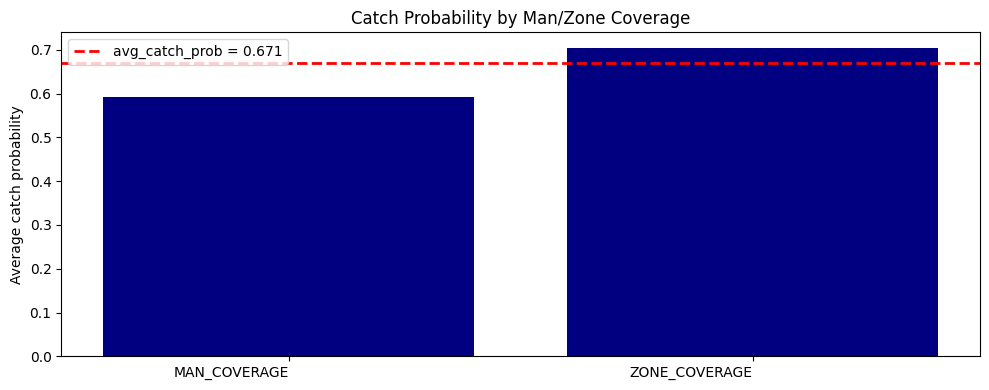

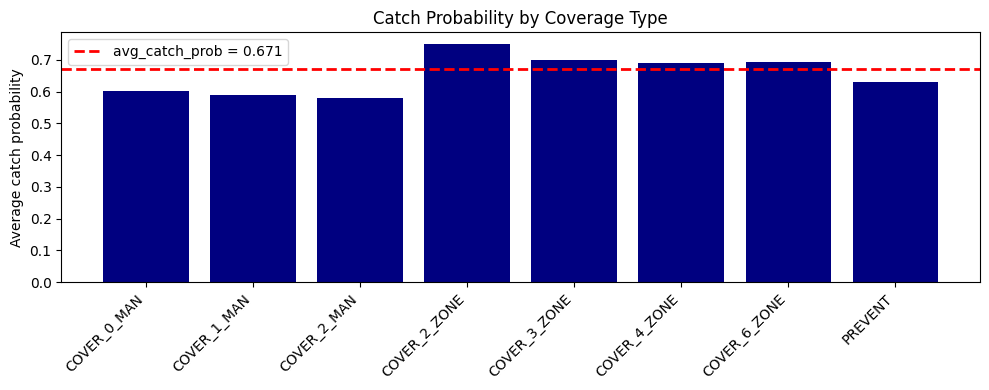

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1. Merge probabilities from arrival_df_with_probs onto sup ----------

# One row per play with catch_probability
arrival_play_probs = (
    arrival_df_with_probs
    .drop_duplicates(subset=["game_id", "play_id"])
    [["game_id", "play_id", "catch_probability"]]
)

# Merge with sup
sup_with_probs = sup.merge(
    arrival_play_probs,
    on=["game_id", "play_id"],
    how="inner"
)

# Treat defenders_in_the_box as categorical
sup_with_probs["defenders_in_the_box"] = (
    sup_with_probs["defenders_in_the_box"].astype("category")
)

# ---------- 2. Create bins for numeric variables ----------

sup_with_probs["pass_length_bin"] = pd.cut(
    sup_with_probs["pass_length"],
    bins=[-5, 0, 10, 20, 30, 50, 80],
    right=False,
    include_lowest=True,
)

sup_with_probs["dropback_distance_bin"] = pd.cut(
    sup_with_probs["dropback_distance"],
    bins=[-5, 0, 3, 6, 9, 15],
    right=False,
    include_lowest=True,
)

# overall benchmark
overall_avg_catch_prob = sup_with_probs["catch_probability"].mean()

def plot_column(df, x_col, y_col, title, rotation=45):
    plt.figure(figsize=(10, 4))
    plt.bar(df[x_col].astype(str), df[y_col], color="navy")
    plt.axhline(
        overall_avg_catch_prob,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"avg_catch_prob = {overall_avg_catch_prob:.3f}",
    )
    plt.xticks(rotation=rotation, ha="right")
    plt.ylabel("Average catch probability")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- numeric (binned) variables ----------
pass_length_summary = (
    sup_with_probs.groupby("pass_length_bin")["catch_probability"]
    .mean().reset_index()
    .rename(columns={"catch_probability": "avg_catch_probability"})
    .sort_values("pass_length_bin")   # short -> deep
)

dropback_distance_summary = (
    sup_with_probs.groupby("dropback_distance_bin")["catch_probability"]
    .mean().reset_index()
    .rename(columns={"catch_probability": "avg_catch_probability"})
    .sort_values("dropback_distance_bin")
)

plot_column(
    pass_length_summary,
    "pass_length_bin",
    "avg_catch_probability",
    "Catch Probability by Pass Length Bin",
    rotation=0,
)

plot_column(
    dropback_distance_summary,
    "dropback_distance_bin",
    "avg_catch_probability",
    "Catch Probability by Dropback Distance Bin",
    rotation=0,
)

# ---------- categorical variables with custom orders ----------

# offense_formation: empty → shotgun/pistol → singleback → I‑form → jumbo
offense_order = ["EMPTY", "SHOTGUN", "PISTOL", "SINGLEBACK", "I_FORM", "JUMBO"]
offense_summary = (
    sup_with_probs.groupby("offense_formation")["catch_probability"]
    .mean().reset_index()
    .rename(columns={"catch_probability": "avg_catch_probability"})
)
offense_summary["offense_formation"] = pd.Categorical(
    offense_summary["offense_formation"], categories=offense_order, ordered=True
)
offense_summary = offense_summary.sort_values("offense_formation")
plot_column(
    offense_summary,
    "offense_formation",
    "avg_catch_probability",
    "Catch Probability by Offense Formation",
)

# receiver_alignment: fewer eligibles / condensed → more spread
receiver_order = ["1x1", "2x1", "2x2", "3x0", "3x1", "3x2", "3x3", "4x0", "4x1"]
receiver_summary = (
    sup_with_probs.groupby("receiver_alignment")["catch_probability"]
    .mean().reset_index()
    .rename(columns={"catch_probability": "avg_catch_probability"})
)
receiver_summary["receiver_alignment"] = pd.Categorical(
    receiver_summary["receiver_alignment"], categories=receiver_order, ordered=True
)
receiver_summary = receiver_summary.sort_values("receiver_alignment")
plot_column(
    receiver_summary,
    "receiver_alignment",
    "avg_catch_probability",
    "Catch Probability by Receiver Alignment",
)

# route_of_targeted_receiver: short → intermediate → deep
route_order = [
    "SCREEN", "FLAT", "SLANT", "ANGLE", "HITCH",
    "IN", "OUT", "CROSS",
    "CORNER", "POST", "GO", "WHEEL",
]
route_summary = (
    sup_with_probs.groupby("route_of_targeted_receiver")["catch_probability"]
    .mean().reset_index()
    .rename(columns={"catch_probability": "avg_catch_probability"})
)
route_summary["route_of_targeted_receiver"] = pd.Categorical(
    route_summary["route_of_targeted_receiver"],
    categories=route_order,
    ordered=True,
)
route_summary = route_summary.sort_values("route_of_targeted_receiver")
plot_column(
    route_summary,
    "route_of_targeted_receiver",
    "avg_catch_probability",
    "Catch Probability by Route of Targeted Receiver",
)

# play_action: False → True
play_action_order = [False, True]
play_action_summary = (
    sup_with_probs.groupby("play_action")["catch_probability"]
    .mean().reset_index()
    .rename(columns={"catch_probability": "avg_catch_probability"})
)
play_action_summary["play_action"] = pd.Categorical(
    play_action_summary["play_action"],
    categories=play_action_order,
    ordered=True,
)
play_action_summary = play_action_summary.sort_values("play_action")
plot_column(
    play_action_summary,
    "play_action",
    "avg_catch_probability",
    "Catch Probability by Play Action",
    rotation=0,
)

# dropback_type: traditional pocket → designed rollouts → scrambles
dropback_type_order = [
    "SCRAMBLE_ROLLOUT_LEFT",
    "DESIGNED_ROLLOUT_LEFT",
    "TRADITIONAL",
    "DESIGNED_ROLLOUT_RIGHT",
    "SCRAMBLE_ROLLOUT_RIGHT",
    "SCRAMBLE",

]
dropback_type_summary = (
    sup_with_probs.groupby("dropback_type")["catch_probability"]
    .mean().reset_index()
    .rename(columns={"catch_probability": "avg_catch_probability"})
)
dropback_type_summary["dropback_type"] = pd.Categorical(
    dropback_type_summary["dropback_type"],
    categories=dropback_type_order,
    ordered=True,
)
dropback_type_summary = dropback_type_summary.sort_values("dropback_type")
plot_column(
    dropback_type_summary,
    "dropback_type",
    "avg_catch_probability",
    "Catch Probability by Dropback Type",
)

# pass_location_type: inside box → outside left → outside right → unknown
pass_loc_order = ["INSIDE_BOX", "OUTSIDE_LEFT", "OUTSIDE_RIGHT", "UNKNOWN"]
pass_loc_summary = (
    sup_with_probs.groupby("pass_location_type")["catch_probability"]
    .mean().reset_index()
    .rename(columns={"catch_probability": "avg_catch_probability"})
)
pass_loc_summary["pass_location_type"] = pd.Categorical(
    pass_loc_summary["pass_location_type"],
    categories=pass_loc_order,
    ordered=True,
)
pass_loc_summary = pass_loc_summary.sort_values("pass_location_type")
plot_column(
    pass_loc_summary,
    "pass_location_type",
    "avg_catch_probability",
    "Catch Probability by Pass Location",
)

# defenders_in_the_box: numeric ascending
def_box_summary = (
    sup_with_probs.groupby("defenders_in_the_box")["catch_probability"]
    .mean().reset_index()
    .rename(columns={"catch_probability": "avg_catch_probability"})
    .sort_values("defenders_in_the_box")
)
plot_column(
    def_box_summary,
    "defenders_in_the_box",
    "avg_catch_probability",
    "Catch Probability by Defenders in the Box",
    rotation=0,
)

# team_coverage_man_zone: man → zone
coverage_mz_order = ["MAN_COVERAGE", "ZONE_COVERAGE"]
coverage_mz_summary = (
    sup_with_probs.groupby("team_coverage_man_zone")["catch_probability"]
    .mean().reset_index()
    .rename(columns={"catch_probability": "avg_catch_probability"})
)
coverage_mz_summary["team_coverage_man_zone"] = pd.Categorical(
    coverage_mz_summary["team_coverage_man_zone"],
    categories=coverage_mz_order,
    ordered=True,
)
coverage_mz_summary = coverage_mz_summary.sort_values("team_coverage_man_zone")
plot_column(
    coverage_mz_summary,
    "team_coverage_man_zone",
    "avg_catch_probability",
    "Catch Probability by Man/Zone Coverage",
    rotation=0,
)

# team_coverage_type: man coverages (0,1,2) → zone shells (2,3,4,6) → prevent
coverage_type_order = [
    "COVER_0_MAN",
    "COVER_1_MAN",
    "COVER_2_MAN",
    "COVER_2_ZONE",
    "COVER_3_ZONE",
    "COVER_4_ZONE",
    "COVER_6_ZONE",
    "PREVENT",
]
coverage_type_summary = (
    sup_with_probs.groupby("team_coverage_type")["catch_probability"]
    .mean().reset_index()
    .rename(columns={"catch_probability": "avg_catch_probability"})
)
coverage_type_summary["team_coverage_type"] = pd.Categorical(
    coverage_type_summary["team_coverage_type"],
    categories=coverage_type_order,
    ordered=True,
)
coverage_type_summary = coverage_type_summary.sort_values("team_coverage_type")
plot_column(
    coverage_type_summary,
    "team_coverage_type",
    "avg_catch_probability",
    "Catch Probability by Coverage Type",
)


# Calculate Metrics

## Velocity, Acceleration, and Direction of Defender

In [33]:

# ============================================================
# COMBINED INPUT + OUTPUT.. get all defenders
# ============================================================

combined = pd.concat(
    [
        train_input.assign(source="input"),
        train_output.assign(source="output")
    ],
    ignore_index=True
)

combined["def_nfl_id"] = np.where(
    combined["player_side"] == "Defense",
    combined["nfl_id"],
    np.nan
)

combined_time = combined[[
    "game_id", "play_id", "nfl_id", "def_nfl_id",
    "frame_id", "source",
    "x", "y",
    "time_since_throw", "time_in_air", "time_to_arrival",
    "is_complete",
    "player_side", "player_role", "player_name"
]]

In [34]:
combined.shape

(5443515, 31)

In [35]:
# ============================================================
# DEFENDER KINEMATICS & REACTION (ON final_frame_level_df)
# ============================================================
import numpy as np

# ------------------------------------------------------------
# 1) Build full receiver–defender table (wr_db_full)
# ------------------------------------------------------------
# We start from final_frame_level_df (targeted receiver frames, pre + post throw)
# and join in defender positions frame-by-frame.

# A. All targeted‑receiver frames (pre + post throw)
tr_all = final_frame_level_df.copy()

# B. All defender frames (pre + post throw) from combined
#    specifically focus on coverage players to avoid DL noise
def_all = combined[combined["player_role"] == "Defensive Coverage"].copy()

# Rename defender columns for clarity and to avoid collisions on merge
def_all = def_all.rename(
    columns={
        "x": "def_x",
        "y": "def_y",
        "player_side": "def_side",
        "player_role": "def_role",
        "player_name": "def_name",
    }
)

# C. Join receivers with defenders on same game/play/frame
#    This gives one row per (game, play, frame, targeted receiver, defender)
wr_db_full = tr_all.merge(
    def_all[[
        "game_id", "play_id", "frame_id", "source",   # <-- keep defender's source
        "def_nfl_id", "def_x", "def_y", "def_name"
    ]],
    on=["game_id", "play_id", "frame_id", "source"],  # <-- include source in join key
    how="left",
)


# Receiver–defender distance for each defender at each frame (pre + post throw)
wr_db_full["dist_wr_db"] = np.sqrt(
    (wr_db_full["x"] - wr_db_full["def_x"]) ** 2
    + (wr_db_full["y"] - wr_db_full["def_y"]) ** 2
)

In [36]:
# ------------------------------------------------------------
# 2) Kinematics and projection onto defender→receiver line
# ------------------------------------------------------------

FRAME_DURATION = 0.1  # seconds per frame (tracking is 10 Hz)

# Copy the receiver–defender join table so we can engineer reaction features
wr_db_rt = wr_db_full.copy()  # uses full tracking, not just post‑throw

# Order rows so that, for each defender's trajectory within a play, frames are in time order
wr_db_rt = wr_db_rt.sort_values(  # this is important so that the .diff() function can work properly and get the right differential
    ["game_id", "play_id", "def_nfl_id", "source", "frame_id"]
)

# -------------------------------------------------------------------
# Compute defender velocity (first derivative of position over time)
# -------------------------------------------------------------------

# Horizontal velocity of defender: change in x per frame divided by frame duration
wr_db_rt["def_vx"] = wr_db_rt.groupby(
    ["game_id", "play_id", "def_nfl_id"]
)["def_x"].diff() / FRAME_DURATION  # change in position divided by time = velocity (yards / second)

# Vertical velocity of defender: change in y per frame divided by frame duration
wr_db_rt["def_vy"] = wr_db_rt.groupby(
    ["game_id", "play_id", "def_nfl_id"]
)["def_y"].diff() / FRAME_DURATION  # change in position divided by time = velocity (yards / second)

# Defender speed magnitude from velocity components
wr_db_rt["def_speed"] = np.sqrt(
    wr_db_rt["def_vx"]**2 + wr_db_rt["def_vy"]**2  # use pythagorean thm to find the magnitude of the hypotnuse...
    # I know the player moves at __ magnitude in the x direction and __ magnitude
    # in the y direction, so we can calculate speed
)

# -------------------------------------------------------------------
# Compute defender acceleration (second derivative of position)
# -------------------------------------------------------------------

# Horizontal acceleration (accel in x direction): change in vx per frame divided by frame duration
wr_db_rt["def_ax"] = wr_db_rt.groupby(
    ["game_id", "play_id", "def_nfl_id"]
)["def_vx"].diff() / FRAME_DURATION  # change in velocity divided by time = acceleration (yards / second^2)

# Vertical acceleration (accel in y direction): change in vy per frame divided by frame duration
wr_db_rt["def_ay"] = wr_db_rt.groupby(
    ["game_id", "play_id", "def_nfl_id"]
)["def_vy"].diff() / FRAME_DURATION  # change in velocity divided by time = acceleration (yards / second^2)

# Defender total acceleration magnitude from components
wr_db_rt["def_accel"] = np.sqrt(
    wr_db_rt["def_ax"]**2 + wr_db_rt["def_ay"]**2  # pythag thm.
)

# Vector from defender to receiver
wr_db_rt["vec_dx"] = wr_db_rt["x"] - wr_db_rt["def_x"]
wr_db_rt["vec_dy"] = wr_db_rt["y"] - wr_db_rt["def_y"]

# Length of that vector (defender–receiver distance)
vec_norm = np.sqrt(wr_db_rt["vec_dx"]**2 + wr_db_rt["vec_dy"]**2)

# Unit vector u in the defender→receiver direction
# u = v / ||v||, where v = (vec_dx, vec_dy)
wr_db_rt["u_dx"] = wr_db_rt["vec_dx"] / vec_norm
wr_db_rt["u_dy"] = wr_db_rt["vec_dy"] / vec_norm

# Projection of defender acceleration vector a onto the defender→receiver line:
# proj_u(a) = ((a · u) / ||u||^2) u. Since u is a unit vector (||u|| = 1),
# this simplifies to a · u, which is the *signed scalar* component of a
# along the defender→receiver direction:
#   accel_along_line = a · u = a_x * u_x + a_y * u_y.
# Positive → accelerating toward the receiver; negative → accelerating away.
wr_db_rt["accel_along_line"] = (
    wr_db_rt["def_ax"] * wr_db_rt["u_dx"] +
    wr_db_rt["def_ay"] * wr_db_rt["u_dy"]
)


## Calculate When Reaction Occurs 
- Boolean conditions for "Reaction" based off movements
- Reaction Time calculated

In [37]:

# ------------------------------------------------------------
# 3) "Reaction" based on sustained closing + accel
# ------------------------------------------------------------

K = 5  # need 5 consecutive frames of closing (~0.5 seconds at 10 Hz)

# 1) Defender–receiver distance starts a sustained decrease:
# Frame-to-frame change in defender–receiver distance
wr_db_rt["delta_dist_wr"] = wr_db_rt.groupby(
    ["game_id", "play_id", "def_nfl_id"]
)["dist_wr_db"].diff()

# Boolean per frame: did distance decrease on this frame?
wr_db_rt["closing_one_frame"] = wr_db_rt["delta_dist_wr"] < 0

def count_streak(s):
    # s is a 1D array-like of booleans for a single defender trajectory
    streak = 0
    out = []
    for val in s:
        if val:
            streak += 1
        else:
            streak = 0
        out.append(streak)
    return out  # transform will put this back on the same index

# Count consecutive closing frames within each defender trajectory
wr_db_rt["closing_streak"] = (
    wr_db_rt.groupby(["game_id", "play_id", "def_nfl_id"])["closing_one_frame"]
    .transform(count_streak)
)

# True only when we have at least K consecutive closing frames
wr_db_rt["closing_K"] = wr_db_rt["closing_streak"] >= K

# 2) Defender acceleration magnitude exceeds global post-throw average (3.72)
ACCEL_THR = 3.72
wr_db_rt["accel_big_enough"] = wr_db_rt["def_accel"] >= ACCEL_THR

# A frame is labeled as a "reaction" frame if:
#   - defender–receiver distance has just started a sustained decrease (K frames),
#   - acceleration magnitude is above the global average threshold.
wr_db_rt["reaction_flag"] = (
    wr_db_rt["closing_K"] & wr_db_rt["accel_big_enough"]
)

# For each defender on each play, pick the FIRST frame where reaction_flag is true.
# This gives "time_since_throw" at the moment we say the defender "reacted".
# Note: time_since_throw can be negative here (pre‑throw reaction).
defender_first_react = (
    wr_db_rt[wr_db_rt["reaction_flag"]]
    .groupby(["game_id", "play_id", "def_nfl_id"], as_index=False)
    ["time_since_throw"]
    .min()
    .rename(columns={
        "def_nfl_id": "nfl_id_react",
        "time_since_throw": "defender_reaction_time"
    })
)


In [38]:
wr_db_rt[wr_db_rt.is_complete == 1].iloc[20:60]

game_id  play_id  nfl_id     x     y  ball_land_x  ball_land_y  \
270      2023090700      194   41325 93.60 26.02        84.94        21.75   
277      2023090700      194   41325 93.38 25.66        84.94        21.75   
284      2023090700      194   41325 93.11 25.28        84.94        21.75   
291      2023090700      194   41325 92.78 24.90        84.94        21.75   
298      2023090700      194   41325 92.42 24.51        84.94        21.75   
305      2023090700      194   41325 92.01 24.13        84.94        21.75   
312      2023090700      194   41325 91.57 23.75        84.94        21.75   
319      2023090700      194   41325 91.09 23.41        84.94        21.75   
326      2023090700      194   41325 90.59 23.08        84.94        21.75   
333      2023090700      194   41325 90.07 22.77        84.94        21.75   
340      2023090700      194   41325 89.53 22.49        84.94        21.75   
347      2023090700      194   41325 88.98 22.23        84.94        21.75   
2661389  2023090700      194   41325 88.43 21.99        84.94        21.75   
2661393  2023090700      194   41325 87.88 21.76        84.94        21.75   
2661397  2023090700      194   41325 87.33 21.56        84.94        21.75   
2661401  2023090700      194   41325 86.78 21.38        84.94        21.75   
2661405  2023090700      194   41325 86.23 21.22        84.94        21.75   
2661409  2023090700      194   41325 85.69 21.08        84.94        21.75   
2661413  2023090700      194   41325 85.15 20.95        84.94        21.75   
2661417  2023090700      194   41325 84.61 20.82        84.94        21.75   
2661421  2023090700      194   41325 84.06 20.70        84.94        21.75   
133      2023090700      194   41325 93.33 27.85        84.94        21.75   
140      2023090700      194   41325 93.33 27.86        84.94        21.75   
147      2023090700      194   41325 93.33 27.86        84.94        21.75   
154      2023090700      194   41325 93.33 27.86        84.94        21.75   
161      2023090700      194   41325 93.33 27.88        84.94        21.75   
168      2023090700      194   41325 93.35 27.89        84.94        21.75   
175      2023090700      194   41325 93.38 27.91        84.94        21.75   
182      2023090700      194   41325 93.42 27.93        84.94        21.75   
189      2023090700      194   41325 93.48 27.93        84.94        21.75   
196      2023090700      194   41325 93.55 27.91        84.94        21.75   
203      2023090700      194   41325 93.63 27.89        84.94        21.75   
210      2023090700      194   41325 93.71 27.85        84.94        21.75   
217      2023090700      194   41325 93.80 27.77        84.94        21.75   
224      2023090700      194   41325 93.87 27.67        84.94        21.75   
231      2023090700      194   41325 93.93 27.55        84.94        21.75   
238      2023090700      194   41325 93.97 27.39        84.94        21.75   
245      2023090700      194   41325 93.98 27.18        84.94        21.75   
252      2023090700      194   41325 93.95 26.94        84.94        21.75   
259      2023090700      194   41325 93.88 26.67        84.94        21.75   

        ball_y_bucket ball_x_bucket  time_since_throw  time_in_air  \
270            middle        80-120             -1.10         0.90   
277            middle        80-120             -1.00         0.90   
284            middle        80-120             -0.90         0.90   
291            middle        80-120             -0.80         0.90   
298            middle        80-120             -0.70         0.90   
305            middle        80-120             -0.60         0.90   
312            middle        80-120             -0.50         0.90   
319            middle        80-120             -0.40         0.90   
326            middle        80-120             -0.30         0.90   
333            middle        80-120             -0.20         0.90   
340            middle        80-120        

# Reaction Times by Player 

## See Charts

In [39]:
# ------------------------------------------------------------
# Reaction Times by Player
# ------------------------------------------------------------

# Count per id on the raw df
defender_first_react["nfl_id_react_count"] = (
    defender_first_react.groupby("nfl_id_react")["nfl_id_react"]
        .transform("size")      # or .transform('count')
)

# 1) Mean reaction time per defender + keep count, sorted by id
reactions_ranked_player = (
    defender_first_react
        .groupby("nfl_id_react", as_index=False)
        .agg({
            "defender_reaction_time": "mean",
            "nfl_id_react_count": "first"   # same within each group
        })
        .sort_values("nfl_id_react", ascending=True)
)

# 2) Deduplicate keys on both sides
reactions_ranked_player_unique = reactions_ranked_player.drop_duplicates(
    subset=["nfl_id_react"]
)
wr_db_rt_unique = wr_db_rt.drop_duplicates(subset=["def_nfl_id"])

# 3) Merge on unique keys (keeps nfl_id_react_count)
reactions_ranked_player_names = reactions_ranked_player_unique.merge(
    wr_db_rt_unique[["def_name", "def_nfl_id"]],
    left_on="nfl_id_react",
    right_on="def_nfl_id",
    how="left"
)


In [40]:
defender_first_react

game_id  play_id  nfl_id_react  defender_reaction_time  \
0      2023090700      101      46137.00                   -1.30   
1      2023090700      101      52546.00                   -1.20   
2      2023090700      101      53487.00                   -1.50   
3      2023090700      101      54486.00                   -1.40   
4      2023090700      101      54527.00                   -0.10   
...           ...      ...           ...                     ...   
57504  2024010713     4018      40166.00                   -0.60   
57505  2024010713     4018      46190.00                   -2.10   
57506  2024010713     4018      47844.00                    0.20   
57507  2024010713     4018      52647.00                   -1.50   
57508  2024010713     4018      54650.00                   -2.00   

       nfl_id_react_count  
0                     202  
1                     221  
2                      73  
3                     192  
4                     126  
...                   ...  
57504                 198  
57505                 214  
57506                  89  
57507                 105  
57508                 168  

[57509 rows x 5 columns]

In [41]:
# sort and display by most reactions
reactions_ranked_player_names = reactions_ranked_player_names.sort_values(
    by=["nfl_id_react_count", "defender_reaction_time"],
    ascending=[False, True]
)
reactions_ranked_player_names

nfl_id_react  defender_reaction_time  nfl_id_react_count  \
403      52607.00                   -1.54                 323   
88       43351.00                   -1.47                 313   
472      53554.00                   -1.32                 297   
448      53476.00                   -1.61                 293   
432      53438.00                   -1.46                 291   
..            ...                     ...                 ...   
72       43296.00                    0.20                   1   
660      55918.00                    0.40                   1   
277      47800.00                    0.50                   1   
688      56001.00                    0.70                   1   
522      54497.00                    1.80                   1   

              def_name  def_nfl_id  
403      Jordan Fuller    52607.00  
88     James Bradberry    43351.00  
472       Camryn Bynum    53554.00  
448      Asante Samuel    53476.00  
432     Pat Surtain II    53438.00  
..                 ...         ...  
72    DeForest Buckner    43296.00  
660  Gervon Dexter Sr.    55918.00  
277    Dexter Lawrence    47800.00  
688     Yasir Abdullah    56001.00  
522         Lewis Cine    54497.00  

[755 rows x 5 columns]

In [42]:
# defender average reaction times... fastest 5 reactors vs slowest 5 reactors (min 30 reactions)... could plot this!
reactions_ranked_player_names_min = reactions_ranked_player_names[reactions_ranked_player_names["nfl_id_react_count"] >= 30
                                        ].sort_values(by="defender_reaction_time", ascending=True)

reactions_ranked_player_names_min

nfl_id_react  defender_reaction_time  nfl_id_react_count  \
345      48780.00                   -2.01                  38   
16       38707.00                   -2.01                  40   
553      54568.00                   -1.98                  52   
434      53445.00                   -1.88                  38   
584      54687.00                   -1.87                 138   
..            ...                     ...                 ...   
143      44862.00                   -1.06                  73   
109      43474.00                   -1.01                  91   
194      46097.00                   -1.01                 132   
488      53609.00                   -0.99                 152   
248      46501.00                   -0.86                  35   

                   def_name  def_nfl_id  
345             Troy Reeder    48780.00  
16            Justin Bethel    38707.00  
553              Leo Chenal    54568.00  
434           Zaven Collins    53445.00  
584          Montaric Brown    54687.00  
..                      ...         ...  
143            Justin Evans    44862.00  
109  DeAndre Houston-Carson    43474.00  
194         Terrell Edmunds    46097.00  
488         Talanoa Hufanga    53609.00  
248         Elijah Campbell    46501.00  

[387 rows x 5 columns]

In [43]:
print('Average Reaction Time In the Data Across All Coverage Players: ' + str(round(reactions_ranked_player_names_min.defender_reaction_time.mean(), 2)) + ' seconds.')

Average Reaction Time In the Data Across All Coverage Players: -1.46 seconds.


## Add Reaction Time Metric Back into Original Data

In [44]:
# ============================================================
# MERGE REACTION TIME ONTO FRAME-LEVEL DATA
# ============================================================

# defender_first_react has one row per (game_id, play_id, def_nfl_id)
# with defender_reaction_time in seconds

# 1) For each receiver frame, find the nearest defender (already in min_dist_defender)
#    and attach that defender's id so we can join reaction time

# We already have wr_db_full with one row per receiver–defender pair
# and dist_wr_db (distance between WR and each defender)
nearest_defender_per_frame = (
    wr_db_full.dropna(subset=["def_nfl_id"])  # keep frames where a defender exists
    .sort_values(["game_id", "play_id", "nfl_id", "frame_id", "dist_wr_db"])
    .groupby(["game_id", "play_id", "nfl_id", "frame_id"], as_index=False)
    .first()[["game_id", "play_id", "nfl_id", "frame_id", "def_nfl_id"]]
)

# 2) Merge nearest defender id onto final_frame_level_df
final_with_def = final_frame_level_df.merge(
    nearest_defender_per_frame,
    on=["game_id", "play_id", "nfl_id", "frame_id"],
    how="left"
)

# 3) Merge reaction time for that defender/play onto the frame-level table
final_with_reaction = final_with_def.merge(
    defender_first_react,  # columns: game_id, play_id, nfl_id_react, defender_reaction_time
    left_on=["game_id", "play_id", "def_nfl_id"],
    right_on=["game_id", "play_id", "nfl_id_react"],
    how="left"
)

# 4) Drop helper key and keep a clean reaction_time column
final_with_reaction = final_with_reaction.drop(columns=["nfl_id_react"])
final_with_reaction = final_with_reaction.rename(
    columns={"defender_reaction_time": "reaction_time"}
)

# This is your updated frame-level dataset:
# one row per receiver frame, with the nearest defender's reaction time on that play
final_with_reaction = final_with_reaction.copy()


In [45]:
final_with_reaction

game_id  play_id  nfl_id     x     y  ball_land_x  ball_land_y  \
0       2023090700      101   44930 41.03 12.17        63.26        -0.22   
1       2023090700      101   44930 41.03 12.17        63.26        -0.22   
2       2023090700      101   44930 41.05 12.18        63.26        -0.22   
3       2023090700      101   44930 41.07 12.20        63.26        -0.22   
4       2023090700      101   44930 41.11 12.22        63.26        -0.22   
...            ...      ...     ...   ...   ...          ...          ...   
556907  2024010713     4018   52457 30.99 10.51        32.14         6.71   
556908  2024010713     4018   52457 30.78  9.73        32.14         6.71   
556909  2024010713     4018   52457 30.63  8.93        32.14         6.71   
556910  2024010713     4018   52457 30.52  8.12        32.14         6.71   
556911  2024010713     4018   52457 30.45  7.30        32.14         6.71   

       ball_y_bucket ball_x_bucket  time_since_throw  time_in_air  \
0               left         40-80             -2.50         2.10   
1               left         40-80             -2.40         2.10   
2               left         40-80             -2.30         2.10   
3               left         40-80             -2.20         2.10   
4               left         40-80             -2.10         2.10   
...              ...           ...               ...          ...   
556907          left          0-40              1.40         1.80   
556908          left          0-40              1.50         1.80   
556909          left          0-40              1.60         1.80   
556910          left          0-40              1.70         1.80   
556911          left          0-40              1.80         1.80   

        time_to_arrival  frame_id  source  dist_receiver_to_ball  \
0                  4.60         1   input                  25.45   
1                  4.50         2   input                  25.45   
2                  4.40         3   input                  25.44   
3                  4.30         4   input                  25.43   
4                  4.20         5   input                  25.40   
...                 ...       ...     ...                    ...   
556907             0.40        14  output                   3.97   
556908             0.30        15  output                   3.31   
556909             0.20        16  output                   2.68   
556910             0.10        17  output                   2.15   
556911             0.00        18  output                   1.79   

        min_dist_defender     player_name  player_height_in  player_weight  \
0                    3.42   Josh Reynolds                75            196   
1                    3.51   Josh Reynolds                75            196   
2                    3.57   Josh Reynolds                75            196   
3                    3.62   Josh Reynolds                75            196   
4                    3.66   Josh Reynolds                75            196   
...                   ...             ...               ...            ...   
556907               1.70  Chase Claypool                76            227   
556908               1.69  Chase Claypool                76            227   
556909               1.67  Chase Claypool                76            227   
556910               1.61  Chase Claypool                76            227   
556911               1.53  Chase Claypool                76            227   

       player_side player_position        player_role  is_complete  \
0          Offense              WR  Targeted Receiver            0   
1          Offense              WR  Targeted Receiver            0   
2          Offense              WR  Targeted Receiver            0   
3          Offense              WR  Targeted Receiver            0   
4          Offense              WR  Targeted Receiver            0   
...            ...             ...                ...          ...   
556907     Of

# PREDICTIVE MODELING (using reaction time)
- Find if reaction time is predictive of incompletions (in further analysis, I could look into predicting interceptions)

In [46]:
import numpy as np
import pandas as pd

# Keep only frames at arrival
arrival_df = final_with_reaction[final_with_reaction["time_to_arrival"] == 0].copy()

# verify we have 1 frame per play:
print(arrival_df.shape)

# check to see how well the data is balanced:
arrival_df["is_complete"].value_counts()

(14102, 28)


is_complete
1    9735
0    4367
Name: count, dtype: int64

## Pipeline #2 (With Validation)... I use this the rest of the way as the main one

### Feature Selection, Train/Validation/Test Split, Scaling

In [47]:
import numpy as np
import pandas as pd

np.random.seed(1)

# Start from arrival-only frame-level data
# arr_df = catch_prob_frame_lvl_df[np.isclose(catch_prob_frame_lvl_df["time_to_arrival"], 0.0)].copy()

# Feature set (numeric + categorical)
features = [
    "x", "y",
    "ball_land_x", "ball_land_y",
    "dist_receiver_to_ball",
    "min_dist_defender",
    "time_in_air",
    "reaction_time",
    "player_height_in",
    "player_weight",
    "player_position",      # categorical
    #"ball_x_bucket",        # categorical (redundant)
    #"ball_y_bucket"         # categorical (redundant)
 ]


# Drop rows with NaNs in features or target (aka rows where min_dist_defender is NaN)
arrival_df = arrival_df.dropna(subset=features + ["is_complete"]).copy()

X = arrival_df[features]
y = arrival_df["is_complete"].astype(int)

# 70% train, 30% temp
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

# 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp
)

print("Does feature have missing data (T/F)?\n")
print(arrival_df[features].isna().any())
print("\nTraining set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Does feature have missing data (T/F)?

x                        False
y                        False
ball_land_x              False
ball_land_y              False
dist_receiver_to_ball    False
min_dist_defender        False
time_in_air              False
reaction_time            False
player_height_in         False
player_weight            False
player_position          False
dtype: bool

Training set size: 8617
Validation set size: 1847
Test set size: 1847


In [48]:
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------
# 1. Separate numeric / categorical
# -------------------------------------------------
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns

print("\nNumerical columns:", list(numerical_cols))
print("Categorical columns:", list(categorical_cols))

# -------------------------------------------------
# 2. Numeric = use as-is (NaNs already dropped)
# -------------------------------------------------
X_train_num = X_train[numerical_cols].copy()
X_val_num = X_val[numerical_cols].copy()
X_test_num = X_test[numerical_cols].copy()

# -------------------------------------------------
# 3. Categorical: get_dummies only (no imputation needed because no data is missing)
# -------------------------------------------------
X_train_cat = pd.get_dummies(X_train[categorical_cols], drop_first=True).astype(int)
X_val_cat = pd.get_dummies(X_val[categorical_cols], drop_first=True).astype(int)
X_test_cat = pd.get_dummies(X_test[categorical_cols], drop_first=True).astype(int)

# Align dummy columns
all_cat_cols = X_train_cat.columns
X_val_cat = X_val_cat.reindex(columns=all_cat_cols, fill_value=0)
X_test_cat = X_test_cat.reindex(columns=all_cat_cols, fill_value=0)

print("\nFinal dummy shapes:")
print("Train:", X_train_cat.shape, "Val:", X_val_cat.shape, "Test:", X_test_cat.shape)

# -------------------------------------------------
# 4. Combine numeric + categorical
# -------------------------------------------------
X_train_combined = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_combined = pd.concat([X_val_num, X_val_cat], axis=1)
X_test_combined = pd.concat([X_test_num, X_test_cat], axis=1)

print("\nCombined shapes:")
print("Train:", X_train_combined.shape,
      "Val:", X_val_combined.shape,
      "Test:", X_test_combined.shape)

# -------------------------------------------------
# 5. Standardize
# -------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)
X_test_scaled = scaler.transform(X_test_combined)

feature_names = X_train_combined.columns


Numerical columns: ['x', 'y', 'ball_land_x', 'ball_land_y', 'dist_receiver_to_ball', 'min_dist_defender', 'time_in_air', 'reaction_time', 'player_height_in', 'player_weight']
Categorical columns: ['player_position']

Final dummy shapes:
Train: (8617, 7) Val: (1847, 7) Test: (1847, 7)

Combined shapes:
Train: (8617, 17) Val: (1847, 17) Test: (1847, 17)


### Check for multi-collinearity that may throw off interpretations

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# -------------------------------------------------
# Multicollinearity check: Variance Inflation Factor
# -------------------------------------------------

# VIF expects a 2D array; use the combined (numeric + dummies) design matrix
X_vif = X_train_combined.copy()

vif_data = pd.DataFrame({
    "Feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
})

# Sort by VIF descending to see most collinear features first
vif_data = vif_data.sort_values("VIF", ascending=False)
print("\nVariance Inflation Factors (top 20):")
vif_data.head(20)


Variance Inflation Factors (top 20):


Feature     VIF
0                       x 1354.67
2             ball_land_x 1352.91
8        player_height_in  839.44
3             ball_land_y  442.33
1                       y  437.20
9           player_weight  341.40
16     player_position_WR  260.49
15     player_position_TE   95.87
13     player_position_RB   44.07
6             time_in_air    6.99
7           reaction_time    2.97
5       min_dist_defender    2.91
11     player_position_FB    2.67
4   dist_receiver_to_ball    2.02
12     player_position_QB    1.79
14      player_position_T    1.06
10     player_position_DT    1.05

### Logistic Regression
- Finding: lower reaction time is associated with lower completion percentage

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import warnings

# Hide all warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

log_reg_l1 = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    max_iter=1000,
    random_state=1
)

param_grid = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

# ------------------------------------------------------------------
# manual tuning on the validation set (instead of GridSearchCV)
# ------------------------------------------------------------------
best_log_reg_l1 = None
best_C = None
best_val_auc = -np.inf

for C in param_grid["C"]:
    model = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=1000,
        random_state=1,
        C=C
    )
    model.fit(X_train_scaled, y_train)
    y_val_prob_tmp = model.predict_proba(X_val_scaled)[:, 1]
    val_auc_tmp = roc_auc_score(y_val, y_val_prob_tmp)

    if val_auc_tmp > best_val_auc:
        best_val_auc = val_auc_tmp
        best_log_reg_l1 = model
        best_C = C
# ---------------------------------------------------------
# END of tuning
# ---------------------------------------------------------
print("Tuning hyperparameters on validation set (L1)...")
print("Best C (val-tuned):", best_C)
print("Best Validation AUC-ROC:", best_val_auc)

# -------------------- TEST set here -------------------
y_test_pred_l1 = best_log_reg_l1.predict(X_test_scaled)          
y_test_prob_l1 = best_log_reg_l1.predict_proba(X_test_scaled)[:, 1]  

print("\nTest performance (L1 logistic):")                        
print(classification_report(y_test, y_test_pred_l1))             
print("Test AUC-ROC:", roc_auc_score(y_test, y_test_prob_l1))    
# ------------------------------------------------------------------

# Coefficients & odds ratios
coef_df_l1 = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": best_log_reg_l1.coef_[0]
})
coef_df_l1["Odds_Ratio"] = np.exp(coef_df_l1["Coefficient"])
significant_features = coef_df_l1[coef_df_l1["Coefficient"] != 0].sort_values(
    "Coefficient", ascending=False
)
print("\nL1 coefficients (top 5):")
print(significant_features.head(5))

# Example interpretation for the top 2 features
for i, row in significant_features.head(2).iterrows():
    feature = row["Feature"]
    coef = row["Coefficient"]
    or_val = row["Odds_Ratio"]
    pct_change = (or_val - 1.0) * 100  # percent change in odds

    direction = "higher" if coef > 0 else "lower"
    print(
        f"\nFeature '{feature}': a one standard deviation increase in this feature "
        f"makes the odds of a completion about {pct_change:.0f}% {direction} "
        f"(odds ratio = {or_val:.2f}, coefficient = {coef:.2f}), "
        f"holding all other features constant."
    )


Tuning hyperparameters on validation set (L1)...
Best C (val-tuned): 0.01
Best Validation AUC-ROC: 0.7996635024549918

Test performance (L1 logistic):
              precision    recall  f1-score   support

           0       0.74      0.48      0.58       624
           1       0.78      0.91      0.84      1223

    accuracy                           0.77      1847
   macro avg       0.76      0.70      0.71      1847
weighted avg       0.76      0.77      0.75      1847

Test AUC-ROC: 0.8098661865526133

L1 coefficients (top 5):
                  Feature  Coefficient  Odds_Ratio
5       min_dist_defender         0.78        2.19
7           reaction_time         0.03        1.03
13     player_position_RB        -0.07        0.93
6             time_in_air        -0.43        0.65
4   dist_receiver_to_ball        -0.84        0.43

Feature 'min_dist_defender': a one standard deviation increase in this feature makes the odds of a completion about 119% higher (odds ratio = 2.19, coeffici

In [51]:
reaction_time_std = arrival_df["reaction_time"].std()  # sample standard deviation
print("Every " + str(round(reaction_time_std,2)) + " second decrease in reaction time decreases catch probability by 3%" )


Every 1.06 second decrease in reaction time decreases catch probability by 3%


### Decision Tree

In [52]:
## Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score 

dt = DecisionTreeClassifier(criterion="gini", class_weight="balanced", random_state=1)

param_grid_dt = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
}

# ---------------------------------------------------------
# manual hyperparameter tuning on the validation set
# ---------------------------------------------------------
best_dt = None
best_params_dt = None
best_val_auc_dt = -np.inf

print("Tuning Decision Tree (validation set)...")
for max_depth in param_grid_dt["max_depth"]:
    for min_split in param_grid_dt["min_samples_split"]:
        for min_leaf in param_grid_dt["min_samples_leaf"]:
            dt_candidate = DecisionTreeClassifier(
                criterion="gini",
                class_weight="balanced",
                random_state=1,
                max_depth=max_depth,
                min_samples_split=min_split,
                min_samples_leaf=min_leaf,
            )
            dt_candidate.fit(X_train_scaled, y_train)
            y_val_prob_dt = dt_candidate.predict_proba(X_val_scaled)[:, 1]
            val_auc_dt = roc_auc_score(y_val, y_val_prob_dt)

            if val_auc_dt > best_val_auc_dt:
                best_val_auc_dt = val_auc_dt
                best_dt = dt_candidate
                best_params_dt = {
                    "max_depth": max_depth,
                    "min_samples_split": min_split,
                    "min_samples_leaf": min_leaf,
                }
# ---------------------------------------------------------
# END of tuning
# ---------------------------------------------------------

print("Best Decision Tree params (val-tuned):", best_params_dt)
print("Best Decision Tree Validation AUC-ROC:", best_val_auc_dt)

# -------------------- evaluate on TEST set ----------------
y_test_prob_dt = best_dt.predict_proba(X_test_scaled)[:, 1]    
y_test_pred_dt = best_dt.predict(X_test_scaled)                  

print("\nTest Performance (Decision Tree):")                      
print(classification_report(y_test, y_test_pred_dt))             
print("Test AUC-ROC:", roc_auc_score(y_test, y_test_prob_dt))    
# ------------------------------------------------------------------


Tuning Decision Tree (validation set)...
Best Decision Tree params (val-tuned): {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}
Best Decision Tree Validation AUC-ROC: 0.7893682487725041

Test Performance (Decision Tree):
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       624
           1       0.86      0.78      0.82      1223

    accuracy                           0.77      1847
   macro avg       0.74      0.76      0.75      1847
weighted avg       0.78      0.77      0.77      1847

Test AUC-ROC: 0.814778052078747


*Note that values in the tree are standard deviations (not raw values)


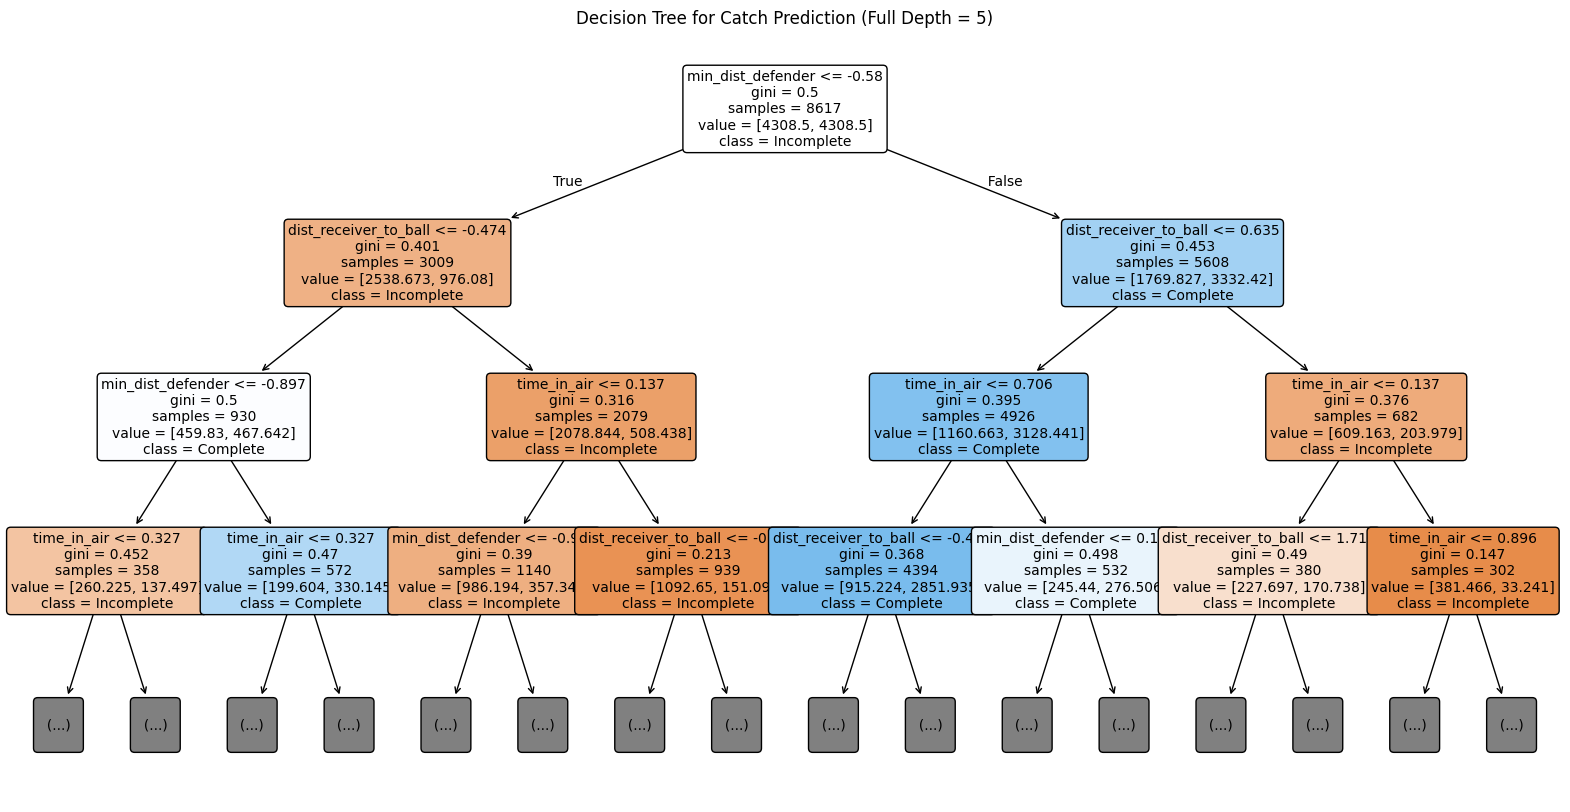

In [53]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plot_tree(
    best_dt,
    feature_names=feature_names,          # X_train_combined.columns
    class_names=["Incomplete", "Complete"],  # 0 = incomplete, 1 = complete
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3                           # just display top of the tree
)

plt.title(f"Decision Tree for Catch Prediction (Full Depth = {best_dt.get_depth()})")
plt.show()


### Rand Forest

In [54]:
## Rand Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

np.random.seed(42)

# Base Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=1,
    n_jobs=-1
)

# Hyperparameter grid
param_grid_rf = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", 0.5],
}

# ---------------------------------------------------------
# manual hyperparameter tuning on the validation set
# ---------------------------------------------------------
best_rf = None
best_params_rf = None
best_val_auc_rf = -np.inf

print("Tuning Random Forest (validation set)...")
for max_depth in param_grid_rf["max_depth"]:
    for min_split in param_grid_rf["min_samples_split"]:
        for min_leaf in param_grid_rf["min_samples_leaf"]:
            for max_feat in param_grid_rf["max_features"]:
                rf_candidate = RandomForestClassifier(
                    n_estimators=300,
                    class_weight="balanced",
                    random_state=1,
                    n_jobs=-1,
                    max_depth=max_depth,
                    min_samples_split=min_split,
                    min_samples_leaf=min_leaf,
                    max_features=max_feat,
                )
                rf_candidate.fit(X_train_scaled, y_train)
                y_val_prob_tmp = rf_candidate.predict_proba(X_val_scaled)[:, 1]
                val_auc_tmp = roc_auc_score(y_val, y_val_prob_tmp)

                if val_auc_tmp > best_val_auc_rf:
                    best_val_auc_rf = val_auc_tmp
                    best_rf = rf_candidate
                    best_params_rf = {
                        "max_depth": max_depth,
                        "min_samples_split": min_split,
                        "min_samples_leaf": min_leaf,
                        "max_features": max_feat,
                    }

print("Best RF params (val-tuned):", best_params_rf)
print("Best RF Validation AUC-ROC:", best_val_auc_rf)
# ---------------------------------------------------------
# END of tuning
# ---------------------------------------------------------

# -------------------- evaluate on TEST set ----------------
y_test_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]     
y_test_pred_rf = best_rf.predict(X_test_scaled)                 

print("\nTest Performance (Random Forest):")                      
print(classification_report(y_test, y_test_pred_rf))             
print("Test AUC-ROC:", roc_auc_score(y_test, y_test_prob_rf))    
# ------------------------------------------------------------------


Tuning Random Forest (validation set)...
Best RF params (val-tuned): {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best RF Validation AUC-ROC: 0.8173420621931259

Test Performance (Random Forest):
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       624
           1       0.84      0.83      0.84      1223

    accuracy                           0.78      1847
   macro avg       0.76      0.76      0.76      1847
weighted avg       0.79      0.78      0.79      1847

Test AUC-ROC: 0.8325982242069732


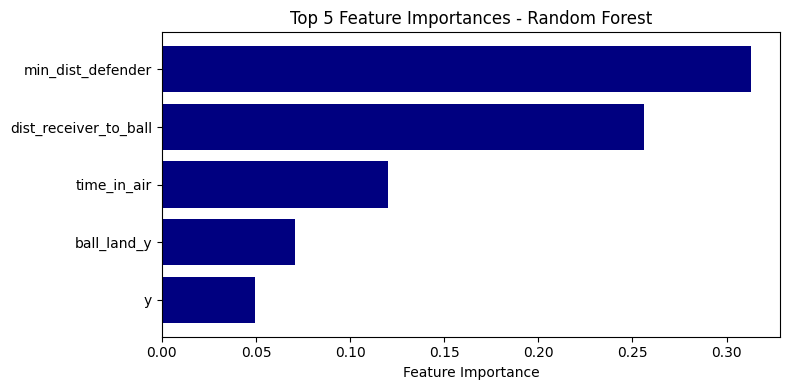

In [55]:
import numpy as np
import matplotlib.pyplot as plt

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:5]  # indices of top 5
top_features = feature_names[indices]
top_importances = importances[indices]

plt.figure(figsize=(8, 4))
plt.barh(range(len(top_features)), top_importances, color="navy")
plt.yticks(range(len(top_features)), top_features)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 5 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


### XGBoost Model

In [56]:
## XGBoost Model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

np.random.seed(42)

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",          # so training uses AUC internally
    use_label_encoder=False,
    tree_method="hist",
    random_state=1,
    n_estimators=300,
    n_jobs=-1
)

param_grid_xgb = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0],
    "min_child_weight": [1, 5]
}

# ---------------------------------------------------------
# manual hyperparameter tuning on the validation set
# ---------------------------------------------------------
best_xgb = None
best_params_xgb = None
best_val_auc_xgb = -np.inf

print("Tuning XGBoost (validation set)...")
for max_depth in param_grid_xgb["max_depth"]:
    for lr in param_grid_xgb["learning_rate"]:
        for subsample in param_grid_xgb["subsample"]:
            for colsample in param_grid_xgb["colsample_bytree"]:
                for mcw in param_grid_xgb["min_child_weight"]:
                    xgb_candidate = XGBClassifier(
                        objective="binary:logistic",
                        eval_metric="auc",
                        use_label_encoder=False,
                        tree_method="hist",
                        random_state=1,
                        n_estimators=300,
                        n_jobs=-1,
                        max_depth=max_depth,
                        learning_rate=lr,
                        subsample=subsample,
                        colsample_bytree=colsample,
                        min_child_weight=mcw,
                    )
                    xgb_candidate.fit(X_train_scaled, y_train)
                    y_val_prob_tmp = xgb_candidate.predict_proba(X_val_scaled)[:, 1]
                    val_auc_tmp = roc_auc_score(y_val, y_val_prob_tmp)

                    if val_auc_tmp > best_val_auc_xgb:
                        best_val_auc_xgb = val_auc_tmp
                        best_xgb = xgb_candidate
                        best_params_xgb = {
                            "max_depth": max_depth,
                            "learning_rate": lr,
                            "subsample": subsample,
                            "colsample_bytree": colsample,
                            "min_child_weight": mcw,
                        }

print("Best XGBoost params (val-tuned):", best_params_xgb)
print("Best XGBoost Validation AUC-ROC:", best_val_auc_xgb)
# ---------------------------------------------------------
# END of tuning section
# ---------------------------------------------------------

# -------------------- evaluate on TEST set ----------------
y_test_prob_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]   
y_test_pred_xgb = best_xgb.predict(X_test_scaled)               

print("\nTest Performance (XGBoost):")                            
print(classification_report(y_test, y_test_pred_xgb))            
print("Test AUC-ROC:", roc_auc_score(y_test, y_test_prob_xgb))   
# ------------------------------------------------------------------

Tuning XGBoost (validation set)...
Best XGBoost params (val-tuned): {'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 5}
Best XGBoost Validation AUC-ROC: 0.8216824877250409

Test Performance (XGBoost):
              precision    recall  f1-score   support

           0       0.75      0.60      0.67       624
           1       0.81      0.90      0.86      1223

    accuracy                           0.80      1847
   macro avg       0.78      0.75      0.76      1847
weighted avg       0.79      0.80      0.79      1847

Test AUC-ROC: 0.8382930268151036


## Add Probabilites back to Arrival DF

In [57]:
# ============================================================
# ADD MODEL CATCH PROBABILITIES BACK TO arrival_df
# ============================================================

# 1) Rebuild the full combined design matrix in the same row order as arrival_df
#    We need to apply the *same* preprocessing (dummies + scaling) to all rows.

# Split arrival_df into numeric / categorical, as before
arrival_num = arrival_df[numerical_cols].copy()
arrival_cat = pd.get_dummies(arrival_df[categorical_cols], drop_first=True).astype(int)

# Align dummy columns to the training dummy columns
arrival_cat = arrival_cat.reindex(columns=all_cat_cols, fill_value=0)

# Combine numeric + categorical for all rows in arrival_df
X_all_combined = pd.concat([arrival_num, arrival_cat], axis=1)

# 2) Scale using the already-fitted scaler
X_all_scaled = scaler.transform(X_all_combined)

# 3) Use best models to get probabilities for every arrival row
arrival_df = arrival_df.copy()  # avoid modifying original in place

arrival_df["catch_prob_rf"] = best_rf.predict_proba(X_all_scaled)[:, 1]
arrival_df["catch_prob_xgb"] = best_xgb.predict_proba(X_all_scaled)[:, 1]

# Optionally round for readability
arrival_df["catch_prob_rf"] = arrival_df["catch_prob_rf"].round(3)
arrival_df["catch_prob_xgb"] = arrival_df["catch_prob_xgb"].round(3)

In [58]:
# arrival_df now has per-play arrival rows with model probabilities attached
arrival_df


game_id  play_id  nfl_id     x     y  ball_land_x  ball_land_y  \
396679  2023090700      101   44930 62.49  2.83        63.26        -0.22   
396688  2023090700      194   41325 84.06 20.70        84.94        21.75   
396696  2023090700      219   53591 74.39  9.91        75.85        11.49   
396712  2023090700      361   38696 28.74 50.94        26.10        49.18   
396719  2023090700      436   53541 35.58 35.35        34.89        34.82   
...            ...      ...     ...   ...   ...          ...          ...   
556855  2024010713     3836   54613 70.32 24.75        69.17        25.13   
556868  2024010713     3906   43454 65.92  6.78        67.67         8.61   
556876  2024010713     3936   46192 60.35 33.61        61.14        33.36   
556893  2024010713     3995   43454 29.74 48.14        29.34        47.66   
556911  2024010713     4018   52457 30.45  7.30        32.14         6.71   

       ball_y_bucket ball_x_bucket  time_since_throw  time_in_air  \
396679          left         40-80              2.10         2.10   
396688        middle        80-120              0.90         0.90   
396696          left         40-80              0.80         0.80   
396712         right          0-40              1.60         1.60   
396719        middle          0-40              0.70         0.70   
...              ...           ...               ...          ...   
556855        middle         40-80              0.70         0.70   
556868          left         40-80              1.30         1.30   
556876        middle         40-80              0.80         0.80   
556893         right          0-40              1.70         1.70   
556911          left          0-40              1.80         1.80   

        time_to_arrival  frame_id  source  dist_receiver_to_ball  \
396679             0.00        21  output                   3.15   
396688             0.00         9  output                   1.37   
396696             0.00         8  output                   2.15   
396712             0.00        16  output                   3.17   
396719             0.00         7  output                   0.87   
...                 ...       ...     ...                    ...   
556855             0.00         7  output                   1.21   
556868             0.00        13  output                   2.53   
556876             0.00         8  output                   0.83   
556893             0.00        17  output                   0.62   
556911             0.00        18  output                   1.79   

        min_dist_defender        player_name  player_height_in  player_weight  \
396679               1.84      Josh Reynolds                75            196   
396688               1.23    Jerick McKinnon                69            205   
396696               3.31          Noah Gray                76            240   
396712               2.09       Marvin Jones                74            198   
396719               2.57  Amon-Ra St. Brown                73            195   
...                   ...                ...               ...            ...   
556855               1.14      Khalil Shakir                72            190   
556868               3.88        Tyreek Hill                70            185   
556876               0.95      Durham Smythe                78            260   
556893               1.45        Tyreek Hill                70            185   
556911               1.53     Chase Claypool                76            227   

       player_side player_position        player_role  is_complete  \
396679     Offense              WR  Targeted Receiver            0   
396688     Offense              RB  Targeted Receiver            1   
396696     Offense              TE  Targeted Receiver            1   
396712     Offense              WR  Targeted Receiver            1   
396719     Offense              WR  Targeted Receiver            1   
...            ...             ...             

# Which Coverages Decrease Reaction Time?
- Recommendations for coverages that allow defenders to have a quick reaction

In [59]:
# lets grab all the important columns we will use

# Columns to bring over from supplementary data
sup_cols_for_merge = [
    "game_id", "play_id",
    "pass_result",
    'yards_to_go',
    "pass_length",
    "offense_formation",
    "receiver_alignment",
    "route_of_targeted_receiver",
    "play_action",
    "dropback_type",
    "dropback_distance",
    "pass_location_type",
    "defenders_in_the_box",
    "team_coverage_man_zone",
    "team_coverage_type",
]


arrival_df_wide = arrival_df.merge(
    sup[sup_cols_for_merge],
    on=["game_id", "play_id"],
    how="left"
)


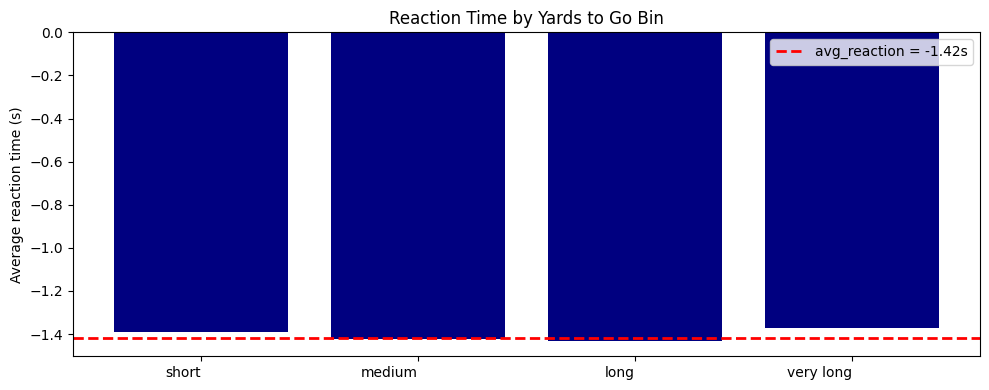

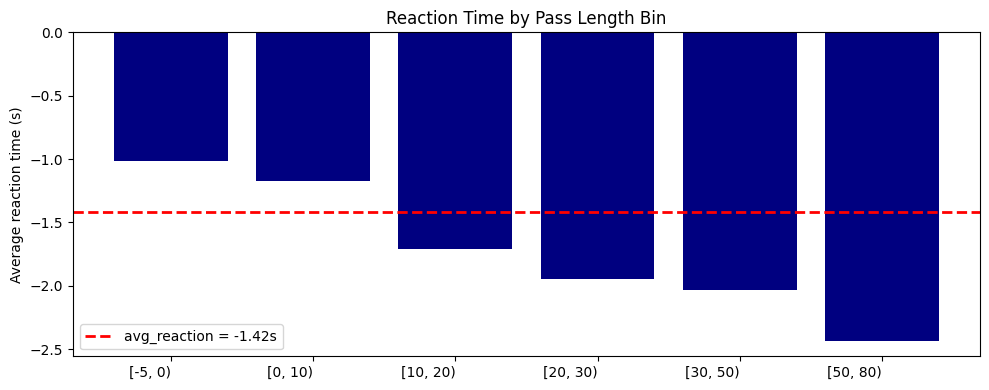

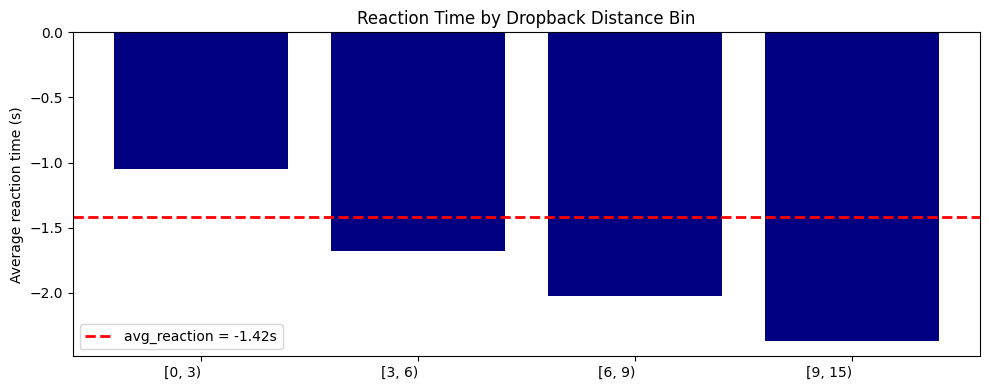

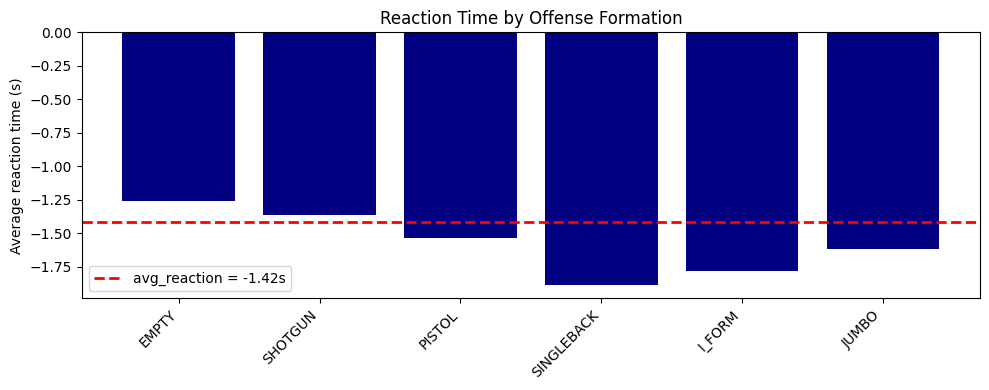

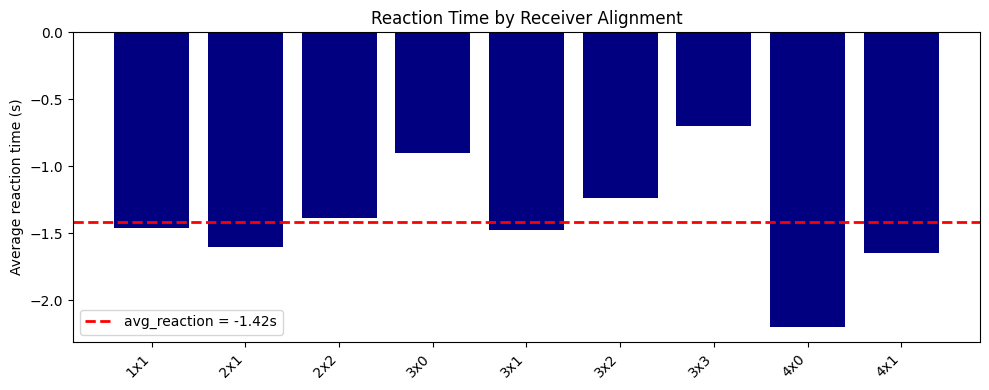

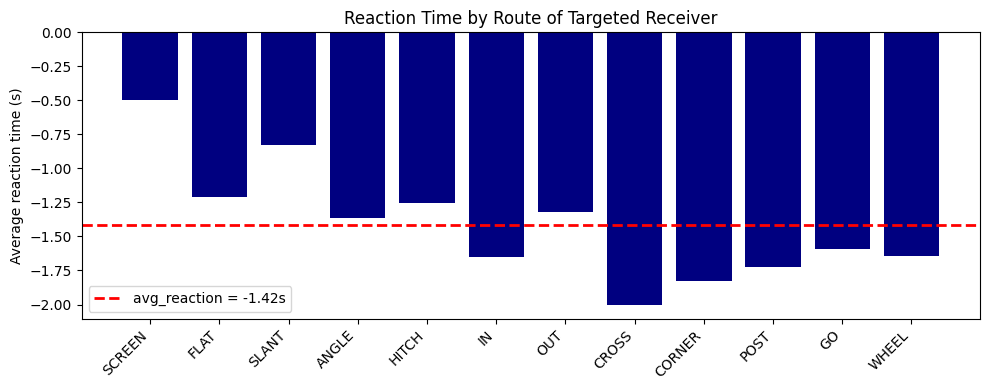

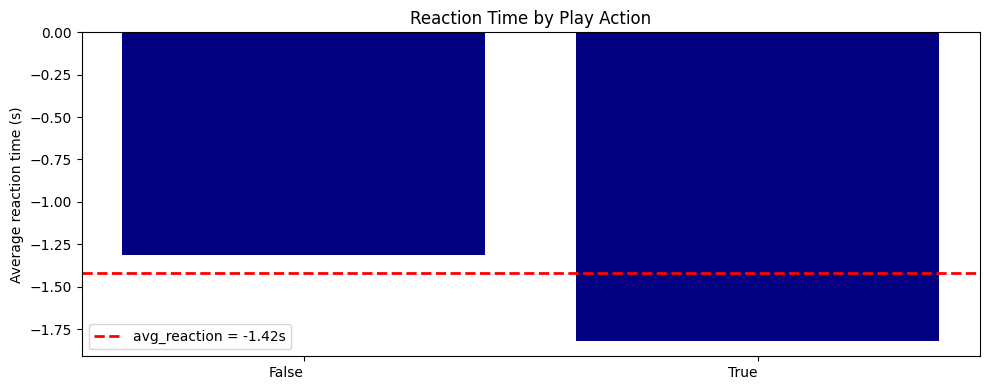

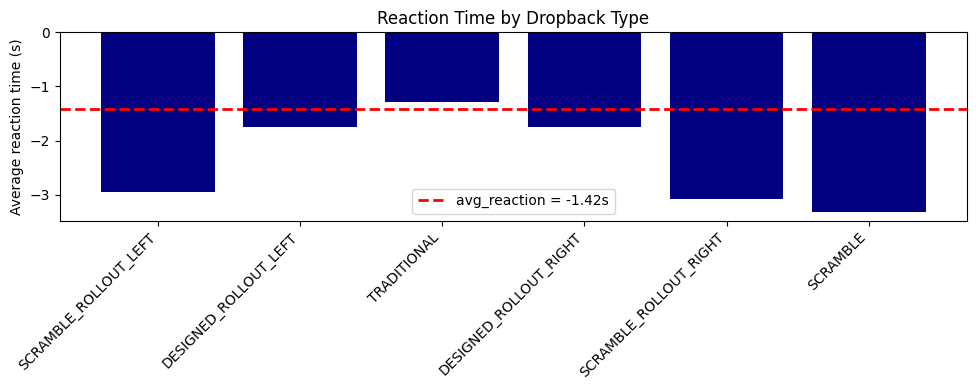

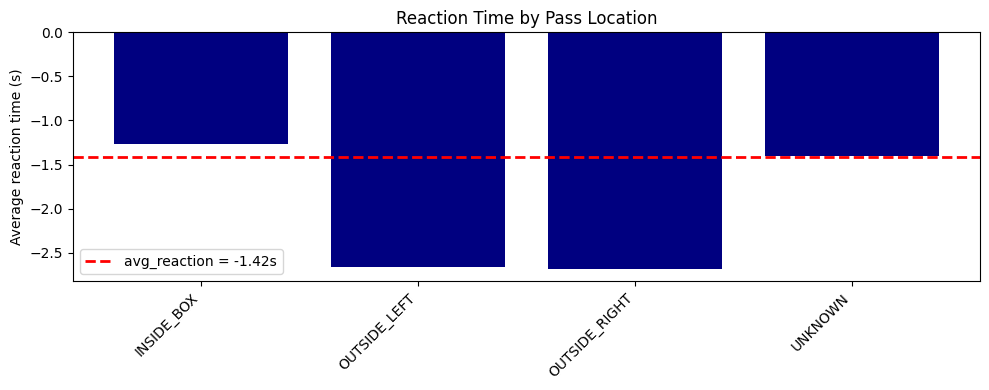

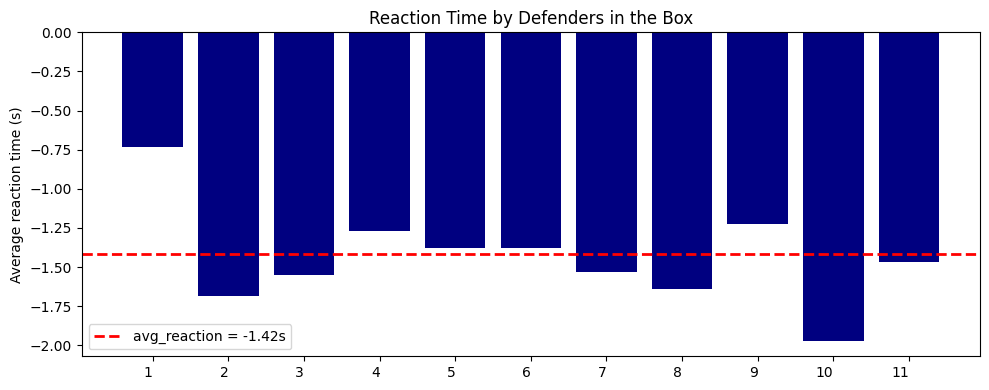

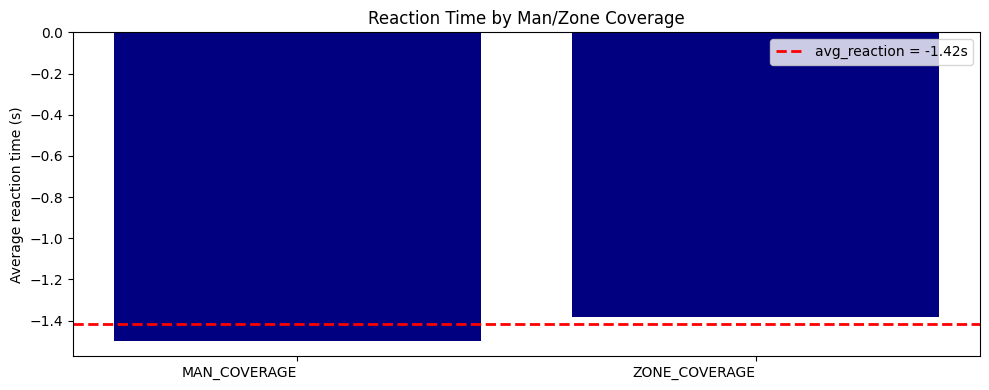

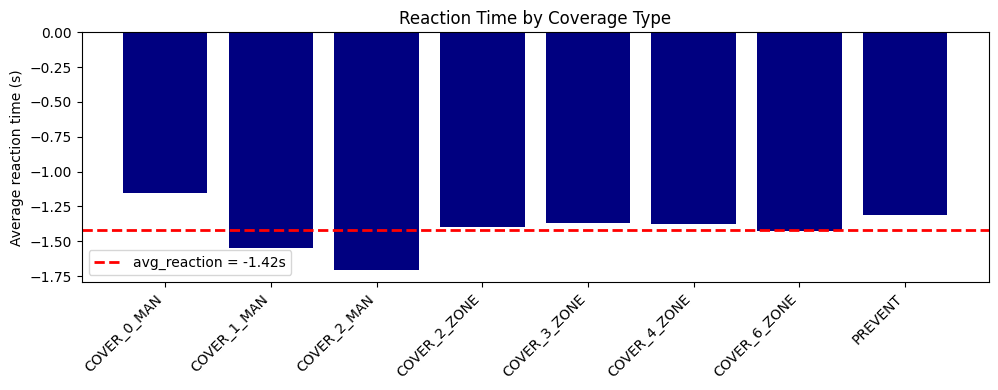

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0. Overall benchmark ----------
overall_avg_react = arrival_df_wide["reaction_time"].mean()

def plot_reaction(df, x_col, y_col, title, rotation=45):
    plt.figure(figsize=(10, 4))
    plt.bar(df[x_col].astype(str), df[y_col], color="navy")
    plt.axhline(
        overall_avg_react,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"avg_reaction = {overall_avg_react:.2f}s",
    )
    plt.xticks(rotation=rotation, ha="right")
    plt.ylabel("Average reaction time (s)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- numeric (binned) variables ----------

# Add yard buckets to "sup"
arrival_df_wide["yards_to_go_bin"] = pd.cut(
    arrival_df_wide["yards_to_go"],
    bins=[-np.inf, 3, 7, 10, np.inf],
    labels=["short", "medium", "long", "very long"],
    right=True,        # (a, b], so 3 in first bin, 7 in second, 10 in third
    include_lowest=True
)


arrival_df_wide["pass_length_bin"] = pd.cut(
    arrival_df_wide["pass_length"],
    bins=[-5, 0, 10, 20, 30, 50, 80],
    right=False,
    include_lowest=True,
)

arrival_df_wide["dropback_distance_bin"] = pd.cut(
    arrival_df_wide["dropback_distance"],
    bins=[-5, 0, 3, 6, 9, 15],
    right=False,
    include_lowest=True,
)


yards_to_go_rt = (
    arrival_df_wide.groupby("yards_to_go_bin")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
    .sort_values("yards_to_go_bin")
)

pass_length_rt = (
    arrival_df_wide.groupby("pass_length_bin")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
    .sort_values("pass_length_bin")
)

dropback_distance_rt = (
    arrival_df_wide.groupby("dropback_distance_bin")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
    .sort_values("dropback_distance_bin")
)


plot_reaction(
    yards_to_go_rt,
    "yards_to_go_bin",
    "avg_reaction_time",
    "Reaction Time by Yards to Go Bin",
    rotation=0,
)


plot_reaction(
    pass_length_rt,
    "pass_length_bin",
    "avg_reaction_time",
    "Reaction Time by Pass Length Bin",
    rotation=0,
)

plot_reaction(
    dropback_distance_rt,
    "dropback_distance_bin",
    "avg_reaction_time",
    "Reaction Time by Dropback Distance Bin",
    rotation=0,
)

# ---------- categorical variables with custom orders ----------

# offense_formation: empty → shotgun/pistol → singleback → I‑form → jumbo
offense_order = ["EMPTY", "SHOTGUN", "PISTOL", "SINGLEBACK", "I_FORM", "JUMBO"]
offense_rt = (
    arrival_df_wide.groupby("offense_formation")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
)
offense_rt["offense_formation"] = pd.Categorical(
    offense_rt["offense_formation"], categories=offense_order, ordered=True
)
offense_rt = offense_rt.sort_values("offense_formation")
plot_reaction(
    offense_rt,
    "offense_formation",
    "avg_reaction_time",
    "Reaction Time by Offense Formation",
)

# receiver_alignment: fewer eligibles / condensed → more spread
receiver_order = ["1x1", "2x1", "2x2", "3x0", "3x1", "3x2", "3x3", "4x0", "4x1"]
receiver_rt = (
    arrival_df_wide.groupby("receiver_alignment")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
)
receiver_rt["receiver_alignment"] = pd.Categorical(
    receiver_rt["receiver_alignment"], categories=receiver_order, ordered=True
)
receiver_rt = receiver_rt.sort_values("receiver_alignment")
plot_reaction(
    receiver_rt,
    "receiver_alignment",
    "avg_reaction_time",
    "Reaction Time by Receiver Alignment",
)

# route_of_targeted_receiver: short → intermediate → deep
route_order = [
    "SCREEN", "FLAT", "SLANT", "ANGLE", "HITCH",
    "IN", "OUT", "CROSS",
    "CORNER", "POST", "GO", "WHEEL",
]
route_rt = (
    arrival_df_wide.groupby("route_of_targeted_receiver")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
)
route_rt["route_of_targeted_receiver"] = pd.Categorical(
    route_rt["route_of_targeted_receiver"],
    categories=route_order,
    ordered=True,
)
route_rt = route_rt.sort_values("route_of_targeted_receiver")
plot_reaction(
    route_rt,
    "route_of_targeted_receiver",
    "avg_reaction_time",
    "Reaction Time by Route of Targeted Receiver",
)

# play_action: False → True
play_action_order = [False, True]
play_action_rt = (
    arrival_df_wide.groupby("play_action")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
)
play_action_rt["play_action"] = pd.Categorical(
    play_action_rt["play_action"],
    categories=play_action_order,
    ordered=True,
)
play_action_rt = play_action_rt.sort_values("play_action")
plot_reaction(
    play_action_rt,
    "play_action",
    "avg_reaction_time",
    "Reaction Time by Play Action",
    rotation=0,
)

# dropback_type: traditional pocket → designed rollouts → scrambles
dropback_type_order = [
    "SCRAMBLE_ROLLOUT_LEFT",
    "DESIGNED_ROLLOUT_LEFT",
    "TRADITIONAL",
    "DESIGNED_ROLLOUT_RIGHT",
    "SCRAMBLE_ROLLOUT_RIGHT",
    "SCRAMBLE",
]
dropback_type_rt = (
    arrival_df_wide.groupby("dropback_type")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
)
dropback_type_rt["dropback_type"] = pd.Categorical(
    dropback_type_rt["dropback_type"],
    categories=dropback_type_order,
    ordered=True,
)
dropback_type_rt = dropback_type_rt.sort_values("dropback_type")
plot_reaction(
    dropback_type_rt,
    "dropback_type",
    "avg_reaction_time",
    "Reaction Time by Dropback Type",
)

# pass_location_type: inside box → outside left → outside right → unknown
pass_loc_order = ["INSIDE_BOX", "OUTSIDE_LEFT", "OUTSIDE_RIGHT", "UNKNOWN"]
pass_loc_rt = (
    arrival_df_wide.groupby("pass_location_type")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
)
pass_loc_rt["pass_location_type"] = pd.Categorical(
    pass_loc_rt["pass_location_type"],
    categories=pass_loc_order,
    ordered=True,
)
pass_loc_rt = pass_loc_rt.sort_values("pass_location_type")
plot_reaction(
    pass_loc_rt,
    "pass_location_type",
    "avg_reaction_time",
    "Reaction Time by Pass Location",
)

# defenders_in_the_box: numeric ascending
def_box_rt = (
    arrival_df_wide.groupby("defenders_in_the_box")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
    .sort_values("defenders_in_the_box")
)
plot_reaction(
    def_box_rt,
    "defenders_in_the_box",
    "avg_reaction_time",
    "Reaction Time by Defenders in the Box",
    rotation=0,
)

# team_coverage_man_zone: man → zone
coverage_mz_order = ["MAN_COVERAGE", "ZONE_COVERAGE"]
coverage_mz_rt = (
    arrival_df_wide.groupby("team_coverage_man_zone")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
)
coverage_mz_rt["team_coverage_man_zone"] = pd.Categorical(
    coverage_mz_rt["team_coverage_man_zone"],
    categories=coverage_mz_order,
    ordered=True,
)
coverage_mz_rt = coverage_mz_rt.sort_values("team_coverage_man_zone")
plot_reaction(
    coverage_mz_rt,
    "team_coverage_man_zone",
    "avg_reaction_time",
    "Reaction Time by Man/Zone Coverage",
    rotation=0,
)

# team_coverage_type: man coverages (0,1,2) → zone shells (2,3,4,6) → prevent
coverage_type_order = [
    "COVER_0_MAN",
    "COVER_1_MAN",
    "COVER_2_MAN",
    "COVER_2_ZONE",
    "COVER_3_ZONE",
    "COVER_4_ZONE",
    "COVER_6_ZONE",
    "PREVENT",
]
coverage_type_rt = (
    arrival_df_wide.groupby("team_coverage_type")["reaction_time"]
    .mean().reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
)
coverage_type_rt["team_coverage_type"] = pd.Categorical(
    coverage_type_rt["team_coverage_type"],
    categories=coverage_type_order,
    ordered=True,
)
coverage_type_rt = coverage_type_rt.sort_values("team_coverage_type")
plot_reaction(
    coverage_type_rt,
    "team_coverage_type",
    "avg_reaction_time",
    "Reaction Time by Coverage Type",
)


# Which Players Have the Fastest Reaction Time?
- Within each type of coverage
- Coverage agnostic approach
- Recommendations for underrated players that have that quick twitch and mental capability to recognize plays

In [61]:
# Bring defender names onto the arrival-wide table
# wr_db_rt already has def_nfl_id and def_name per frame, so use that
def_name_map = (
    wr_db_rt[["def_nfl_id", "def_name"]]
    .dropna(subset=["def_nfl_id", "def_name"])
    .drop_duplicates(subset=["def_nfl_id"])
)

arrival_df_wide_name = arrival_df_wide.merge(
    def_name_map,
    on="def_nfl_id",
    how="left"
)

In [62]:
import numpy as np
import matplotlib.pyplot as plt


N_TOP = 5  # number of players per segment


def plot_fastest_players_by_segment(df, seg_col, seg_order=None, title_prefix=""):
    """
    For each value of seg_col, find the N_TOP defenders with the fastest
    average reaction_time in that segment, and plot them as grouped bars.
    A red horizontal line shows the segment-level average reaction_time.
    Defender names are labeled above the bars, rotated 90 degrees.
    """
    # Drop rows with missing segment, reaction_time, or defender name
    tmp = df.dropna(subset=[seg_col, "reaction_time", "def_name"]).copy()

    # If an explicit order is provided, enforce it; otherwise use natural order
    if seg_order is not None:
        tmp[seg_col] = pd.Categorical(tmp[seg_col], categories=seg_order, ordered=True)

    # Segment-level benchmark (avg reaction time in that segment)
    seg_bench = (
        tmp.groupby(seg_col)["reaction_time"]
        .mean()
        .rename("segment_reaction_time")
    )

    # Average reaction time per defender within each segment
    seg_player_rt = (
        tmp.groupby([seg_col, "def_name"])["reaction_time"]
        .mean()
        .reset_index()
    )

    # Attach segment benchmark so we can access it when plotting
    seg_player_rt = seg_player_rt.merge(
        seg_bench.reset_index(), on=seg_col, how="left"
    )

    # Sort segments in desired order
    if seg_order is not None:
        seg_player_rt[seg_col] = pd.Categorical(
            seg_player_rt[seg_col], categories=seg_order, ordered=True
        )
    seg_values = seg_player_rt[seg_col].dropna().unique()

    # Prepare figure and axis
    fig, ax = plt.subplots(figsize=(max(10, len(seg_values) * 1.8), 12))

    bar_width = 0.12
    # take evenly spaced samples over the whole colormap, then reverse: dark -> light
    greens = plt.cm.Greens(np.linspace(0.0, 1.0, 20))[::-1]

    min_rt = seg_player_rt["reaction_time"].min()

    # y position for labels above bars
    label_y = 0.3  # small positive value so bars "touch" 0 and labels are above

    # flag so we only add the legend label once
    added_line_label = False

    for i, seg_val in enumerate(seg_values):
        seg_data = seg_player_rt[seg_player_rt[seg_col] == seg_val].copy()
        seg_data = seg_data.sort_values("reaction_time").head(N_TOP)

        x_center = i

        for j, (_, row) in enumerate(seg_data.iterrows()):
            x_pos = x_center + (j - (N_TOP - 1) / 2) * bar_width
            player = row["def_name"]
            rt = row["reaction_time"]
            color = greens[j % len(greens)]

            ax.bar(x_pos, rt, width=bar_width, color=color)

            ax.text(
                x_pos,
                label_y,
                player,
                ha="left",
                va="bottom",
                rotation=90,
                fontsize=10,
                clip_on=False,
            )

        seg_mean = seg_bench.loc[seg_val]

        # add label only for the first segment so legend has a single entry
        if not added_line_label:
            ax.hlines(
                seg_mean,
                x_center - 0.6,
                x_center + 0.6,
                colors="red",
                linestyles="--",
                linewidth=2,
                label="Avg reaction time",
            )
            added_line_label = True
        else:
            ax.hlines(
                seg_mean,
                x_center - 0.6,
                x_center + 0.6,
                colors="red",
                linestyles="--",
                linewidth=2,
            )

    # Make the black top axis line "taller":
    top_extra = -0.25
    ax.set_ylim(bottom=min_rt - 0.5, top=label_y + top_extra)

    ax.set_xticks(range(len(seg_values)))
    ax.set_xticklabels([str(v) for v in seg_values], rotation=45, ha="right")

    ax.set_ylabel("Average reaction time (s)")
    ax.set_title(f"{title_prefix}Fastest {N_TOP} Defenders by {seg_col}", pad=150)

    # legend explaining the red line
    ax.legend(loc="upper right")

    fig.tight_layout(rect=(0, 0, 1, 0.6))

    plt.show()


In [63]:
# Filter to defenders with at least 30 reactions
arrival_df_wide_filtered = arrival_df_wide_name[arrival_df_wide_name["nfl_id_react_count"] > 30].copy()

# filter to have 3 or more in the box
arrival_df_wide_filtered = arrival_df_wide_filtered[arrival_df_wide_filtered["defenders_in_the_box"] > 2]


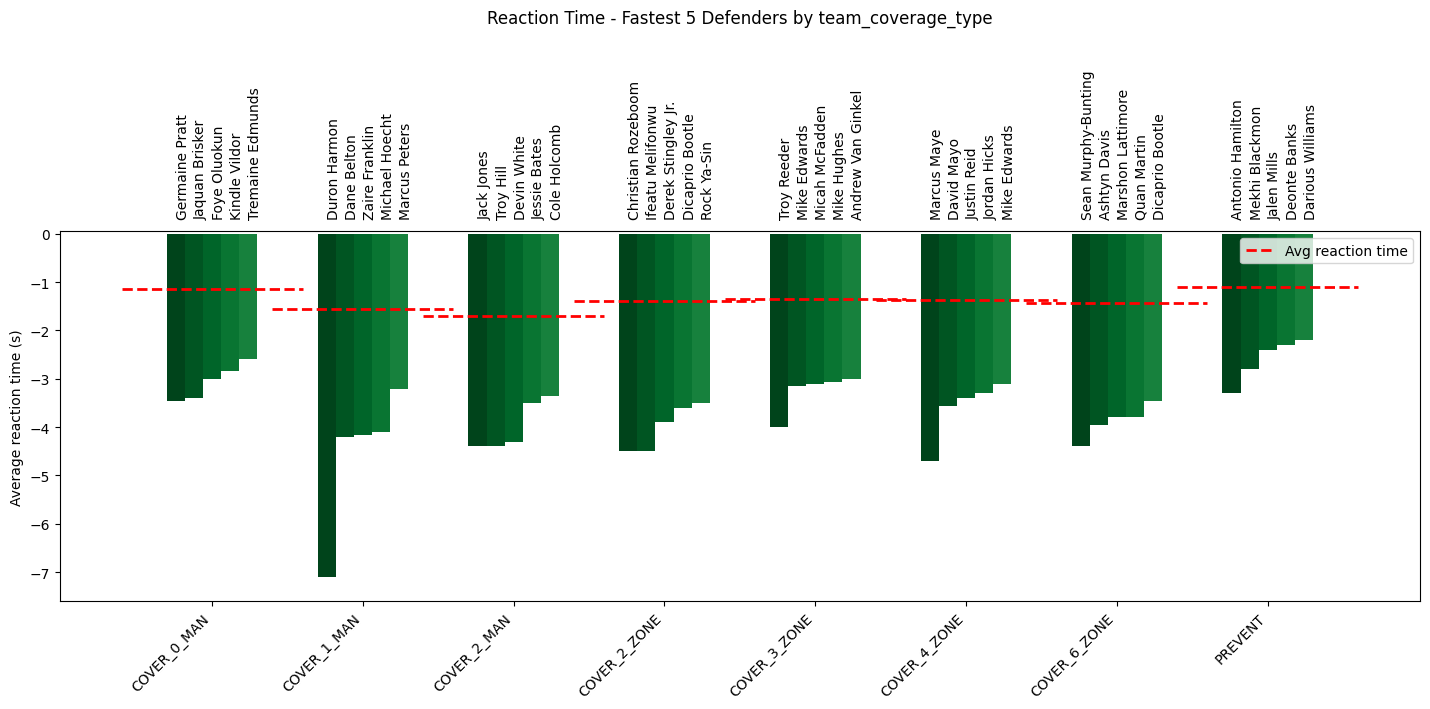

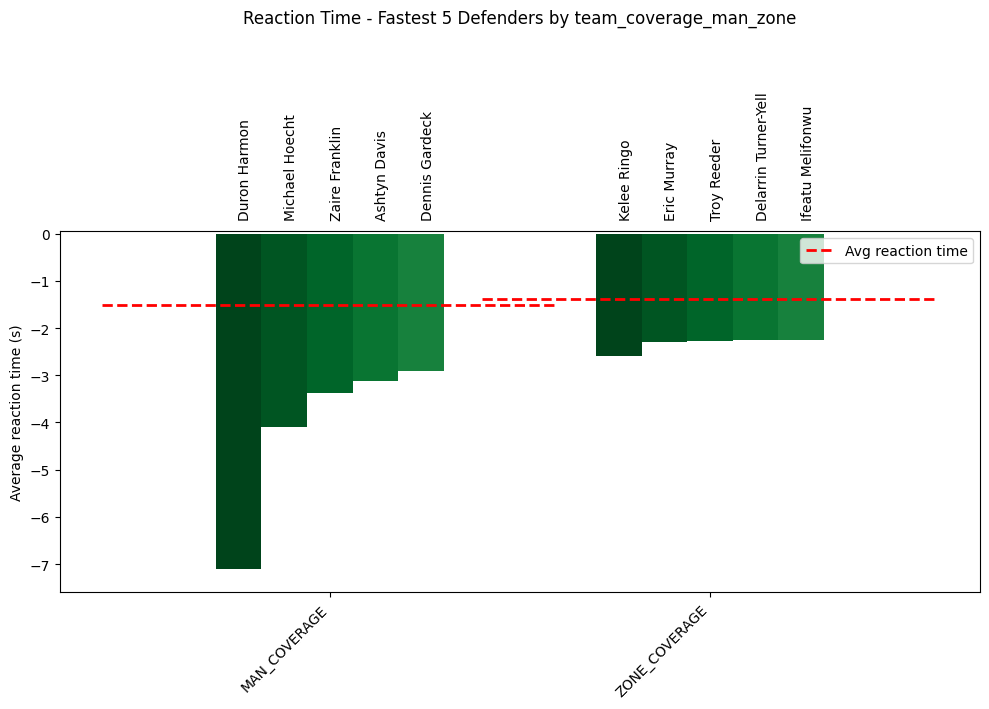

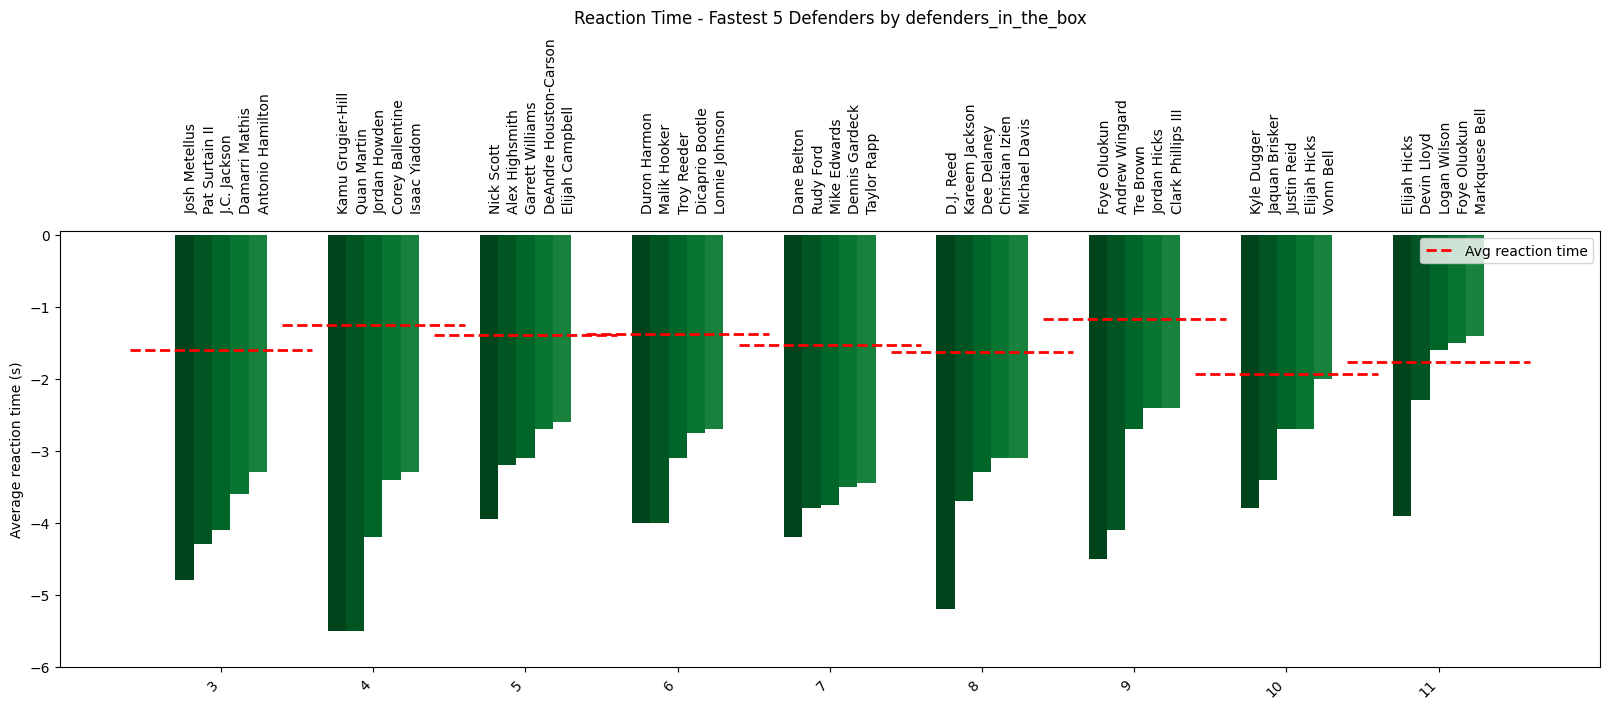

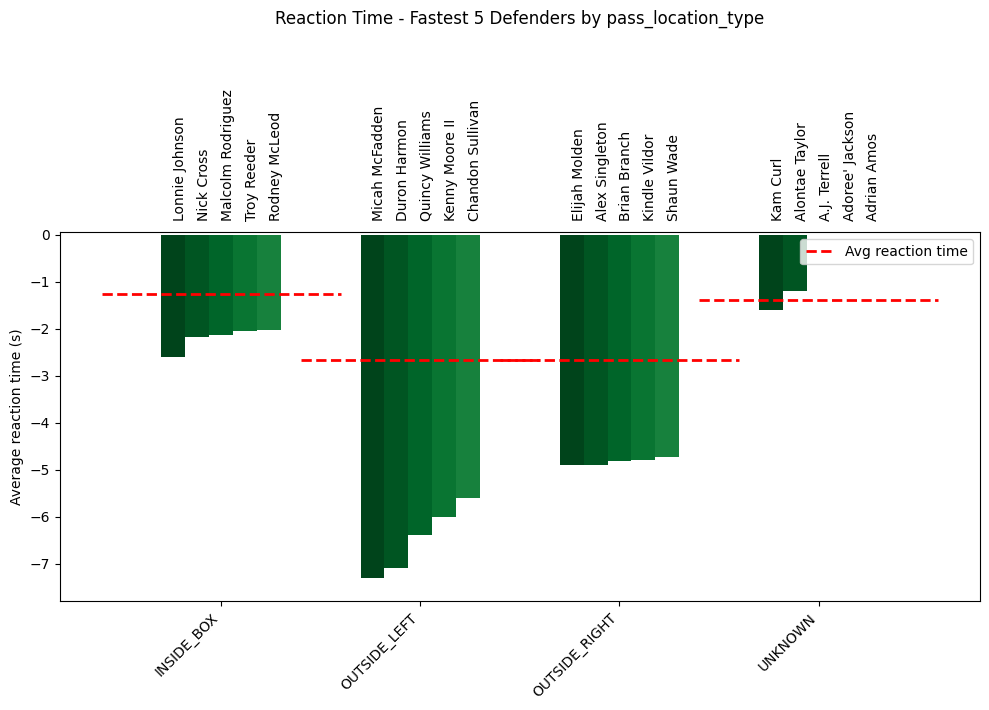

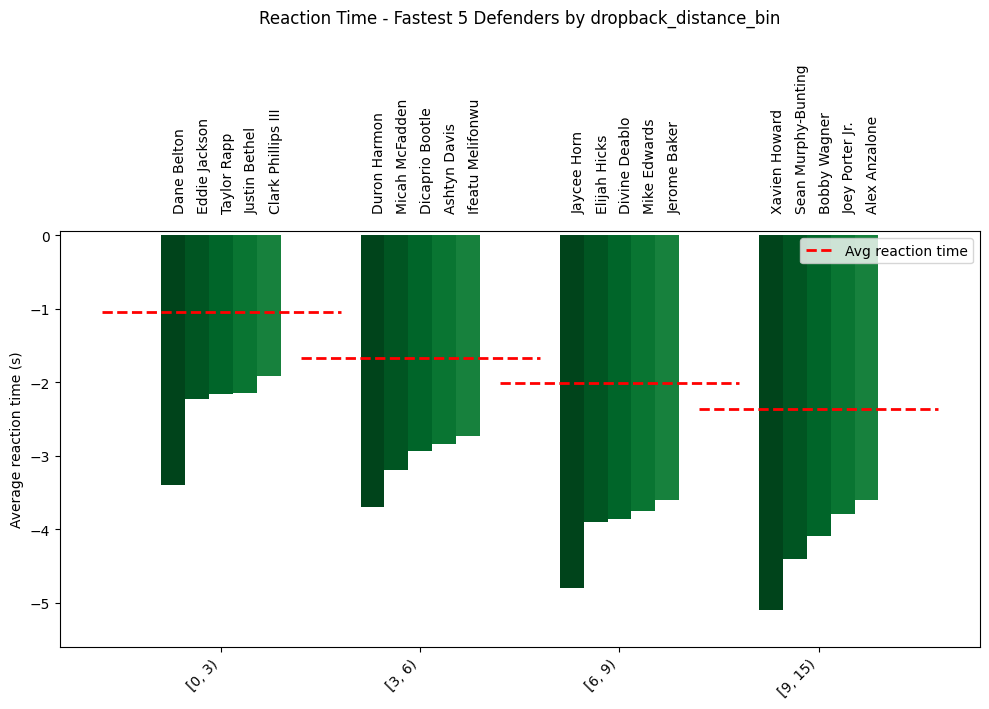

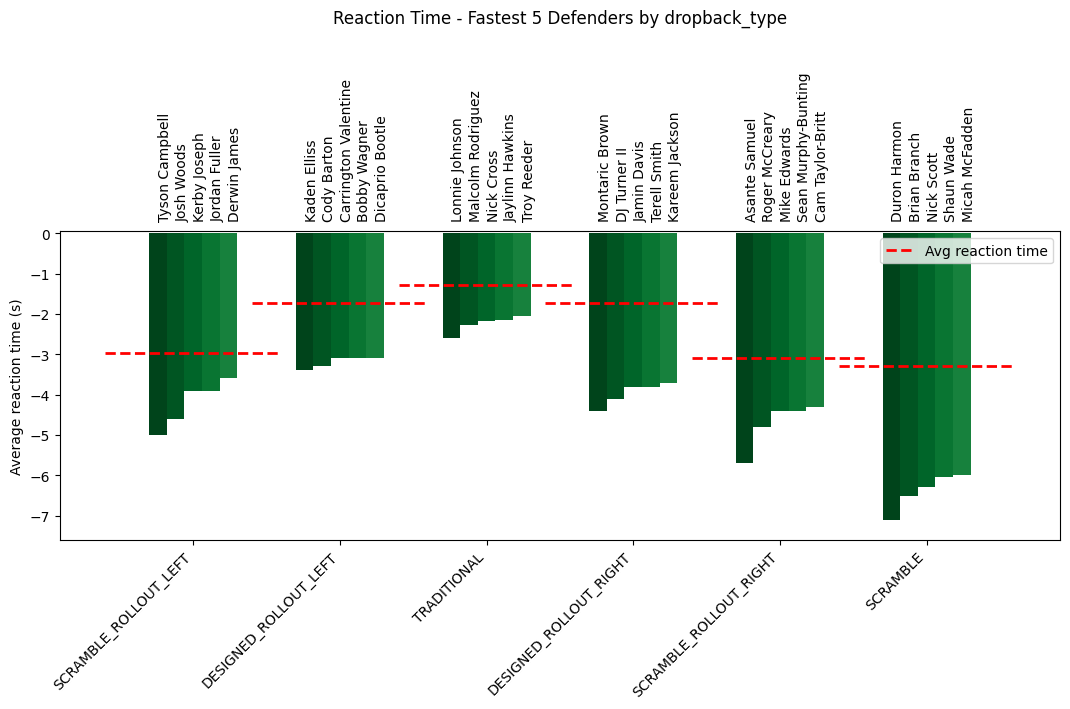

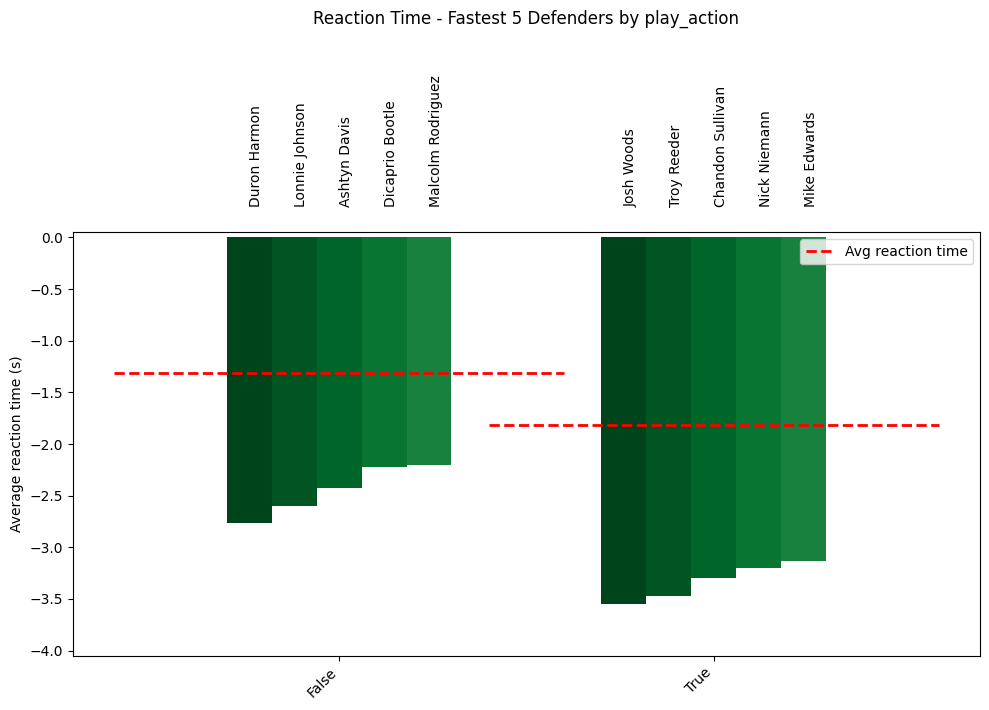

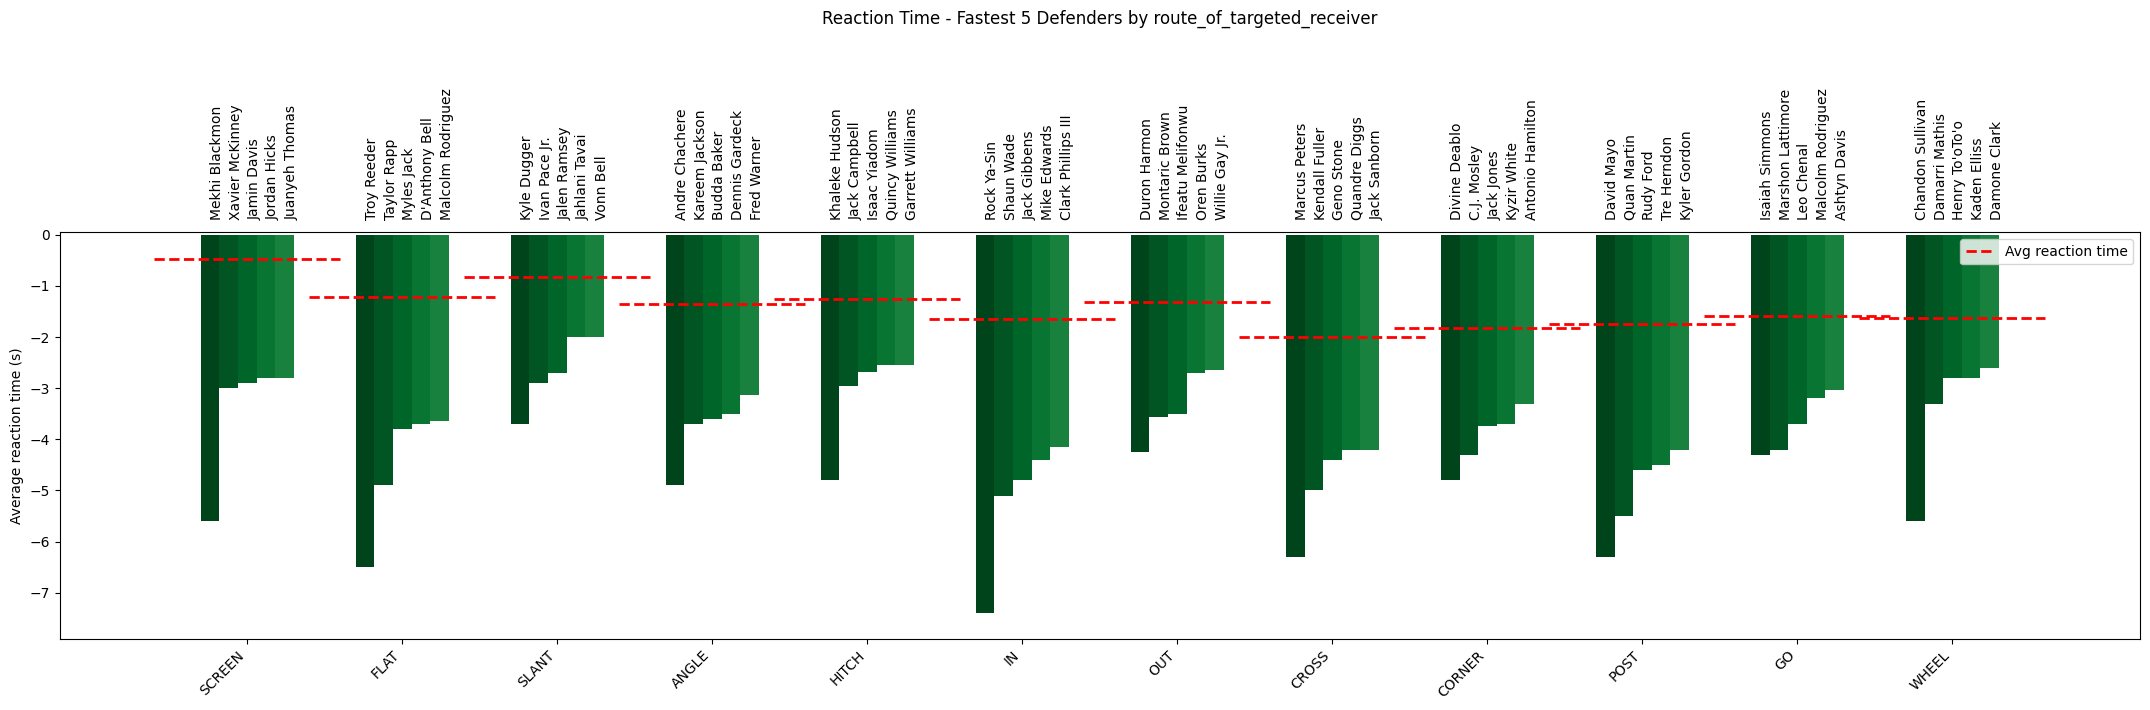

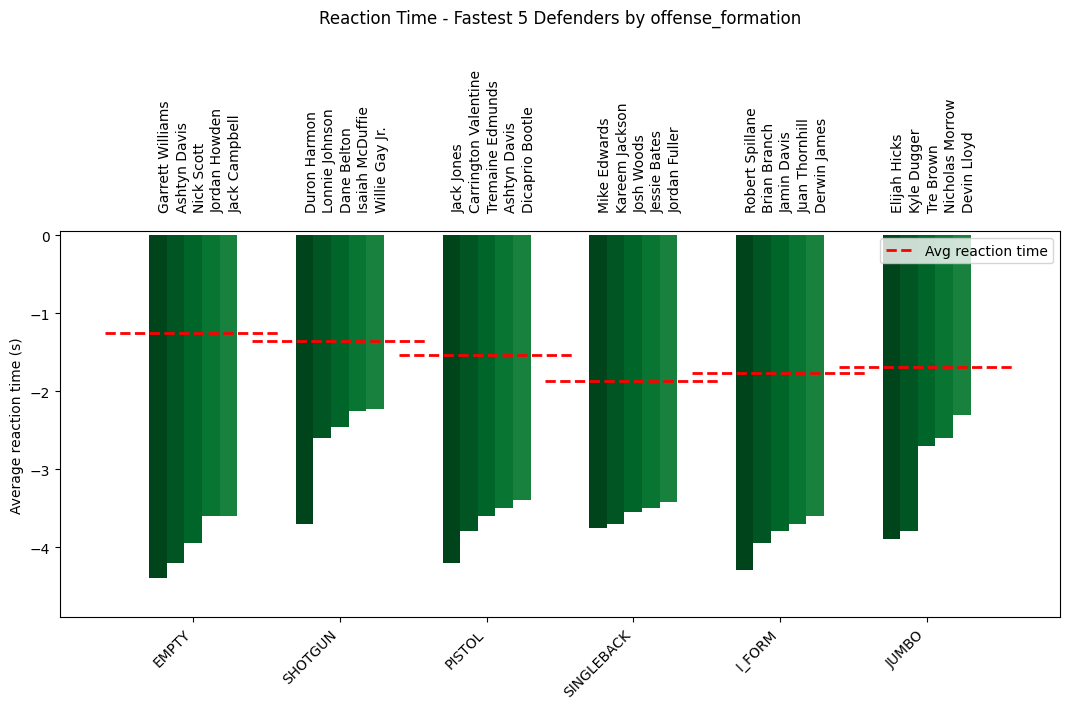

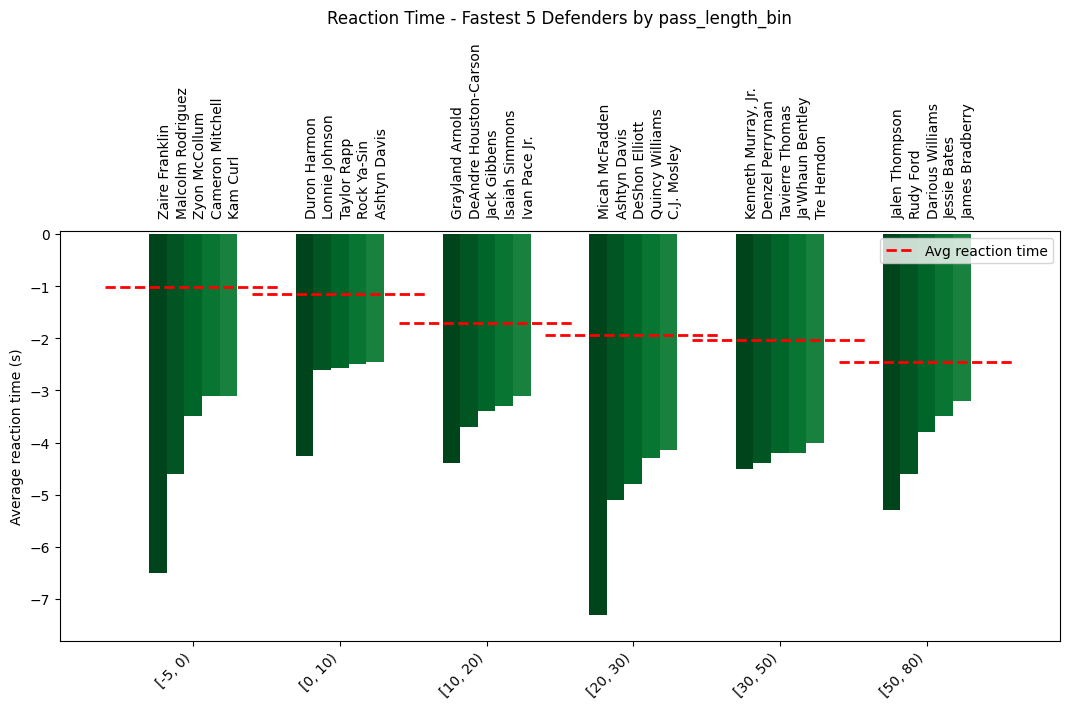

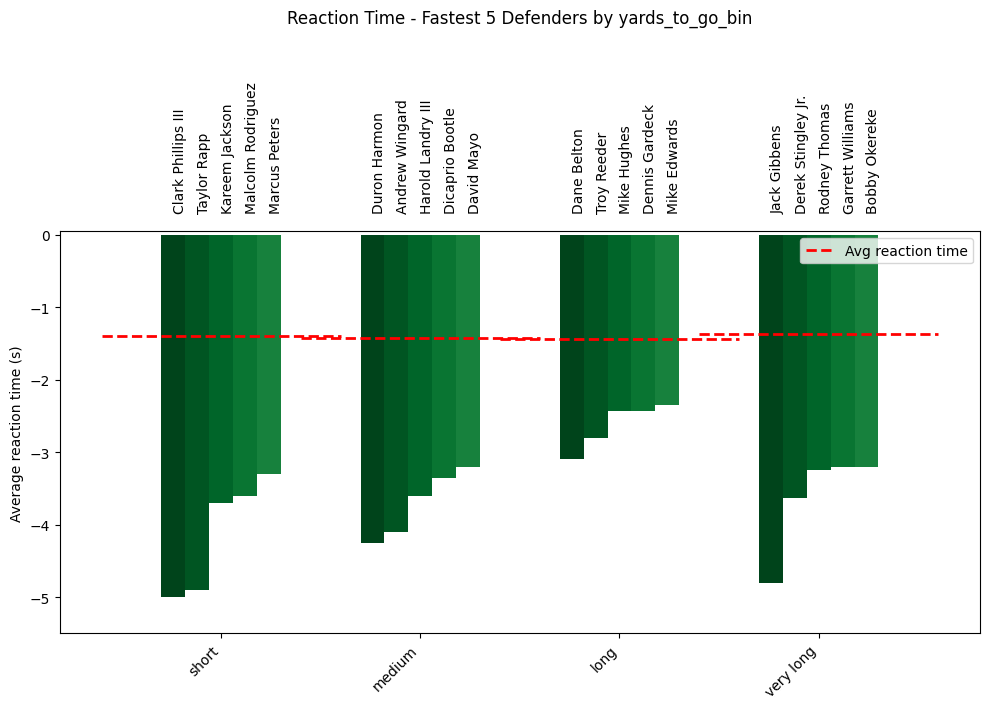

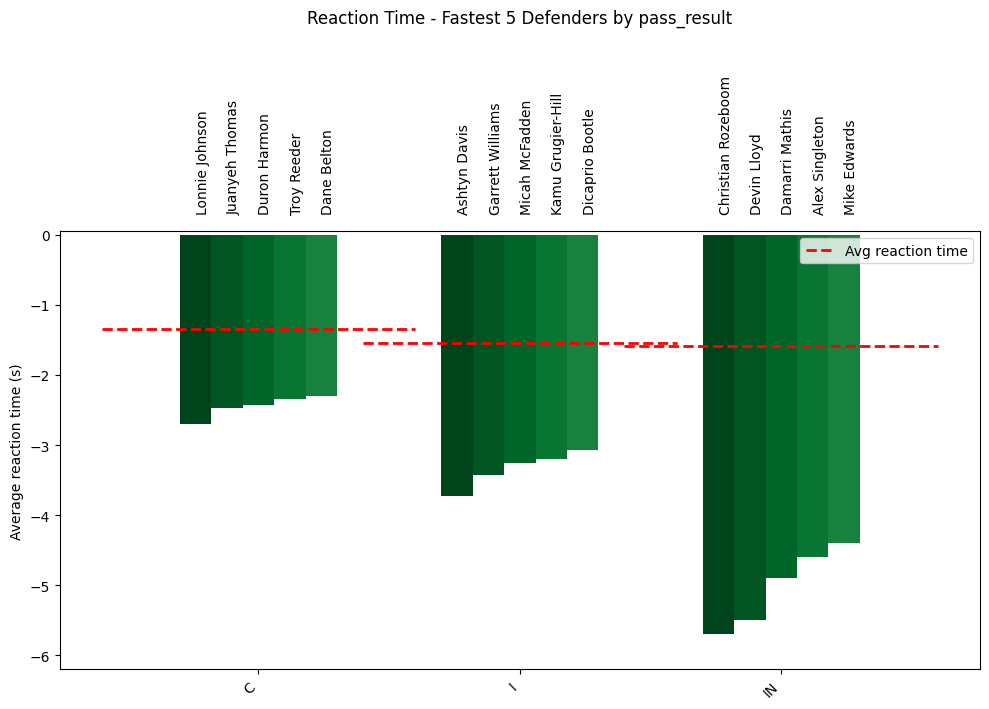

In [64]:
# team_coverage_type
coverage_type_order = [
    "COVER_0_MAN",
    "COVER_1_MAN",
    "COVER_2_MAN",
    "COVER_2_ZONE",
    "COVER_3_ZONE",
    "COVER_4_ZONE",
    "COVER_6_ZONE",
    "PREVENT",
]
plot_fastest_players_by_segment(arrival_df_wide_filtered, "team_coverage_type",
                                seg_order=coverage_type_order,
                                title_prefix="Reaction Time - ")

# team_coverage_man_zone
coverage_mz_order = ["MAN_COVERAGE", "ZONE_COVERAGE"]
plot_fastest_players_by_segment(arrival_df_wide_filtered, "team_coverage_man_zone",
                                seg_order=coverage_mz_order,
                                title_prefix="Reaction Time - ")

# defenders_in_the_box (treated as numeric, ascending)
def_box_order = sorted(arrival_df_wide_filtered["defenders_in_the_box"].dropna().unique())
plot_fastest_players_by_segment(arrival_df_wide_filtered, "defenders_in_the_box",
                                seg_order=def_box_order,
                                title_prefix="Reaction Time - ")

# pass_location_type
pass_loc_order = ["INSIDE_BOX", "OUTSIDE_LEFT", "OUTSIDE_RIGHT", "UNKNOWN"]
plot_fastest_players_by_segment(arrival_df_wide_filtered, "pass_location_type",
                                seg_order=pass_loc_order,
                                title_prefix="Reaction Time - ")

# dropback_distance_bin (already created)
dropback_dist_order = sorted(arrival_df_wide_filtered["dropback_distance_bin"].dropna().unique())
plot_fastest_players_by_segment(arrival_df_wide_filtered, "dropback_distance_bin",
                                seg_order=dropback_dist_order,
                                title_prefix="Reaction Time - ")

# dropback_type
plot_fastest_players_by_segment(arrival_df_wide_filtered, "dropback_type",
                                seg_order=dropback_type_order,
                                title_prefix="Reaction Time - ")

# play_action
play_action_order = [False, True]
plot_fastest_players_by_segment(arrival_df_wide_filtered, "play_action",
                                seg_order=play_action_order,
                                title_prefix="Reaction Time - ")

# route_of_targeted_receiver
plot_fastest_players_by_segment(arrival_df_wide_filtered, "route_of_targeted_receiver",
                                seg_order=route_order,
                                title_prefix="Reaction Time - ")

# offense_formation
offense_order = ["EMPTY", "SHOTGUN", "PISTOL", "SINGLEBACK", "I_FORM", "JUMBO"]
plot_fastest_players_by_segment(arrival_df_wide_filtered, "offense_formation",
                                seg_order=offense_order,
                                title_prefix="Reaction Time - ")

# pass_length_bin
pass_length_order = sorted(arrival_df_wide_filtered["pass_length_bin"].dropna().unique())
plot_fastest_players_by_segment(arrival_df_wide_filtered, "pass_length_bin",
                                seg_order=pass_length_order,
                                title_prefix="Reaction Time - ")

# yards_to_go_bin
yards_to_go_order = ["short", "medium", "long", "very long"]
plot_fastest_players_by_segment(arrival_df_wide_filtered, "yards_to_go_bin",
                                seg_order=yards_to_go_order,
                                title_prefix="Reaction Time - ")

# pass_result
pass_result_order = ["C", "I", "IN"]  # or whatever order you prefer
plot_fastest_players_by_segment(arrival_df_wide_filtered, "pass_result",
                                seg_order=pass_result_order,
                                title_prefix="Reaction Time - ")


In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


N_TOP = 5  # number of players per segment


def plot_slowest_players_by_segment(df, seg_col, seg_order=None, title_prefix=""):
    """
    For each value of seg_col, find the N_TOP defenders with the slowest
    average reaction_time in that segment, and plot them as grouped bars.
    A green horizontal line shows the segment-level average reaction_time.
    Name labels are all drawn at the same global y-level across the figure.
    """

    # ---------- MANUAL TUNING: NAME HEIGHT OFFSETS ----------
    base_offset = 0.1   # label offset when max in segment >= 0
    neg_offset = 0.4    # label offset when max in segment < 0
    # --------------------------------------------------------

    # Drop rows with missing segment, reaction_time, or defender name
    tmp = df.dropna(subset=[seg_col, "reaction_time", "def_name"]).copy()

    # Enforce explicit segment order, if provided
    if seg_order is not None:
        tmp[seg_col] = pd.Categorical(tmp[seg_col], categories=seg_order, ordered=True)

    # Segment-level benchmark (avg reaction time in that segment)
    seg_bench = (
        tmp.groupby(seg_col)["reaction_time"]
        .mean()
        .rename("segment_reaction_time")
    )

    # Average reaction time per defender within each segment
    seg_player_rt = (
        tmp.groupby([seg_col, "def_name"])["reaction_time"]
        .mean()
        .reset_index()
    )

    # Attach segment benchmark
    seg_player_rt = seg_player_rt.merge(
        seg_bench.reset_index(), on=seg_col, how="left"
    )

    # Sort segments in desired order
    if seg_order is not None:
        seg_player_rt[seg_col] = pd.Categorical(
            seg_player_rt[seg_col], categories=seg_order, ordered=True
        )
    seg_values = seg_player_rt[seg_col].dropna().unique()

    # Prepare figure and axis
    fig, ax = plt.subplots(figsize=(max(10, len(seg_values) * 1.8), 10))

    bar_width = 0.12
    reds = plt.cm.Reds(np.linspace(0.0, 1.0, 20))[::-1]

    # global bounds for bar heights
    min_rt = seg_player_rt["reaction_time"].min()
    max_rt = seg_player_rt["reaction_time"].max()

    # --------- 1) precompute global label y-position ----------
    y_labels_per_segment = []
    for seg_val in seg_values:
        seg_data = seg_player_rt[seg_player_rt[seg_col] == seg_val].copy()
        seg_data = seg_data.sort_values("reaction_time", ascending=False).head(N_TOP)
        seg_max = seg_data["reaction_time"].max()
        if seg_max < 0:
            y_label = seg_max + neg_offset
        else:
            y_label = seg_max + base_offset
        y_labels_per_segment.append(y_label)

    global_y_label = max(y_labels_per_segment)
    # ---------------------------------------------------------

    added_line_label = False

    # --------- 2) plotting loop using global_y_label ----------
    for i, seg_val in enumerate(seg_values):
        seg_data = seg_player_rt[seg_player_rt[seg_col] == seg_val].copy()
        seg_data = seg_data.sort_values("reaction_time", ascending=False).head(N_TOP)

        x_center = i

        for j, (_, row) in enumerate(seg_data.iterrows()):
            x_pos = x_center + (j - (N_TOP - 1) / 2) * bar_width
            player = row["def_name"]
            rt = row["reaction_time"]
            color = reds[j % len(reds)]

            ax.bar(x_pos, rt, width=bar_width, color=color)

            ax.text(
                x_pos,
                global_y_label,
                player,
                ha="left",
                va="bottom",
                rotation=90,
                fontsize=10,
                clip_on=False,
            )

        seg_mean = seg_bench.loc[seg_val]

        if not added_line_label:
            ax.hlines(
                seg_mean,
                x_center - 0.6,
                x_center + 0.6,
                colors="green",
                linestyles="--",
                linewidth=2,
                label="Avg reaction time",
            )
            added_line_label = True
        else:
            ax.hlines(
                seg_mean,
                x_center - 0.6,
                x_center + 0.6,
                colors="green",
                linestyles="--",
                linewidth=2,
            )

    # ---------- 3) adaptive y-limits with percentage padding ----------
    # include bars, benchmarks, and label height in the observed range
    data_min = min(min_rt, seg_bench.min())
    data_max = max(max_rt, global_y_label)

    data_range = max(0.1, data_max - data_min)  # avoid zero range

    bottom_pad_frac = 0.   # 0% of range below data
    top_pad_frac = 0.0      # 0% of range above data

    y_bottom = data_min - bottom_pad_frac * data_range
    y_top = data_max + top_pad_frac * data_range

    ax.set_ylim(bottom=y_bottom, top=y_top)
    # -----------------------------------------------------------------

    ax.spines["top"].set_visible(False)

    ax.set_xticks(range(len(seg_values)))
    ax.set_xticklabels([str(v) for v in seg_values], rotation=45, ha="right")

    ax.set_ylabel("Average reaction time (s)")
    ax.set_title(f"{title_prefix}Slowest {N_TOP} Defenders by {seg_col}", pad=130)

    ax.legend(loc="upper right", bbox_to_anchor=(0.9, .3))

    fig.tight_layout(rect=(0, 0, 1, 0.7))

    plt.show()


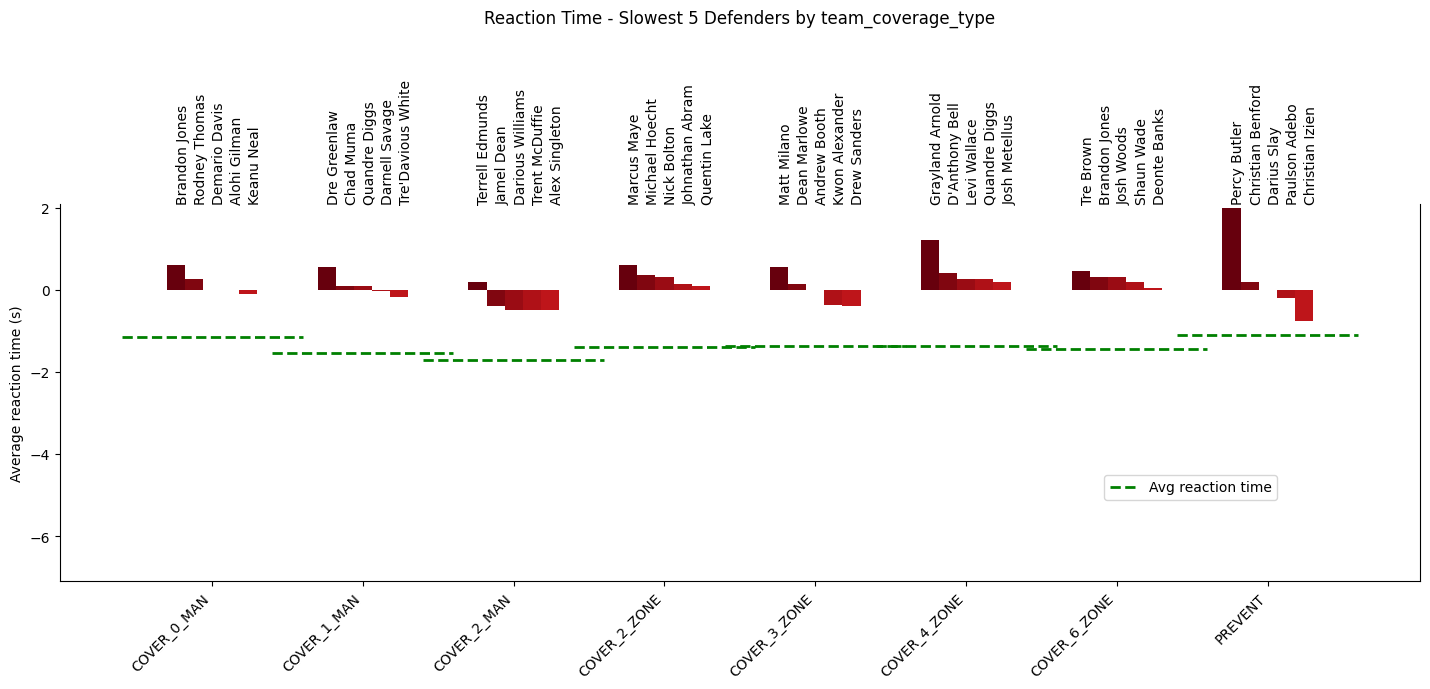

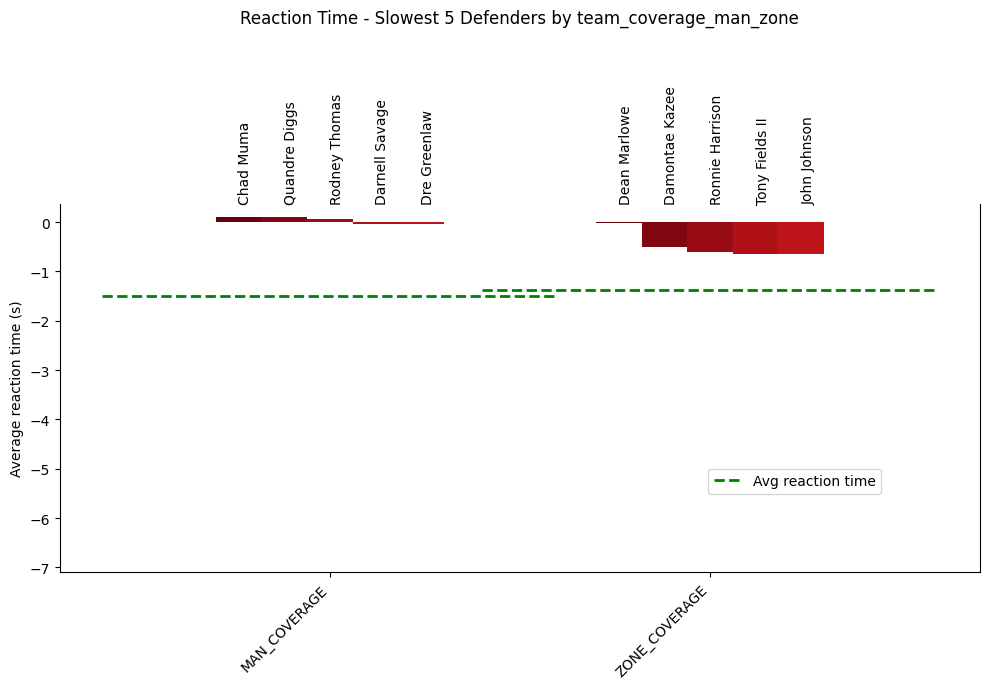

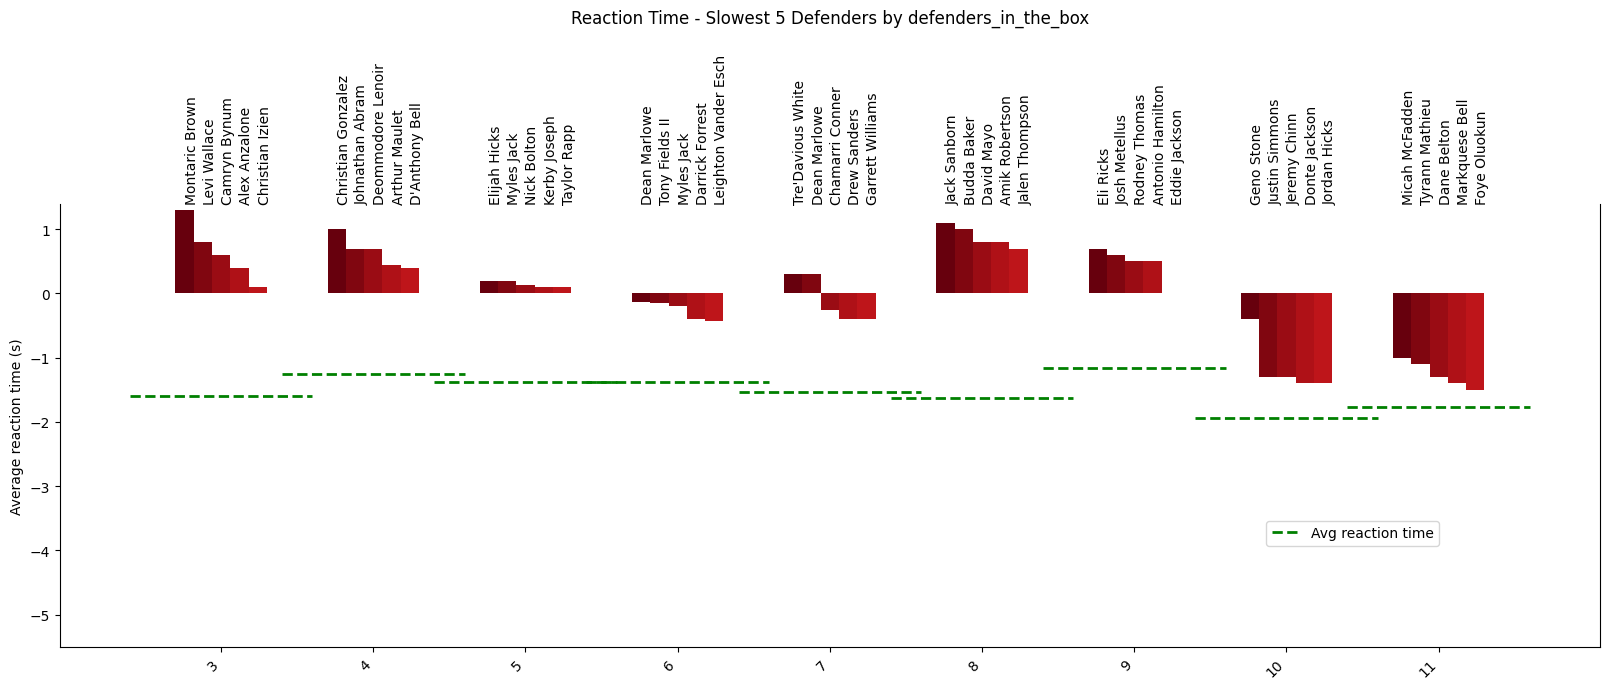

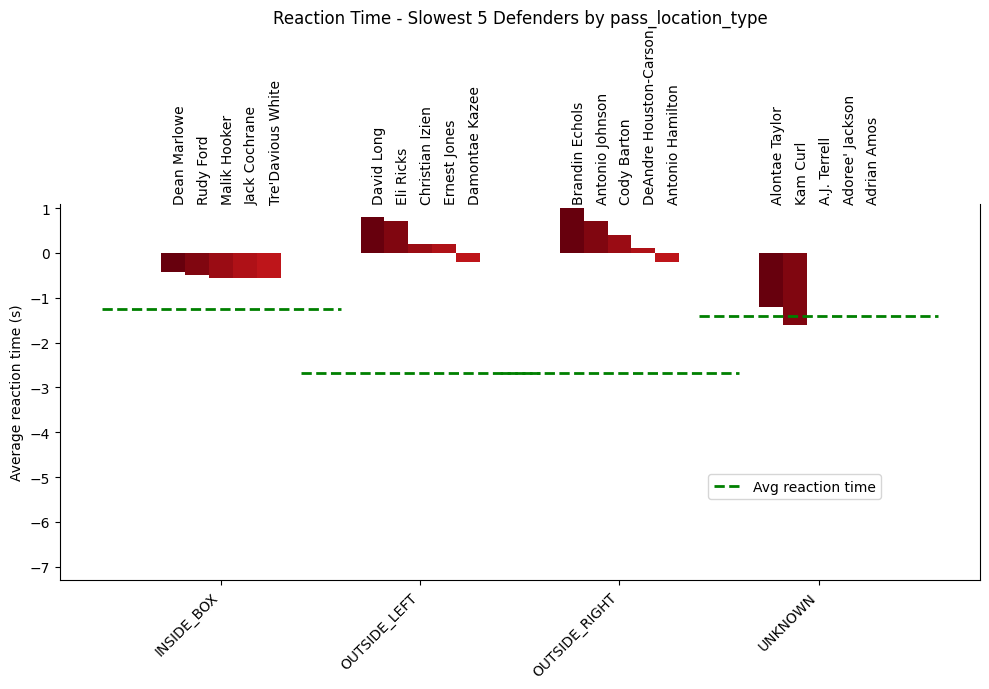

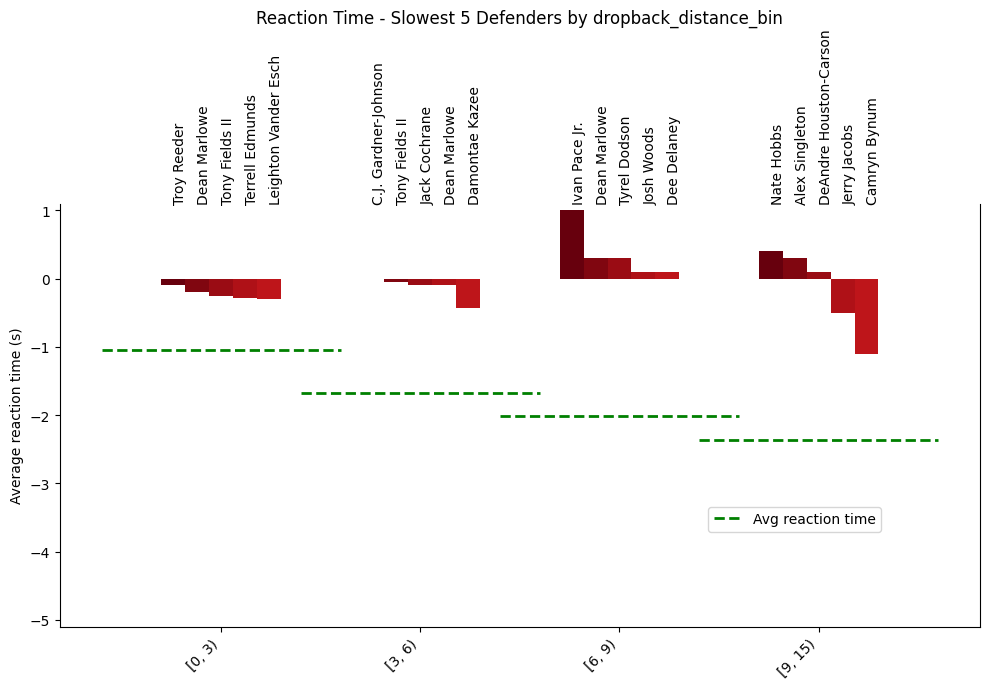

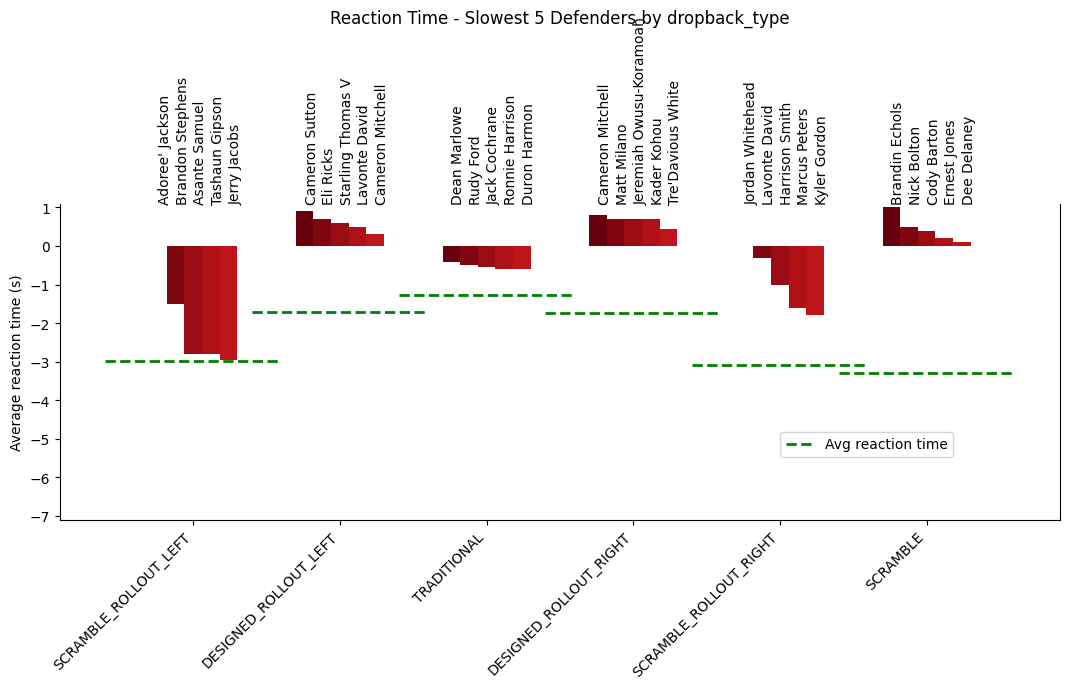

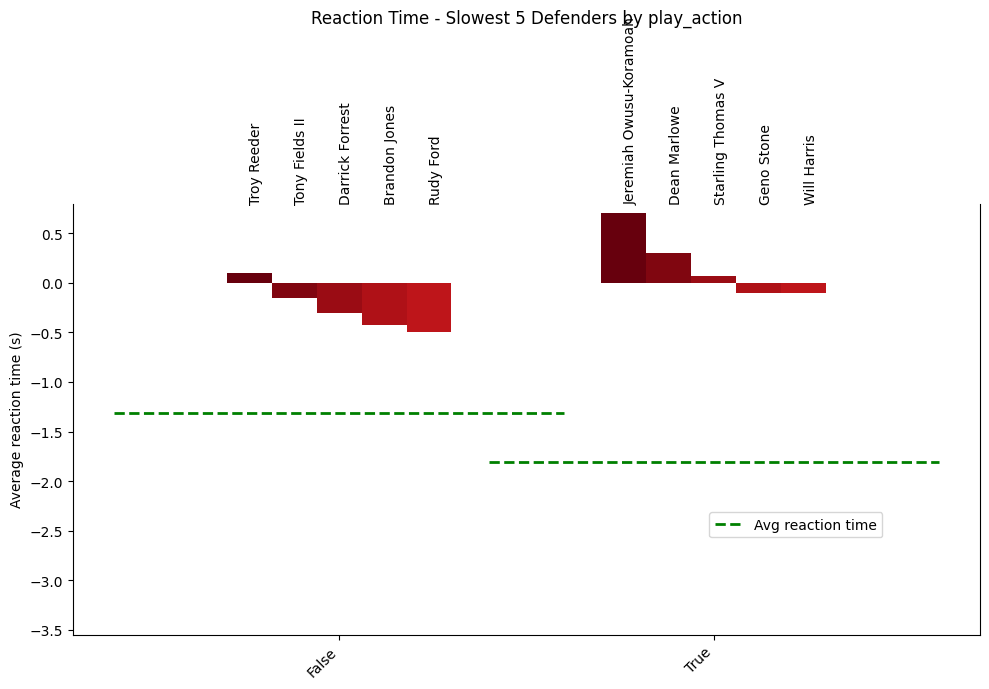

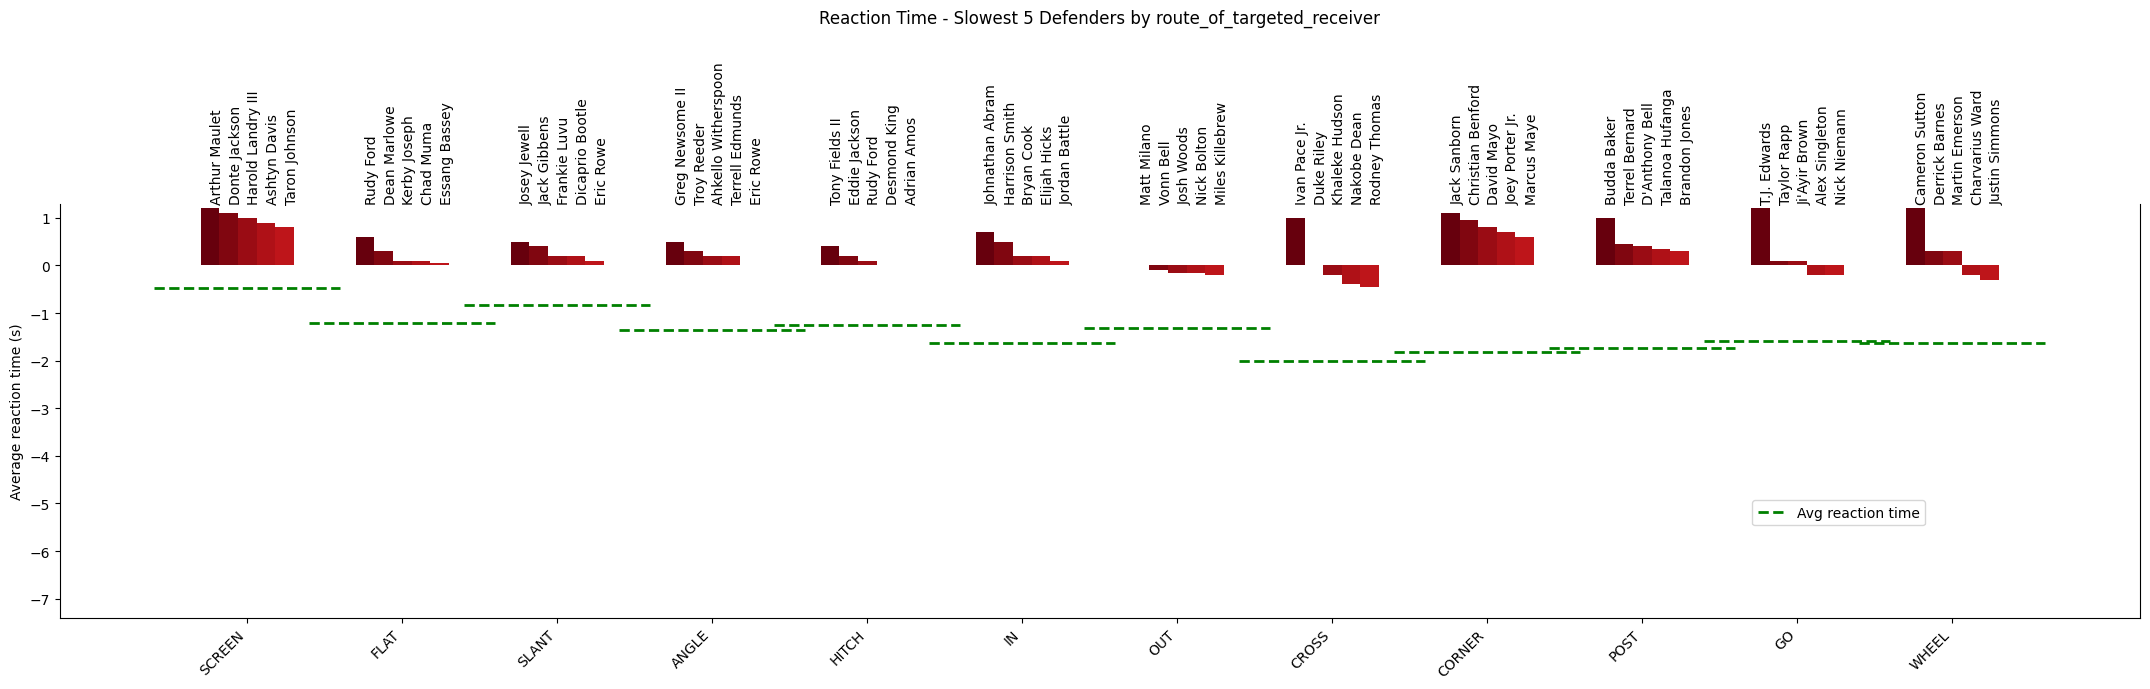

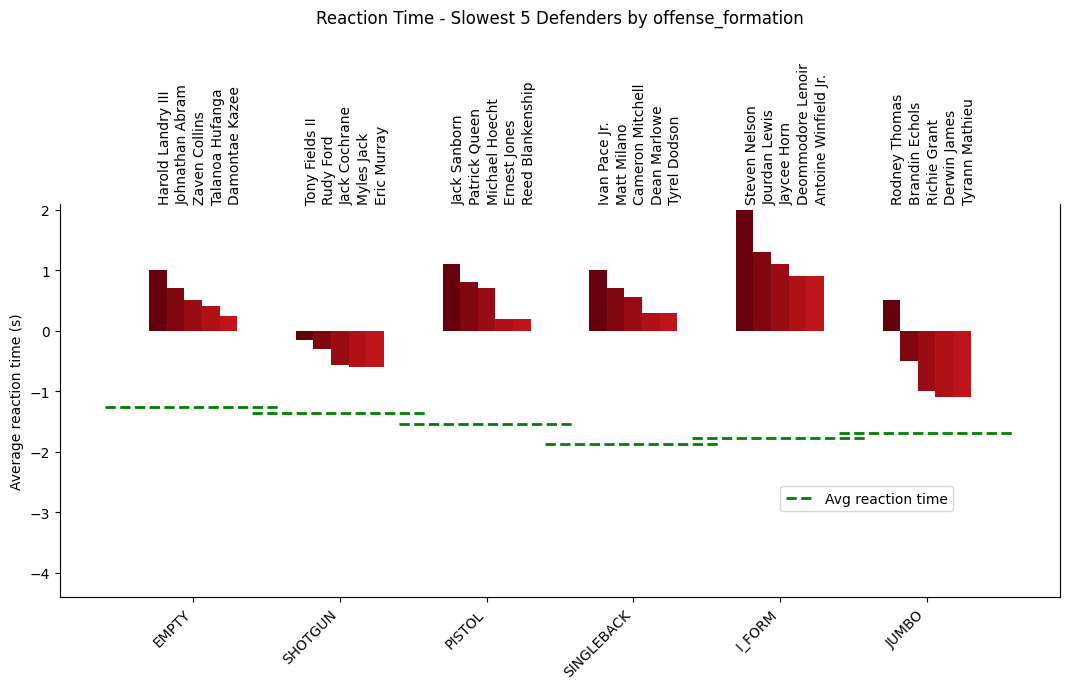

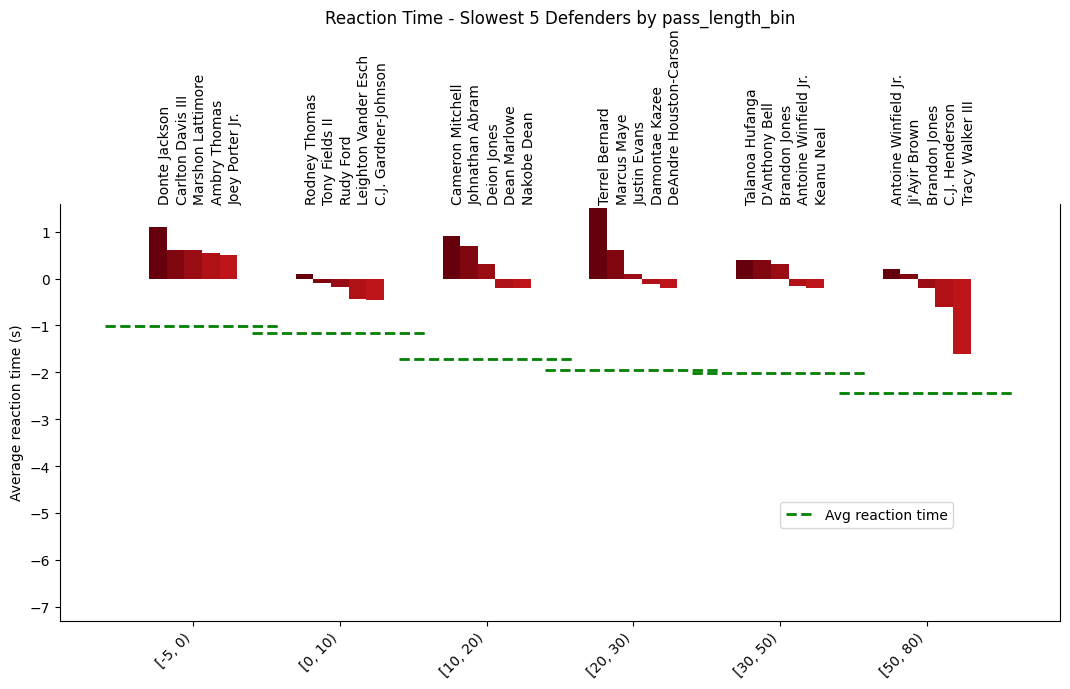

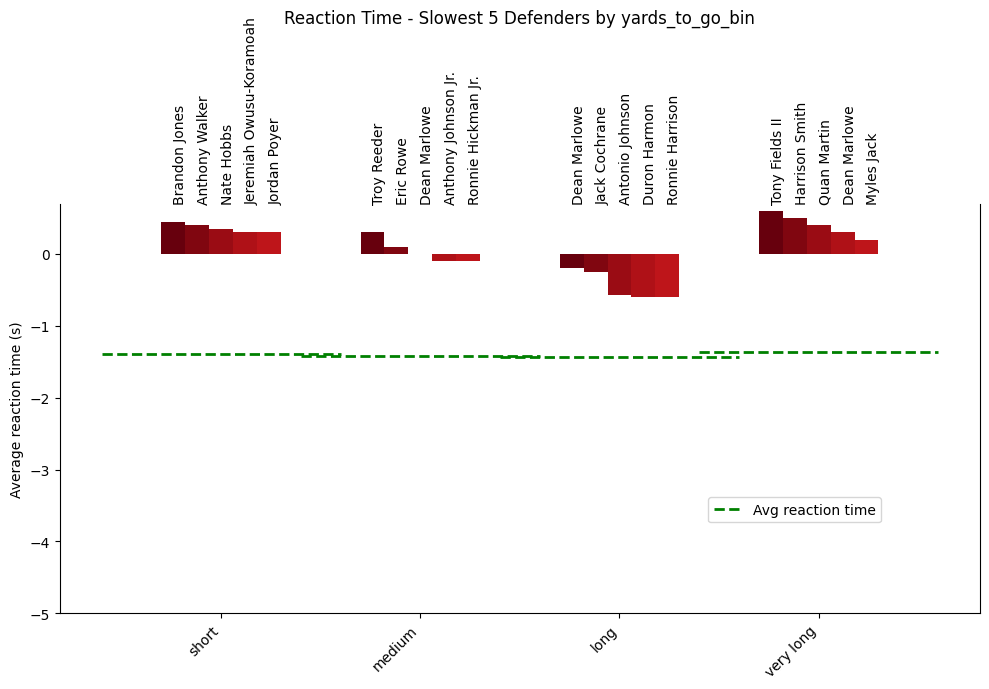

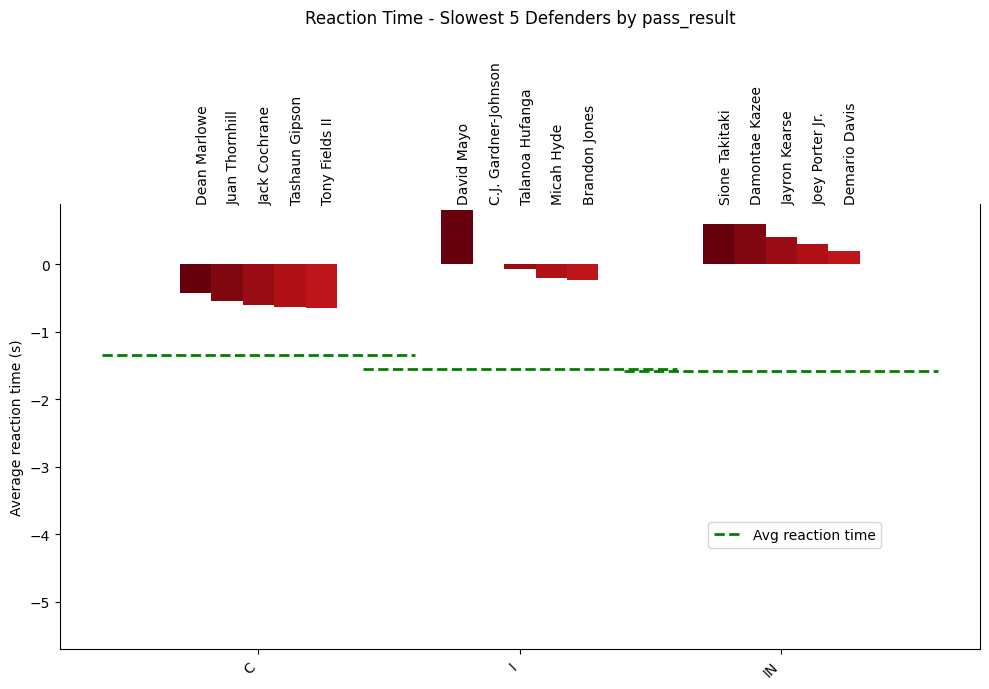

In [66]:
# team_coverage_type
coverage_type_order = [
    "COVER_0_MAN",
    "COVER_1_MAN",
    "COVER_2_MAN",
    "COVER_2_ZONE",
    "COVER_3_ZONE",
    "COVER_4_ZONE",
    "COVER_6_ZONE",
    "PREVENT",
]
plot_slowest_players_by_segment(arrival_df_wide_filtered, "team_coverage_type",
                                seg_order=coverage_type_order,
                                title_prefix="Reaction Time - ")

# team_coverage_man_zone
coverage_mz_order = ["MAN_COVERAGE", "ZONE_COVERAGE"]
plot_slowest_players_by_segment(arrival_df_wide_filtered, "team_coverage_man_zone",
                                seg_order=coverage_mz_order,
                                title_prefix="Reaction Time - ")


# defenders_in_the_box (treated as numeric, ascending)
def_box_order = sorted(arrival_df_wide_filtered["defenders_in_the_box"].dropna().unique())
plot_slowest_players_by_segment(arrival_df_wide_filtered, "defenders_in_the_box",
                                seg_order=def_box_order,
                                title_prefix="Reaction Time - ")

# pass_location_type
pass_loc_order = ["INSIDE_BOX", "OUTSIDE_LEFT", "OUTSIDE_RIGHT", "UNKNOWN"]
plot_slowest_players_by_segment(arrival_df_wide_filtered, "pass_location_type",
                                seg_order=pass_loc_order,
                                title_prefix="Reaction Time - ")

# dropback_distance_bin (already created)
dropback_dist_order = sorted(arrival_df_wide_filtered["dropback_distance_bin"].dropna().unique())
plot_slowest_players_by_segment(arrival_df_wide_filtered, "dropback_distance_bin",
                                seg_order=dropback_dist_order,
                                title_prefix="Reaction Time - ")

# dropback_type
plot_slowest_players_by_segment(arrival_df_wide_filtered, "dropback_type",
                                seg_order=dropback_type_order,
                                title_prefix="Reaction Time - ")

# play_action
play_action_order = [False, True]
plot_slowest_players_by_segment(arrival_df_wide_filtered, "play_action",
                                seg_order=play_action_order,
                                title_prefix="Reaction Time - ")

# route_of_targeted_receiver
plot_slowest_players_by_segment(arrival_df_wide_filtered, "route_of_targeted_receiver",
                                seg_order=route_order,
                                title_prefix="Reaction Time - ")

# offense_formation
offense_order = ["EMPTY", "SHOTGUN", "PISTOL", "SINGLEBACK", "I_FORM", "JUMBO"]
plot_slowest_players_by_segment(arrival_df_wide_filtered, "offense_formation",
                                seg_order=offense_order,
                                title_prefix="Reaction Time - ")

# pass_length_bin
pass_length_order = sorted(arrival_df_wide_filtered["pass_length_bin"].dropna().unique())
plot_slowest_players_by_segment(arrival_df_wide_filtered, "pass_length_bin",
                                seg_order=pass_length_order,
                                title_prefix="Reaction Time - ")

# yards_to_go_bin
yards_to_go_order = ["short", "medium", "long", "very long"]
plot_slowest_players_by_segment(arrival_df_wide_filtered, "yards_to_go_bin",
                                seg_order=yards_to_go_order,
                                title_prefix="Reaction Time - ")

# pass_result
pass_result_order = ["C", "I", "IN"]  # or whatever order you prefer
plot_slowest_players_by_segment(arrival_df_wide_filtered, "pass_result",
                                seg_order=pass_result_order,
                                title_prefix="Reaction Time - ")


# Look into How Catch Probability Changes When Players Have High-End Reaction Time
- This time with reaction time included in catch probability model
- Filtering for players that have players with upper 20% reaction times and comparing against everyone else
- Compare base rate catch probability with the catch probability allowed by top 20% in reaction speed

In [67]:
def summarize_feature(df, feat_col, order=None):
    tmp = df.dropna(subset=[feat_col, "catch_probability", "catch_prob_xgb"]).copy()
    summary = (
        tmp.groupby(feat_col)[["catch_probability", "catch_prob_xgb"]]
        .mean()
        .reset_index()
        .rename(columns={
            "catch_probability": "avg_catch_prob_old",
            "catch_prob_xgb": "avg_catch_prob_new",
        })
    )
    if order is not None:
        summary[feat_col] = pd.Categorical(summary[feat_col],
                                           categories=order,
                                           ordered=True)
        summary = summary.sort_values(feat_col)
    return summary


from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

def plot_feature_change(summary_df, x_col, title, rotation=45):
    x_vals = summary_df[x_col].astype(str).values
    new_vals = summary_df["avg_catch_prob_new"].values
    old_vals = summary_df["avg_catch_prob_old"].values

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(range(len(x_vals)), new_vals,
           color="navy", label="Filtered for players in top 20% of reaction_time")

    for i, y_old in enumerate(old_vals):
        ax.hlines(y_old, i - 0.4, i + 0.4,
                  colors="red", linestyles="--", linewidth=2)

    benchmark_proxy = Line2D([0], [0], color="red",
                             linestyle="--", linewidth=2)
    ax.legend([ax.patches[0], benchmark_proxy],
              ["Filtered for players in top 20% of reaction_time",
               "Baseline (No reaction_time information)"],
              loc="lower right", framealpha=1 )

    ax.set_xticks(range(len(x_vals)))
    ax.set_xticklabels(x_vals, rotation=rotation, ha="right")
    ax.set_ylabel("Expected Catch Probability Allowed")
    ax.set_title(title)
    fig.tight_layout()
    plt.show()


In [68]:
# defender-level average reaction time across all their plays
def_avg_rt = (
    arrival_df_wide_name
    .groupby("def_name")["reaction_time"]
    .mean()
    .reset_index()
    .rename(columns={"reaction_time": "avg_reaction_time"})
)

# threshold for top 20% (fastest = smallest reaction_time)
rt_80 = def_avg_rt["avg_reaction_time"].quantile(0.2)  # 20th percentile

top20_defenders = def_avg_rt.loc[
    def_avg_rt["avg_reaction_time"] <= rt_80, "def_name"
]


In [69]:
fast_arrival = arrival_df_wide_name[
    arrival_df_wide_name["def_name"].isin(top20_defenders)
].copy()

# one row per play with XGB catch probability, restricted to fast secondaries
fast_play_probs_new = (
    fast_arrival
    .drop_duplicates(subset=["game_id", "play_id"])
    [["game_id", "play_id", "catch_prob_xgb"]]
)


arrival_play_probs_old = (
    arrival_df_with_probs
    .drop_duplicates(subset=["game_id", "play_id"])
    [["game_id", "play_id", "catch_probability"]]
)


In [70]:
sup_fast = (
    sup.merge(arrival_play_probs_old, on=["game_id", "play_id"], how="inner")
       .merge(fast_play_probs_new,     on=["game_id", "play_id"], how="inner")
)


In [74]:
sup_fast["dropback_distance_bin"] = pd.cut(
    sup_fast["dropback_distance"],
    bins=[-5, 0, 3, 6, 9, 15],
    right=False,
    include_lowest=True,
)

sup_fast["pass_length_bin"] = pd.cut(
    sup_fast["pass_length"],
    bins=[-5, 0, 10, 20, 30, 50, 80],
    right=False,
    include_lowest=True,
)



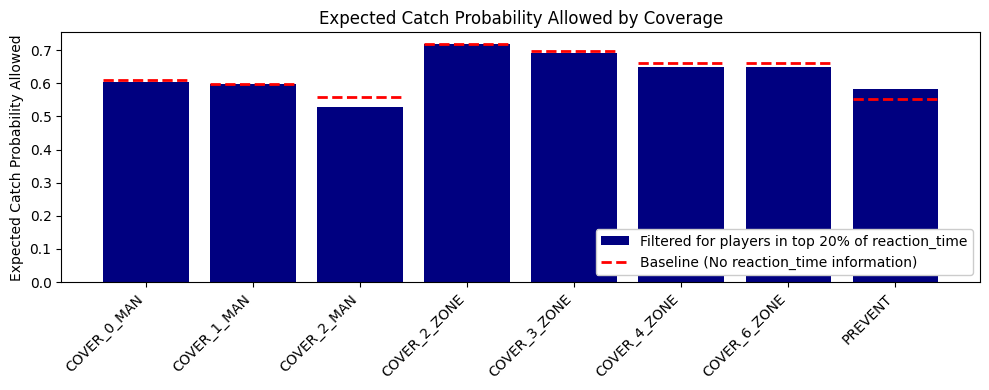

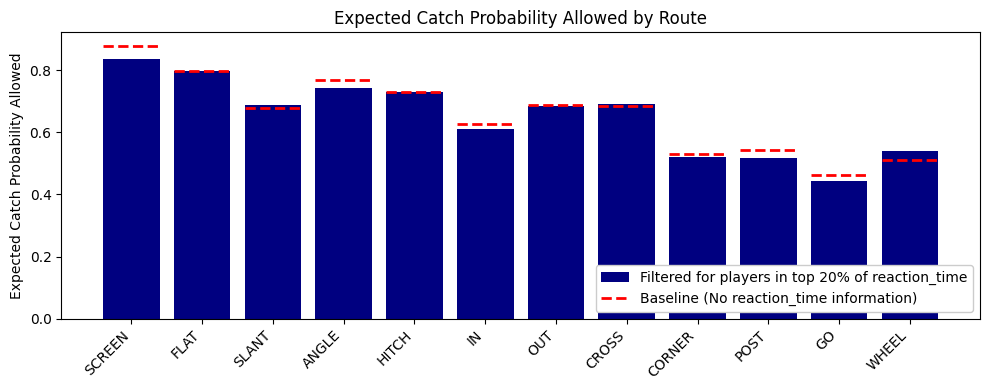

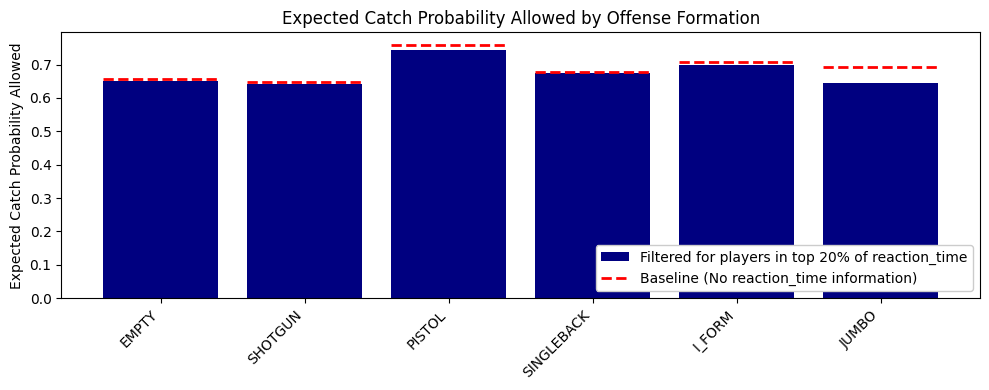

In [75]:
# assumed orders already defined in your code:
coverage_type_order = [
    "COVER_0_MAN", "COVER_1_MAN", "COVER_2_MAN",
    "COVER_2_ZONE", "COVER_3_ZONE", "COVER_4_ZONE",
    "COVER_6_ZONE", "PREVENT",
]
coverage_mz_order = ["MAN_COVERAGE", "ZONE_COVERAGE"]
def_box_order = sorted(sup_fast["defenders_in_the_box"].dropna().unique())
pass_loc_order = ["INSIDE_BOX", "OUTSIDE_LEFT", "OUTSIDE_RIGHT", "UNKNOWN"]
dropback_dist_order = sorted(sup_fast["dropback_distance_bin"].dropna().unique())
play_action_order = [False, True]
route_order = [
    "SCREEN", "FLAT", "SLANT", "ANGLE", "HITCH",
    "IN", "OUT", "CROSS",
    "CORNER", "POST", "GO", "WHEEL",
]
offense_order = ["EMPTY", "SHOTGUN", "PISTOL",
                 "SINGLEBACK", "I_FORM", "JUMBO"]
pass_length_order = sorted(sup_fast["pass_length_bin"].dropna().unique())
dropback_type_order = [
    "SCRAMBLE_ROLLOUT_LEFT",
    "DESIGNED_ROLLOUT_LEFT",
    "TRADITIONAL",
    "DESIGNED_ROLLOUT_RIGHT",
    "SCRAMBLE_ROLLOUT_RIGHT",
    "SCRAMBLE",
]

# team_coverage_type
summary = summarize_feature(sup_fast, "team_coverage_type",
                            order=coverage_type_order)
plot_feature_change(summary,
    "team_coverage_type",
    "Expected Catch Probability Allowed by Coverage",
)


# route_of_targeted_receiver
summary = summarize_feature(sup_fast, "route_of_targeted_receiver",
                            order=route_order)
plot_feature_change(summary,
    "route_of_targeted_receiver",
    "Expected Catch Probability Allowed by Route",
)

# offense_formation
summary = summarize_feature(sup_fast, "offense_formation",
                            order=offense_order)
plot_feature_change(summary,
    "offense_formation",
    "Expected Catch Probability Allowed by Offense Formation",
)
